# Setup

In [238]:
# Add parent directory to current path. Needed for research imports.
import os.path
import sys
p = os.path.abspath('../..')
if p not in sys.path:
    sys.path.insert(0,p)

# Enable hot reloading
%load_ext autoreload
%autoreload 2


import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

from experiments.irl.datasets import *
from experiments.irl.experiment_utils import *
from research.irl.fair_irl import *
from research.utils import *


logging.basicConfig(level=logging.INFO)
warnings.filterwarnings('ignore')

sns.set_style('darkgrid')

from IPython.display import display, HTML
display(HTML("<style>.container { width:1800px !important; }</style>"))
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_colwidth', None)

# Run experiments

In [539]:
base_exp_info = {
    'EXPERIMENT_NAME': 'thesis_7',
    
    'FEAT_EXP_OBJECTIVE_NAMES': [
        'Acc',
        'DemPar',
        'EqOpp',
#         'FPRPar',
#         'TNRPar',
#         'FNRPar',
#         'TPR_Z0',
#         'TPR_Z1',
#         'TNR_Z0',
#         'TNR_Z1',
#         'FPR_Z0',
#         'FPR_Z1',
#         'FNR_Z0',
#         'FNR_Z1',
    ],
    'PERF_MEAS_OBJECTIVE_NAMES': [
        'Acc',
        'DemPar',
        'EqOpp',
    ],
    
    # Expert demo parameters
    'DATASET': 'Boston',
    'TARGET_DATASET': 'COMPAS',
    'N_EXPERT_DEMOS': 3,
    'EXPERT_ALGO': None,
    'N_DATASET_SAMPLES': 20_000,
    'MIN_FREQ_FILL_PCT': .05,
    'RESTRICT_Y_ACTION': True,
    # IRL Loop parameters
    'IRL_METHOD': None,
    'METHOD': 'highs',
    # Plotting parameters
    'NOISE_FACTOR': .02,
    'ANNOTATE': True,
    'N_INIT_POLICIES': 3,
    'NON_EXPERT_ALGOS': [
        'OptAccNoisy',
        'HardtDemParNoisy',
        'HardtEqOppNoisy',
#             'Dummy',
#         'DummyNoisy',
    ],
}

In [561]:
base_exp_info['N_TRIALS'] = 10
# base_exp_info['IGNORE_RESULTS_EPSILON'] = .06
base_exp_info['EPSILON'] = .015
base_exp_info['IGNORE_RESULTS_EPSILON'] = np.infty
# base_exp_info['IGNORE_RESULTS_EPSILON'] = .05
base_exp_info['MAX_ITER'] = 15
base_exp_info['ALLOW_NEG_WEIGHTS'] = False
base_exp_info['DOT_WEIGHTS_FEAT_EXP'] = True
base_exp_info['IRL_ERROR_ENCOURAGE_EVEN_WEIGHTS'] = False
base_exp_info['IRL_ERROR_ENCOURAGE_UNEVEN_WEIGHTS'] = False

In [566]:
experiments = [
    
    
    {
        'EXPERT_ALGO': 'OptAcc',
        'IRL_METHOD': 'FairIRL',
    },
    {
        'EXPERT_ALGO': 'HardtDemPar',
        'IRL_METHOD': 'FairIRL',
    },
    {
        'EXPERT_ALGO': 'HardtEqOpp',
        'IRL_METHOD': 'FairIRL',
    },
    
    {
        'EXPERT_ALGO': 'OptAcc',
        'IRL_METHOD': 'FairIRLFO',
    },
    {
        'EXPERT_ALGO': 'HardtDemPar',
        'IRL_METHOD': 'FairIRLFO',
    },
    {
        'EXPERT_ALGO': 'HardtEqOpp',
        'IRL_METHOD': 'FairIRLFO',
    },
]

In [567]:
# for exp_i, experiment in enumerate(experiments):
#     logging.info('\n\n')
#     logging.info(f"EXPERIMENT {exp_i+1}/{len(experiments)}")
    
#     exp_info = dict(base_exp_info)
    
#     for k in experiment:
#         exp_info[k] = experiment[k]
        
#     run_experiment(exp_info)

In [568]:
exp_info = dict(base_exp_info)

In [569]:
source_X, source_y, source_feature_types = generate_dataset(
    exp_info['DATASET'],
    n_samples=exp_info['N_DATASET_SAMPLES'],
)
    
target_X, target_y, target_feature_types = generate_dataset(
    exp_info['TARGET_DATASET'],
    n_samples=exp_info['N_DATASET_SAMPLES'],
)

for f in source_feature_types['categoric']:
    source_X[f] = source_X[f].astype(str)
    
for f in target_feature_types['categoric']:
    target_X[f] = target_X[f].astype(str)

for exp_i, experiment in enumerate(experiments):
    logging.info('\n\n')
    logging.info(f"EXPERIMENT {exp_i+1}/{len(experiments)}")
    
    exp_info = dict(base_exp_info)
    
    for k in experiment:
        exp_info[k] = experiment[k]
        
    run_experiment(
        exp_info,
        source_X=source_X,
        source_y=source_y,
        source_feature_types=source_feature_types,
        target_X=target_X,
        target_y=target_y,
        target_feature_types=target_feature_types,
    )

INFO:root:


INFO:root:EXPERIMENT 1/6
INFO:root:exp_info: {'EXPERIMENT_NAME': 'thesis_5', 'FEAT_EXP_OBJECTIVE_NAMES': ['Acc', 'DemPar', 'EqOpp'], 'PERF_MEAS_OBJECTIVE_NAMES': ['Acc', 'DemPar', 'EqOpp'], 'DATASET': 'Boston', 'TARGET_DATASET': 'COMPAS', 'N_EXPERT_DEMOS': 3, 'EXPERT_ALGO': 'OptAcc', 'N_DATASET_SAMPLES': 20000, 'MIN_FREQ_FILL_PCT': 0.05, 'RESTRICT_Y_ACTION': True, 'IRL_METHOD': 'FairIRL', 'METHOD': 'highs', 'NOISE_FACTOR': 0.02, 'ANNOTATE': True, 'N_INIT_POLICIES': 3, 'NON_EXPERT_ALGOS': ['OptAccNoisy', 'HardtDemParNoisy', 'HardtEqOppNoisy'], 'N_TRIALS': 10, 'EPSILON': 0.015, 'IGNORE_RESULTS_EPSILON': inf, 'MAX_ITER': 15, 'ALLOW_NEG_WEIGHTS': False, 'DOT_WEIGHTS_FEAT_EXP': True, 'IRL_ERROR_ENCOURAGE_EVEN_WEIGHTS': False, 'IRL_ERROR_ENCOURAGE_UNEVEN_WEIGHTS': False}
INFO:root:

TRIAL 0

INFO:root:muE:
[[0.83923304 0.68165705 0.69488573]
 [0.84513274 0.78987867 0.86746595]
 [0.85004916 0.81219845 0.95428979]]
INFO:root:muE_hold:
[[0.82300885 0.71906181 0.70902256]
 [0.859390

,Acc,DemPar,EqOpp
2,0.850049,0.812198,0.954290
0,0.839233,0.681657,0.694886
7,0.839397,0.853577,0.975504
5,0.743793,0.866138,0.976998


INFO:root:		Allowing negative weights.
INFO:root:		 muL[3] = [0.555 0.341 0.957]
INFO:root:		 Best mu_delta[3] 	= [ 0.005 -0.092 -0.137]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.002 -0.088 -0.137]
INFO:root:		 t[3] 		= 0.05609
INFO:root:		 t_hold[i] 	= 0.05431
INFO:root:		 weights[3] 	= [ 0.269 -0.48   0.252]
INFO:root:	IRL Loop iteration 5/15 ...
INFO:root:		 muL[4] = [0.839 0.854 0.976]
INFO:root:		 Best mu_delta[4] 	= [ 0.005 -0.092 -0.137]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.002 -0.088 -0.137]
INFO:root:		 t[4] 		= 0.03214
INFO:root:		 t_hold[i] 	= 0.03194
INFO:root:		 weights[4] 	= [0.767 0.    0.233]
INFO:root:	IRL Loop iteration 6/15 ...
INFO:root:		 muL[5] = [0.839 0.854 0.976]
INFO:root:		 Best mu_delta[5] 	= [ 0.005 -0.092 -0.137]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.002 -0.088 -0.137]
INFO:root:		 t[5] 		= 0.03141
INFO:root:		 t_hold[i] 	= 0.03120
INFO:root:		 weights[5] 	= [0.772 0.    0.228]
INFO:root:	IRL Loop iteration 7/15 ...
INFO:root:		 muL[6] = [0.839 0.

,Acc,DemPar,EqOpp
0,0.839233,0.681657,0.694886
1,0.845133,0.789879,0.867466
11,0.839397,0.853577,0.975504
3,0.842602,0.720579,0.708497


INFO:root:		 muL[7] = [0.839 0.854 0.976]
INFO:root:		 Best mu_delta[7] 	= [ 0.29   0.42  -0.118]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.294  0.394 -0.08 ]
INFO:root:		 t[7] 		= 0.10993
INFO:root:		 t_hold[i] 	= 0.08356
INFO:root:		 weights[7] 	= [0.175 0.    0.825]
INFO:root:	IRL Loop iteration 9/15 ...
INFO:root:		 muL[8] = [0.839 0.854 0.976]
INFO:root:		 Best mu_delta[8] 	= [ 0.005 -0.092 -0.137]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.002 -0.088 -0.137]
INFO:root:		 t[8] 		= 0.03290
INFO:root:		 t_hold[i] 	= 0.03271
INFO:root:		 weights[8] 	= [ 0.761 -0.     0.239]
INFO:root:	IRL Loop iteration 10/15 ...
INFO:root:		 muL[9] = [0.839 0.854 0.976]
INFO:root:		 Best mu_delta[9] 	= [ 0.005 -0.092 -0.137]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.002 -0.088 -0.137]
INFO:root:		 t[9] 		= 0.03124
INFO:root:		 t_hold[i] 	= 0.03103
INFO:root:		 weights[9] 	= [ 0.773 -0.     0.227]
INFO:root:	IRL Loop iteration 11/15 ...
INFO:root:		 muL[10] = [0.839 0.854 0.976]
INFO:root:		 Best mu_d

,Acc,DemPar,EqOpp
2,0.850049,0.812198,0.954290
1,0.845133,0.789879,0.867466
15,0.839397,0.853577,0.975504
10,0.839397,0.853577,0.975504


INFO:root:		Allowing negative weights.
INFO:root:		 muL[11] = [0.614 0.41  0.986]
INFO:root:		 Best mu_delta[11] 	= [ 0.005 -0.092 -0.137]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.002 -0.088 -0.137]
INFO:root:		 t[11] 		= 0.03579
INFO:root:		 t_hold[i] 	= 0.03454
INFO:root:		 weights[11] 	= [ 0.534 -0.309  0.157]
INFO:root:	IRL Loop iteration 13/15 ...
INFO:root:		 muL[12] = [0.839 0.854 0.976]
INFO:root:		 Best mu_delta[12] 	= [ 0.005 -0.092 -0.137]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.002 -0.088 -0.137]
INFO:root:		 t[12] 		= 0.02918
INFO:root:		 t_hold[i] 	= 0.02894
INFO:root:		 weights[12] 	= [0.789 0.    0.211]
INFO:root:	IRL Loop iteration 14/15 ...
INFO:root:		 muL[13] = [0.839 0.854 0.976]
INFO:root:		 Best mu_delta[13] 	= [ 0.005 -0.092 -0.137]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.002 -0.088 -0.137]
INFO:root:		 t[13] 		= 0.02863
INFO:root:		 t_hold[i] 	= 0.02837
INFO:root:		 weights[13] 	= [ 0.793 -0.     0.207]
INFO:root:	IRL Loop iteration 15/15 ...
INFO:root:		 

,Acc,DemPar,EqOpp,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.839,0.682,0.695,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
1,0.845,0.790,0.867,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
2,0.850,0.812,0.954,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
3,0.843,0.721,0.708,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.000,0.000,inf,inf,0.0,0.0
4,0.738,0.983,0.905,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
5,0.744,0.866,0.977,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,2.0,0.000,0.000,0.000,inf,inf,0.0,0.0
6,0.839,0.854,0.976,0,0.839,0.841,0.841,0.854,0.853,0.853,0.976,0.988,0.988,0.841,0.853,0.988,0.0,3.0,0.255,0.000,0.745,0.102,0.102,0.0,0.0
7,0.839,0.854,0.976,0,0.839,0.841,0.841,0.854,0.853,0.853,0.976,0.988,0.988,0.841,0.853,0.988,0.0,4.0,0.175,-0.000,0.825,0.113,0.113,0.0,0.0
8,0.839,0.854,0.976,0,0.839,0.841,0.841,0.854,0.853,0.853,0.976,0.988,0.988,0.841,0.853,0.988,0.0,5.0,0.175,0.000,0.825,0.113,0.113,0.0,0.0
9,0.555,0.341,0.957,0,0.839,0.545,0.841,0.854,0.371,0.853,0.976,0.931,0.988,0.841,0.853,0.988,0.0,6.0,0.269,-0.480,0.252,0.056,0.054,0.0,0.0


INFO:root:muE_target:
[[0.64197531 0.83214028 0.83478614]
 [0.61111111 0.71500978 0.71430418]
 [0.61522634 0.74333277 0.70219856]]
INFO:root:muE_perf_target:
[[0.64677641 0.86498815 0.90077598]
 [0.61316872 0.72977771 0.73788908]
 [0.61796982 0.67753084 0.62850467]]
INFO:root:target domain muL = [0.635 0.969 1.   ]
INFO:root:target domain muE = [0.623 0.763 0.75 ]
INFO:root:target domain muL_hold = [0.619 0.965 0.999]
INFO:root:target domain muL_perf_hold = [0.619 0.965 0.999]
INFO:root:

TRIAL 1

INFO:root:muE:
[[0.83972468 0.68746261 0.71434573]
 [0.85152409 0.74255289 0.75321774]
 [0.83038348 0.78019086 0.88143479]]
INFO:root:muE_hold:
[[0.86135693 0.78026721 0.91111111]
 [0.86037365 0.76847271 0.90074112]
 [0.83480826 0.78899776 0.85320008]]
INFO:root:muE_perf_hold:
[[0.86135693 0.78026721 0.91111111]
 [0.86037365 0.76847271 0.90074112]
 [0.83480826 0.78899776 0.85320008]]
INFO:root:muL:
[[0.84409136 0.77492654 0.75693837]
 [0.74428997 0.99564579 0.96429617]
 [0.73237339 0.89152637

,Acc,DemPar,EqOpp,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.840,0.687,0.714,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
1,0.852,0.743,0.753,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
2,0.830,0.780,0.881,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
3,0.844,0.775,0.757,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.000,0.000,inf,inf,0.0,0.0
4,0.744,0.996,0.964,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
5,0.732,0.892,0.903,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,2.0,0.000,0.000,0.000,inf,inf,0.0,0.0
6,0.551,0.118,0.535,0,0.551,0.561,0.561,0.118,0.143,0.143,0.535,0.627,0.627,0.561,0.143,0.627,0.0,3.0,0.123,-0.663,0.214,0.415,0.427,0.0,0.0
7,0.840,0.821,0.941,0,0.840,0.846,0.846,0.821,0.846,0.846,0.941,0.996,0.996,0.846,0.846,0.996,0.0,4.0,0.752,0.000,0.248,0.039,0.027,0.0,0.0
8,0.840,0.821,0.941,0,0.840,0.846,0.846,0.821,0.846,0.846,0.941,0.996,0.996,0.846,0.846,0.996,0.0,5.0,0.838,0.000,0.162,0.026,0.018,0.0,0.0
9,0.840,0.821,0.941,0,0.840,0.846,0.846,0.821,0.846,0.846,0.941,0.996,0.996,0.846,0.846,0.996,0.0,6.0,0.913,0.000,0.087,0.014,0.011,0.0,0.0


INFO:root:muE_target:
[[0.62071331 0.77819309 0.77851019]
 [0.62620027 0.85365328 0.86106266]
 [0.61865569 0.88733099 0.90786369]]
INFO:root:muE_perf_target:
[[0.62002743 0.78021738 0.77851019]
 [0.62620027 0.85365328 0.86106266]
 [0.61728395 0.90579501 0.92180791]]
INFO:root:target domain muL = [0.631 0.995 0.974]
INFO:root:target domain muE = [0.622 0.84  0.849]
INFO:root:target domain muL_hold = [0.61  0.974 0.993]
INFO:root:target domain muL_perf_hold = [0.61  0.974 0.993]
INFO:root:

TRIAL 2

INFO:root:muE:
[[0.84021632 0.7792809  0.86526376]
 [0.85004916 0.72319257 0.77531309]
 [0.84906588 0.72869025 0.74964556]]
INFO:root:muE_hold:
[[0.84267453 0.7965477  0.80162037]
 [0.82792527 0.7021938  0.6727808 ]
 [0.82890855 0.81280415 0.87874195]]
INFO:root:muE_perf_hold:
[[0.84169125 0.71189921 0.69421296]
 [0.83087512 0.7188051  0.7352808 ]
 [0.83284169 0.83726898 0.94770746]]
INFO:root:muL:
[[0.83862959 0.77735899 0.85215136]
 [0.71648461 0.97660704 0.8529251 ]
 [0.72343595 0.86275034

,Acc,DemPar,EqOpp
2,0.849066,0.728690,0.749646
1,0.850049,0.723193,0.775313
6,0.845624,0.850445,0.972365
7,0.845624,0.850445,0.972365


INFO:root:		Allowing negative weights.
INFO:root:		 muL[5] = [0.545 0.127 0.569]
INFO:root:		 Best mu_delta[5] 	= [ 0.001 -0.107 -0.176]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.001 -0.095 -0.177]
INFO:root:		 t[5] 		= 0.06444
INFO:root:		 t_hold[i] 	= 0.05916
INFO:root:		 weights[5] 	= [ 0.294 -0.524  0.182]
INFO:root:	IRL Loop iteration 7/15 ...
INFO:root:		 muL[6] = [0.846 0.85  0.972]
INFO:root:		 Best mu_delta[6] 	= [ 0.001 -0.107 -0.176]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.001 -0.095 -0.177]
INFO:root:		 t[6] 		= 0.04031
INFO:root:		 t_hold[i] 	= 0.04057
INFO:root:		 weights[6] 	= [ 0.771 -0.     0.229]
INFO:root:	IRL Loop iteration 8/15 ...
INFO:root:		 muL[7] = [0.846 0.85  0.972]
INFO:root:		 Best mu_delta[7] 	= [ 0.001 -0.107 -0.176]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.001 -0.095 -0.177]
INFO:root:		 t[7] 		= 0.04018
INFO:root:		 t_hold[i] 	= 0.04044
INFO:root:		 weights[7] 	= [ 0.771 -0.     0.229]
INFO:root:		Stuck in loop
INFO:root:	IRL Loop iteration 9/15 ...

,Acc,DemPar,EqOpp
2,0.849066,0.728690,0.749646
0,0.840216,0.779281,0.865264
3,0.838630,0.777359,0.852151
8,0.845624,0.850445,0.972365


INFO:root:		 muL[8] = [0.846 0.85  0.972]
INFO:root:		 Best mu_delta[8] 	= [ 0.001 -0.107 -0.176]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.001 -0.095 -0.177]
INFO:root:		 t[8] 		= 0.14389
INFO:root:		 t_hold[i] 	= 0.14481
INFO:root:		 weights[8] 	= [0.181 0.    0.819]
INFO:root:	IRL Loop iteration 10/15 ...
INFO:root:		 muL[9] = [0.846 0.85  0.972]
INFO:root:		 Best mu_delta[9] 	= [ 0.001 -0.107 -0.176]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.001 -0.095 -0.177]
INFO:root:		 t[9] 		= 0.04134
INFO:root:		 t_hold[i] 	= 0.04161
INFO:root:		 weights[9] 	= [ 0.765 -0.     0.235]
INFO:root:	IRL Loop iteration 11/15 ...
INFO:root:		 muL[10] = [0.846 0.85  0.972]
INFO:root:		 Best mu_delta[10] 	= [ 0.001 -0.107 -0.176]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.001 -0.095 -0.177]
INFO:root:		 t[10] 		= 0.03861
INFO:root:		 t_hold[i] 	= 0.03886
INFO:root:		 weights[10] 	= [ 0.78 -0.    0.22]
INFO:root:	IRL Loop iteration 12/15 ...
INFO:root:		 muL[11] = [0.846 0.85  0.972]
INFO:root:		 Best mu

,Acc,DemPar,EqOpp
1,0.850049,0.723193,0.775313
2,0.849066,0.728690,0.749646
15,0.845624,0.850445,0.972365
10,0.845624,0.850445,0.972365


INFO:root:		Allowing negative weights.
INFO:root:		 muL[13] = [0.613 0.402 0.983]
INFO:root:		 Best mu_delta[13] 	= [ 0.001 -0.107 -0.176]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.001 -0.095 -0.177]
INFO:root:		 t[13] 		= 0.04249
INFO:root:		 t_hold[i] 	= 0.03981
INFO:root:		 weights[13] 	= [ 0.539 -0.308  0.153]
INFO:root:	IRL Loop iteration 15/15 ...
INFO:root:		 muL[14] = [0.846 0.85  0.972]
INFO:root:		 Best mu_delta[14] 	= [ 0.001 -0.107 -0.176]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.001 -0.095 -0.177]
INFO:root:		 t[14] 		= 0.02627
INFO:root:		 t_hold[i] 	= 0.02644
INFO:root:		 weights[14] 	= [0.85 0.   0.15]
INFO:root:
Reached max iters.
INFO:root:Best Learned Policy yhat (not real yhat since doesn't factor mu0): 0.298
INFO:root:best weight:	 [0.85 0.   0.15]


,Acc,DemPar,EqOpp,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.840,0.779,0.865,1,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
1,0.850,0.723,0.775,1,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
2,0.849,0.729,0.750,1,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
3,0.839,0.777,0.852,0,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.000,0.000,inf,inf,0.0,0.0
4,0.716,0.977,0.853,0,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
5,0.723,0.863,0.999,0,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,2.0,0.000,0.000,0.000,inf,inf,0.0,0.0
6,0.846,0.850,0.972,0,0.846,0.834,0.834,0.85,0.865,0.865,0.972,0.961,0.961,0.834,0.865,0.961,0.0,3.0,0.181,0.000,0.819,0.144,0.145,0.0,0.0
7,0.846,0.850,0.972,0,0.846,0.834,0.834,0.85,0.865,0.865,0.972,0.961,0.961,0.834,0.865,0.961,0.0,4.0,0.156,0.000,0.844,0.148,0.149,0.0,0.0
8,0.846,0.850,0.972,0,0.846,0.834,0.834,0.85,0.865,0.865,0.972,0.961,0.961,0.834,0.865,0.961,0.0,5.0,0.128,0.000,0.872,0.153,0.154,0.0,0.0
9,0.846,0.850,0.972,0,0.846,0.834,0.834,0.85,0.865,0.865,0.972,0.961,0.961,0.834,0.865,0.961,0.0,6.0,0.181,-0.000,0.819,0.144,0.145,0.0,0.0


INFO:root:muE_target:
[[0.6303155  0.74629688 0.740297  ]
 [0.6399177  0.77139272 0.75379487]
 [0.63648834 0.7059148  0.69522145]]
INFO:root:muE_perf_target:
[[0.62757202 0.783289   0.78584566]
 [0.6303155  0.82194365 0.81502564]
 [0.63580247 0.69962976 0.69105894]]
INFO:root:target domain muL = [0.64  0.989 0.993]
INFO:root:target domain muE = [0.636 0.741 0.73 ]
INFO:root:target domain muL_hold = [0.617 0.99  0.962]
INFO:root:target domain muL_perf_hold = [0.617 0.99  0.962]
INFO:root:

TRIAL 3

INFO:root:muE:
[[0.8539823  0.80703479 0.90074847]
 [0.83579154 0.72881457 0.80347339]
 [0.84267453 0.77111091 0.84544992]]
INFO:root:muE_hold:
[[0.84759095 0.8102371  0.88632959]
 [0.8446411  0.72034173 0.8020461 ]
 [0.86135693 0.77199148 0.76282618]]
INFO:root:muE_perf_hold:
[[0.84759095 0.8102371  0.88632959]
 [0.8446411  0.72034173 0.8020461 ]
 [0.86135693 0.77199148 0.76282618]]
INFO:root:muL:
[[0.85004965 0.70238874 0.80533279]
 [0.73237339 0.9768241  0.82149704]
 [0.74428997 0.88562411

,Acc,DemPar,EqOpp
2,0.842675,0.771111,0.845450
0,0.853982,0.807035,0.900748
9,0.838578,0.863551,0.985087
5,0.744290,0.885624,0.988551


INFO:root:		Allowing negative weights.
INFO:root:		 muL[11] = [0.684 0.98  0.264]
INFO:root:		 Best mu_delta[11] 	= [ 0.006 -0.095 -0.135]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.002 -0.075 -0.135]
INFO:root:		 t[11] 		= 0.03503
INFO:root:		 t_hold[i] 	= 0.03187
INFO:root:		 weights[11] 	= [ 0.562  0.244 -0.194]
INFO:root:	IRL Loop iteration 13/15 ...
INFO:root:		 muL[12] = [0.839 0.864 0.985]
INFO:root:		 Best mu_delta[12] 	= [ 0.006 -0.095 -0.135]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.002 -0.075 -0.135]
INFO:root:		 t[12] 		= 0.02104
INFO:root:		 t_hold[i] 	= 0.01628
INFO:root:		 weights[12] 	= [0.782 0.218 0.   ]
INFO:root:	IRL Loop iteration 14/15 ...
INFO:root:		 muL[13] = [0.839 0.864 0.985]
INFO:root:		 Best mu_delta[13] 	= [ 0.006 -0.095 -0.135]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.002 -0.075 -0.135]
INFO:root:		 t[13] 		= 0.02007
INFO:root:		 t_hold[i] 	= 0.01549
INFO:root:		 weights[13] 	= [0.793 0.207 0.   ]
INFO:root:	IRL Loop iteration 15/15 ...
INFO:root:		 muL

,Acc,DemPar,EqOpp,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.854,0.807,0.901,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
1,0.836,0.729,0.803,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
2,0.843,0.771,0.845,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
3,0.850,0.702,0.805,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.000,0.000,inf,inf,0.0,0.0
4,0.732,0.977,0.821,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
5,0.744,0.886,0.989,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,2.0,0.000,0.000,0.000,inf,inf,0.0,0.0
6,0.765,0.842,0.875,0,0.765,0.764,0.764,0.842,0.839,0.839,0.875,0.953,0.953,0.764,0.839,0.953,0.0,3.0,0.633,0.268,0.099,0.054,0.060,0.0,0.0
7,0.765,0.842,0.875,0,0.765,0.764,0.764,0.842,0.839,0.839,0.875,0.953,0.953,0.764,0.839,0.953,0.0,4.0,0.636,0.264,0.100,0.054,0.060,0.0,0.0
8,0.771,0.906,0.978,0,0.765,0.785,0.764,0.842,0.912,0.839,0.875,0.974,0.953,0.764,0.839,0.953,0.0,5.0,0.632,0.271,0.096,0.054,0.059,0.0,0.0
9,0.839,0.864,0.985,0,0.839,0.853,0.853,0.864,0.842,0.842,0.985,0.952,0.952,0.853,0.842,0.952,0.0,6.0,0.690,0.306,0.004,0.029,0.023,0.0,0.0


INFO:root:muE_target:
[[0.62345679 0.72704018 0.76447259]
 [0.61591221 0.73206862 0.78058071]
 [0.60699588 0.72729695 0.77943564]]
INFO:root:muE_perf_target:
[[0.62620027 0.71073029 0.75102226]
 [0.61591221 0.73206862 0.78058071]
 [0.60082305 0.78273843 0.82149172]]
INFO:root:target domain muL = [0.626 0.989 0.961]
INFO:root:target domain muE = [0.615 0.729 0.775]
INFO:root:target domain muL_hold = [0.618 0.987 0.968]
INFO:root:target domain muL_perf_hold = [0.618 0.987 0.968]
INFO:root:

TRIAL 4

INFO:root:muE:
[[0.85250737 0.69619575 0.70632266]
 [0.84218289 0.72286693 0.79099914]
 [0.83923304 0.68181688 0.66131907]]
INFO:root:muE_hold:
[[0.84070796 0.71643168 0.73618538]
 [0.84857424 0.72523085 0.70320611]
 [0.84759095 0.8103505  0.91574468]]
INFO:root:muE_perf_hold:
[[0.84070796 0.71643168 0.73618538]
 [0.84365782 0.78216516 0.78717557]
 [0.84759095 0.8103505  0.91574468]]
INFO:root:muL:
[[0.83763654 0.73603456 0.84528224]
 [0.73386296 0.99479293 0.98718221]
 [0.76365442 0.90174579

,Acc,DemPar,EqOpp
1,0.842183,0.722867,0.790999
2,0.839233,0.681817,0.661319
8,0.834808,0.849401,0.942098
4,0.733863,0.994793,0.987182


INFO:root:		Allowing negative weights.
INFO:root:		 muL[3] = [0.69  0.989 0.271]
INFO:root:		 Best mu_delta[3] 	= [ 0.01  -0.149 -0.223]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.004 -0.115 -0.183]
INFO:root:		 t[3] 		= 0.09590
INFO:root:		 t_hold[i] 	= 0.07761
INFO:root:		 weights[3] 	= [ 0.32   0.299 -0.381]
INFO:root:	IRL Loop iteration 5/15 ...
INFO:root:		 muL[4] = [0.845 0.7   0.719]
INFO:root:		 Best mu_delta[4] 	= [ 0. -0.  0.]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.004  0.032  0.048]
INFO:root:		 t[4] 		= 0.00000
INFO:root:		 t_hold[i] 	= 0.00361
INFO:root:		 weights[4] 	= [ 1. -0. -0.]
INFO:root:Best Learned Policy yhat (not real yhat since doesn't factor mu0): 0.340
INFO:root:best weight:	 [ 1. -0. -0.]


,Acc,DemPar,EqOpp,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.853,0.696,0.706,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
1,0.842,0.723,0.791,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
2,0.839,0.682,0.661,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
3,0.838,0.736,0.845,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.000,0.000,inf,inf,0.0,0.0
4,0.734,0.995,0.987,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
5,0.764,0.902,0.994,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,2.0,0.000,0.000,0.000,inf,inf,0.0,0.0
6,0.518,0.000,0.000,0,0.518,0.504,0.504,0.000,0.000,0.000,0.000,0.000,0.000,0.504,0.000,0.000,0.0,3.0,0.063,-0.183,-0.754,0.558,0.608,0.0,0.0
7,0.835,0.849,0.942,0,0.835,0.841,0.841,0.849,0.865,0.865,0.942,0.968,0.968,0.841,0.865,0.968,0.0,4.0,0.462,0.538,0.000,0.080,0.062,0.0,0.0
8,0.835,0.849,0.942,0,0.835,0.841,0.841,0.849,0.865,0.865,0.942,0.968,0.968,0.841,0.865,0.968,0.0,5.0,0.462,0.538,-0.000,0.080,0.062,0.0,0.0
9,0.690,0.989,0.271,0,0.835,0.696,0.841,0.849,0.997,0.865,0.942,0.250,0.968,0.841,0.865,0.968,0.0,6.0,0.320,0.299,-0.381,0.096,0.078,0.0,0.0


INFO:root:muE_target:
[[0.60836763 0.8340554  0.83474414]
 [0.61111111 0.7342699  0.71770909]
 [0.63374486 0.79872994 0.80916306]]
INFO:root:muE_perf_target:
[[0.6042524  0.80096336 0.80629775]
 [0.61454047 0.75785449 0.74523202]
 [0.62414266 0.81107875 0.8219697 ]]
INFO:root:target domain muL = [0.639 0.75  0.761]
INFO:root:target domain muE = [0.618 0.789 0.787]
INFO:root:target domain muL_hold = [0.631 0.772 0.79 ]
INFO:root:target domain muL_perf_hold = [0.631 0.772 0.79 ]
INFO:root:

TRIAL 5

INFO:root:muE:
[[0.84070796 0.77595277 0.79890454]
 [0.85545723 0.71202998 0.73254534]
 [0.85152409 0.70032019 0.75672295]]
INFO:root:muE_hold:
[[0.86234022 0.72821828 0.74526327]
 [0.83087512 0.843789   0.94723295]
 [0.83775811 0.67976854 0.6656331 ]]
INFO:root:muE_perf_hold:
[[0.86234022 0.72821828 0.74526327]
 [0.83087512 0.843789   0.94723295]
 [0.83775811 0.67976854 0.6656331 ]]
INFO:root:muL:
[[0.82075472 0.81544549 0.88908281]
 [0.72591857 0.99345784 0.98919648]
 [0.75322741 0.83702041

,Acc,DemPar,EqOpp
2,0.851524,0.700320,0.756723
0,0.840708,0.775953,0.798905
7,0.847099,0.840915,0.948459
5,0.753227,0.837020,0.992092


INFO:root:		Allowing negative weights.
INFO:root:		 muL[3] = [0.754 0.716 0.126]
INFO:root:		 Best mu_delta[3] 	= [ 0.002 -0.111 -0.186]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.006 -0.116 -0.147]
INFO:root:		 t[3] 		= 0.06604
INFO:root:		 t_hold[i] 	= 0.05432
INFO:root:		 weights[3] 	= [ 0.472  0.192 -0.336]
INFO:root:	IRL Loop iteration 5/15 ...
INFO:root:		 muL[4] = [0.853 0.7   0.716]
INFO:root:		 Best mu_delta[4] 	= [ 0.002 -0.111 -0.186]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.006 -0.116 -0.147]
INFO:root:		 t[4] 		= 0.00213
INFO:root:		 t_hold[i] 	= 0.00623
INFO:root:		 weights[4] 	= [1. 0. 0.]
INFO:root:Best Learned Policy yhat (not real yhat since doesn't factor mu0): 0.330
INFO:root:best weight:	 [1. 0. 0.]


,Acc,DemPar,EqOpp,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.841,0.776,0.799,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
1,0.855,0.712,0.733,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
2,0.852,0.700,0.757,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
3,0.821,0.815,0.889,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.000,0.000,inf,inf,0.0,0.0
4,0.726,0.993,0.989,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
5,0.753,0.837,0.992,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,2.0,0.000,0.000,0.000,inf,inf,0.0,0.0
6,0.518,0.000,0.000,0,0.518,0.501,0.501,0.000,0.000,0.000,0.000,0.000,0.000,0.501,0.000,0.000,0.0,3.0,0.133,-0.264,-0.603,0.500,0.516,0.0,0.0
7,0.847,0.841,0.948,0,0.847,0.837,0.837,0.841,0.867,0.867,0.948,0.933,0.933,0.837,0.867,0.933,0.0,4.0,0.595,0.405,0.000,0.045,0.047,0.0,0.0
8,0.847,0.841,0.948,0,0.847,0.837,0.837,0.841,0.867,0.867,0.948,0.933,0.933,0.837,0.867,0.933,0.0,5.0,0.594,0.406,0.000,0.045,0.047,0.0,0.0
9,0.754,0.716,0.126,0,0.847,0.762,0.837,0.841,0.695,0.867,0.948,0.131,0.933,0.837,0.867,0.933,0.0,6.0,0.472,0.192,-0.336,0.066,0.054,0.0,0.0


INFO:root:muE_target:
[[0.63443073 0.7242213  0.7623011 ]
 [0.65569273 0.71804519 0.66325744]
 [0.64883402 0.69945884 0.65472273]]
INFO:root:muE_perf_target:
[[0.62962963 0.7364858  0.75950475]
 [0.65500686 0.72604679 0.66619477]
 [0.65089163 0.70561901 0.66950105]]
INFO:root:target domain muL = [0.659 0.725 0.727]
INFO:root:target domain muE = [0.646 0.714 0.693]
INFO:root:target domain muL_hold = [0.622 0.739 0.759]
INFO:root:target domain muL_perf_hold = [0.622 0.739 0.759]
INFO:root:

TRIAL 6

INFO:root:muE:
[[0.84267453 0.70533789 0.81325273]
 [0.84513274 0.77601969 0.84840074]
 [0.83677483 0.71611042 0.69877766]]
INFO:root:muE_hold:
[[0.83480826 0.72523085 0.74601709]
 [0.85152409 0.82178631 0.91475195]
 [0.84857424 0.7708198  0.86578073]]
INFO:root:muE_perf_hold:
[[0.84267453 0.80114326 0.83618102]
 [0.85152409 0.82178631 0.91475195]
 [0.84857424 0.7708198  0.86578073]]
INFO:root:muL:
[[0.84458788 0.78910634 0.85866667]
 [0.724429   0.98157336 0.90045824]
 [0.76663357 0.90512519

,Acc,DemPar,EqOpp,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.843,0.705,0.813,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.000,0.0,0.0,-1.0,0.000,0.000,0.00,inf,inf,0.0,0.0
1,0.845,0.776,0.848,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.000,0.0,0.0,-1.0,0.000,0.000,0.00,inf,inf,0.0,0.0
2,0.837,0.716,0.699,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.000,0.0,0.0,-1.0,0.000,0.000,0.00,inf,inf,0.0,0.0
3,0.845,0.789,0.859,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.000,0.0,1.0,0.0,0.000,0.000,0.00,inf,inf,0.0,0.0
4,0.724,0.982,0.900,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.000,0.0,1.0,1.0,0.000,0.000,0.00,inf,inf,0.0,0.0
5,0.767,0.905,0.990,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.000,0.0,1.0,2.0,0.000,0.000,0.00,inf,inf,0.0,0.0
6,0.514,0.000,0.000,0,0.514,0.520,0.520,0.000,0.000,0.000,0.000,0.0,0.0,0.520,0.000,0.0,0.0,3.0,0.023,-0.548,-0.43,0.525,0.557,0.0,0.0
7,0.845,0.717,0.776,0,0.845,0.844,0.844,0.717,0.733,0.733,0.776,0.8,0.8,0.844,0.733,0.8,0.0,4.0,1.000,0.000,0.00,0.003,0.001,0.0,0.0


INFO:root:muE_target:
[[0.62482853 0.79938272 0.76550005]
 [0.62414266 0.7045834  0.62956639]
 [0.61865569 0.75230305 0.75496773]]
INFO:root:muE_perf_target:
[[0.62414266 0.80967078 0.7754503 ]
 [0.6303155  0.73111402 0.6816991 ]
 [0.6138546  0.80362883 0.80458138]]
INFO:root:target domain muL = [0.642 0.734 0.733]
INFO:root:target domain muE = [0.623 0.752 0.717]
INFO:root:target domain muL_hold = [0.635 0.715 0.73 ]
INFO:root:target domain muL_perf_hold = [0.635 0.715 0.73 ]
INFO:root:

TRIAL 7

INFO:root:muE:
[[0.85496559 0.79402958 0.82239809]
 [0.85496559 0.8107874  0.85362554]
 [0.84169125 0.78890836 0.83885198]]
INFO:root:muE_hold:
[[0.84169125 0.78099738 0.8283871 ]
 [0.83284169 0.71255963 0.72671369]
 [0.83972468 0.7899356  0.79838934]]
INFO:root:muE_perf_hold:
[[0.84169125 0.78099738 0.8283871 ]
 [0.83284169 0.71255963 0.72671369]
 [0.83972468 0.7899356  0.79838934]]
INFO:root:muL:
[[0.84260179 0.69845585 0.73948357]
 [0.73485601 0.97331171 0.97340171]
 [0.73684211 0.90303638

,Acc,DemPar,EqOpp
0,0.854966,0.794030,0.822398
1,0.854966,0.810787,0.853626
11,0.845133,0.871233,0.966685
4,0.734856,0.973312,0.973402


INFO:root:		Allowing negative weights.
INFO:root:		 muL[7] = [0.685 0.985 0.227]
INFO:root:		 Best mu_delta[7] 	= [ 0.005 -0.073 -0.128]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.004 -0.08  -0.166]
INFO:root:		 t[7] 		= 0.04705
INFO:root:		 t_hold[i] 	= 0.05752
INFO:root:		 weights[7] 	= [ 0.327  0.376 -0.296]
INFO:root:	IRL Loop iteration 9/15 ...
INFO:root:		 muL[8] = [0.845 0.871 0.967]
INFO:root:		 Best mu_delta[8] 	= [ 0.005 -0.073 -0.128]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.004 -0.08  -0.166]
INFO:root:		 t[8] 		= 0.01357
INFO:root:		 t_hold[i] 	= 0.01421
INFO:root:		 weights[8] 	= [0.825 0.175 0.   ]
INFO:root:Best Learned Policy yhat (not real yhat since doesn't factor mu0): 0.297
INFO:root:best weight:	 [0.825 0.175 0.   ]


,Acc,DemPar,EqOpp,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.855,0.794,0.822,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.00,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
1,0.855,0.811,0.854,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.00,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
2,0.842,0.789,0.839,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.00,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
3,0.843,0.698,0.739,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.00,1.0,0.0,0.000,0.000,0.000,inf,inf,0.0,0.0
4,0.735,0.973,0.973,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.00,1.0,1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
5,0.737,0.903,0.895,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.00,1.0,2.0,0.000,0.000,0.000,inf,inf,0.0,0.0
6,0.845,0.871,0.967,0,0.845,0.842,0.842,0.871,0.841,0.841,0.967,0.950,0.95,0.842,0.841,0.95,0.0,3.0,0.607,-0.000,0.393,0.051,0.065,0.0,0.0
7,0.845,0.871,0.967,0,0.845,0.842,0.842,0.871,0.841,0.841,0.967,0.950,0.95,0.842,0.841,0.95,0.0,4.0,0.466,0.534,-0.000,0.039,0.043,0.0,0.0
8,0.845,0.871,0.967,0,0.845,0.842,0.842,0.871,0.841,0.841,0.967,0.950,0.95,0.842,0.841,0.95,0.0,5.0,0.464,0.536,-0.000,0.039,0.043,0.0,0.0
9,0.845,0.871,0.967,0,0.845,0.842,0.842,0.871,0.841,0.841,0.967,0.950,0.95,0.842,0.841,0.95,0.0,6.0,0.478,0.522,-0.000,0.038,0.042,0.0,0.0


INFO:root:muE_target:
[[0.61796982 0.74697453 0.79103374]
 [0.63580247 0.7106195  0.69194169]
 [0.63168724 0.74645809 0.69170256]]
INFO:root:muE_perf_target:
[[0.62139918 0.73763525 0.77671578]
 [0.63786008 0.72567326 0.71508984]
 [0.63168724 0.76384298 0.71461413]]
INFO:root:target domain muL = [0.64  0.91  0.901]
INFO:root:target domain muE = [0.628 0.735 0.725]
INFO:root:target domain muL_hold = [0.624 0.886 0.933]
INFO:root:target domain muL_perf_hold = [0.624 0.886 0.933]
INFO:root:

TRIAL 8

INFO:root:muE:
[[0.85349066 0.70688312 0.78441896]
 [0.85299902 0.71378282 0.72787116]
 [0.86283186 0.71125565 0.72569613]]
INFO:root:muE_hold:
[[0.83775811 0.76884892 0.79866424]
 [0.86823992 0.77360552 0.8813962 ]
 [0.83579154 0.6712438  0.67624521]]
INFO:root:muE_perf_hold:
[[0.83775811 0.76884892 0.79866424]
 [0.86823992 0.77360552 0.8813962 ]
 [0.83382498 0.62838666 0.62260536]]
INFO:root:muL:
[[0.84210526 0.80438799 0.95504508]
 [0.72293942 0.99702734 0.98477173]
 [0.73733863 0.89652658

,Acc,DemPar,EqOpp
1,0.852999,0.713783,0.727871
0,0.853491,0.706883,0.784419
9,0.848083,0.853974,0.964062
6,0.520157,0.000000,0.000000


INFO:root:		 muL[4] = [0.848 0.854 0.964]
INFO:root:		 Best mu_delta[4] 	= [ 0.008 -0.143 -0.218]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.005 -0.1   -0.145]
INFO:root:		 t[4] 		= 0.02308
INFO:root:		 t_hold[i] 	= 0.01588
INFO:root:		 weights[4] 	= [ 0.847  0.153 -0.   ]
INFO:root:		Stuck in loop
INFO:root:	IRL Loop iteration 6/15 ...
INFO:root:		Stuck in loop: sampling 1 random negative demo


,Acc,DemPar,EqOpp
0,0.853491,0.706883,0.784419
2,0.862832,0.711256,0.725696
5,0.737339,0.896527,0.951570
6,0.520157,0.000000,0.000000


INFO:root:		 muL[5] = [0.848 0.854 0.964]
INFO:root:		 Best mu_delta[5] 	= [ 0.008 -0.143 -0.218]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.005 -0.1   -0.145]
INFO:root:		 t[5] 		= 0.02626
INFO:root:		 t_hold[i] 	= 0.01729
INFO:root:		 weights[5] 	= [0.884 0.    0.116]
INFO:root:	IRL Loop iteration 7/15 ...
INFO:root:		 muL[6] = [0.848 0.854 0.964]
INFO:root:		 Best mu_delta[6] 	= [ 0.008 -0.143 -0.218]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.005 -0.1   -0.145]
INFO:root:		 t[6] 		= 0.02308
INFO:root:		 t_hold[i] 	= 0.01588
INFO:root:		 weights[6] 	= [0.847 0.153 0.   ]
INFO:root:	IRL Loop iteration 8/15 ...
INFO:root:		 muL[7] = [0.848 0.854 0.964]
INFO:root:		 Best mu_delta[7] 	= [ 0.008 -0.143 -0.218]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.005 -0.1   -0.145]
INFO:root:		 t[7] 		= 0.02308
INFO:root:		 t_hold[i] 	= 0.01588
INFO:root:		 weights[7] 	= [ 0.847  0.153 -0.   ]
INFO:root:		Stuck in loop
INFO:root:	IRL Loop iteration 9/15 ...
INFO:root:		Stuck in loop: sampling 1 random

,Acc,DemPar,EqOpp
2,0.862832,0.711256,0.725696
0,0.853491,0.706883,0.784419
7,0.848083,0.853974,0.964062
12,0.848083,0.853974,0.964062


INFO:root:		Allowing negative weights.
INFO:root:		 muL[8] = [0.812 0.523 0.122]
INFO:root:		 Best mu_delta[8] 	= [ 0.008 -0.143 -0.218]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.005 -0.1   -0.145]
INFO:root:		 t[8] 		= 0.04764
INFO:root:		 t_hold[i] 	= 0.03162
INFO:root:		 weights[8] 	= [ 0.743 -0.043 -0.215]
INFO:root:	IRL Loop iteration 10/15 ...
INFO:root:		 muL[9] = [0.848 0.854 0.964]
INFO:root:		 Best mu_delta[9] 	= [ 0.008 -0.143 -0.218]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.005 -0.1   -0.145]
INFO:root:		 t[9] 		= 0.03179
INFO:root:		 t_hold[i] 	= 0.02101
INFO:root:		 weights[9] 	= [0.858 0.    0.142]
INFO:root:	IRL Loop iteration 11/15 ...
INFO:root:		 muL[10] = [0.848 0.854 0.964]
INFO:root:		 Best mu_delta[10] 	= [ 0.008 -0.143 -0.218]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.005 -0.1   -0.145]
INFO:root:		 t[10] 		= 0.03181
INFO:root:		 t_hold[i] 	= 0.02102
INFO:root:		 weights[10] 	= [ 0.858 -0.     0.142]
INFO:root:		Stuck in loop
INFO:root:	IRL Loop iteration 12/15

,Acc,DemPar,EqOpp
2,0.862832,0.711256,0.725696
1,0.852999,0.713783,0.727871
10,0.848083,0.853974,0.964062
9,0.848083,0.853974,0.964062


INFO:root:		Allowing negative weights.
INFO:root:		 muL[11] = [0.683 0.335 0.592]
INFO:root:		 Best mu_delta[11] 	= [ 0.008 -0.143 -0.218]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.005 -0.1   -0.145]
INFO:root:		 t[11] 		= 0.05287
INFO:root:		 t_hold[i] 	= 0.03657
INFO:root:		 weights[11] 	= [ 0.567 -0.337  0.096]
INFO:root:	IRL Loop iteration 13/15 ...
INFO:root:		 muL[12] = [0.848 0.854 0.964]
INFO:root:		 Best mu_delta[12] 	= [ 0.008 -0.143 -0.218]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.005 -0.1   -0.145]
INFO:root:		 t[12] 		= 0.02230
INFO:root:		 t_hold[i] 	= 0.01463
INFO:root:		 weights[12] 	= [0.904 0.    0.096]
INFO:root:	IRL Loop iteration 14/15 ...
INFO:root:		 muL[13] = [0.848 0.854 0.964]
INFO:root:		 Best mu_delta[13] 	= [ 0.008 -0.143 -0.218]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.005 -0.1   -0.145]
INFO:root:		 t[13] 		= 0.02227
INFO:root:		 t_hold[i] 	= 0.01461
INFO:root:		 weights[13] 	= [ 0.904 -0.     0.096]
INFO:root:		Stuck in loop
INFO:root:	IRL Loop iterati

,Acc,DemPar,EqOpp
2,0.862832,0.711256,0.725696
1,0.852999,0.713783,0.727871
17,0.682727,0.334540,0.591948
3,0.842105,0.804388,0.955045


INFO:root:		 muL[14] = [0.848 0.854 0.964]
INFO:root:		 Best mu_delta[14] 	= [ 0.008 -0.143 -0.218]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.005 -0.1   -0.145]
INFO:root:		 t[14] 		= 0.09288
INFO:root:		 t_hold[i] 	= 0.06477
INFO:root:		 weights[14] 	= [0.352 0.648 0.   ]
INFO:root:
Reached max iters.
INFO:root:Best Learned Policy yhat (not real yhat since doesn't factor mu0): 0.313
INFO:root:best weight:	 [0.904 0.    0.096]


,Acc,DemPar,EqOpp,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.853,0.707,0.784,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.00,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
1,0.853,0.714,0.728,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.00,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
2,0.863,0.711,0.726,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.00,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
3,0.842,0.804,0.955,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.00,1.0,0.0,0.000,0.000,0.000,inf,inf,0.0,0.0
4,0.723,0.997,0.985,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.00,1.0,1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
5,0.737,0.897,0.952,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.00,1.0,2.0,0.000,0.000,0.000,inf,inf,0.0,0.0
6,0.520,0.000,0.000,0,0.520,0.518,0.518,0.000,0.000,0.000,0.000,0.000,0.00,0.518,0.000,0.00,0.0,3.0,0.041,-0.349,-0.610,0.519,0.544,0.0,0.0
7,0.848,0.854,0.964,0,0.848,0.842,0.842,0.854,0.838,0.838,0.964,0.930,0.93,0.842,0.838,0.93,0.0,4.0,0.599,0.401,-0.000,0.058,0.040,0.0,0.0
8,0.848,0.854,0.964,0,0.848,0.842,0.842,0.854,0.838,0.838,0.964,0.930,0.93,0.842,0.838,0.93,0.0,5.0,0.847,0.153,-0.000,0.023,0.016,0.0,0.0
9,0.848,0.854,0.964,0,0.848,0.842,0.842,0.854,0.838,0.838,0.964,0.930,0.93,0.842,0.838,0.93,0.0,6.0,0.847,0.153,-0.000,0.023,0.016,0.0,0.0


INFO:root:muE_target:
[[0.64677641 0.76552985 0.74781948]
 [0.63237311 0.6872428  0.67970107]
 [0.6351166  0.77868476 0.73448478]]
INFO:root:muE_perf_target:
[[0.64883402 0.73301033 0.70926747]
 [0.63237311 0.6872428  0.67970107]
 [0.63374486 0.78590397 0.74714578]]
INFO:root:target domain muL = [0.645 0.981 0.989]
INFO:root:target domain muE = [0.638 0.744 0.721]
INFO:root:target domain muL_hold = [0.609 0.964 0.989]
INFO:root:target domain muL_perf_hold = [0.609 0.964 0.989]
INFO:root:

TRIAL 9

INFO:root:muE:
[[0.84611603 0.76838399 0.81004609]
 [0.85054081 0.69103122 0.64879026]
 [0.84660767 0.81715093 0.8487228 ]]
INFO:root:muE_hold:
[[0.83087512 0.73470839 0.81351351]
 [0.84660767 0.69177648 0.7489648 ]
 [0.84070796 0.66608527 0.59597121]]
INFO:root:muE_perf_hold:
[[0.83087512 0.73470839 0.81351351]
 [0.84660767 0.69177648 0.7489648 ]
 [0.84070796 0.66608527 0.59597121]]
INFO:root:muL:
[[0.84756703 0.75543159 0.85576819]
 [0.72194638 0.96381103 0.97817014]
 [0.73833168 0.86796086

,Acc,DemPar,EqOpp,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.846,0.768,0.810,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
1,0.851,0.691,0.649,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
2,0.847,0.817,0.849,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
3,0.848,0.755,0.856,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.000,0.000,inf,inf,0.0,0.0
4,0.722,0.964,0.978,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
5,0.738,0.868,0.981,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,2.0,0.000,0.000,0.000,inf,inf,0.0,0.0
6,0.689,0.968,0.211,0,0.689,0.685,0.685,0.968,0.965,0.965,0.211,0.260,0.260,0.685,0.965,0.260,0.0,3.0,0.149,0.371,-0.479,0.280,0.243,0.0,0.0
7,0.844,0.859,0.927,0,0.844,0.831,0.831,0.859,0.871,0.871,0.927,0.994,0.994,0.831,0.871,0.994,0.0,4.0,0.787,0.213,0.000,0.021,0.038,0.0,0.0
8,0.844,0.859,0.927,0,0.844,0.831,0.831,0.859,0.871,0.871,0.927,0.994,0.994,0.831,0.871,0.994,0.0,5.0,0.836,0.164,0.000,0.017,0.029,0.0,0.0
9,0.844,0.859,0.927,0,0.844,0.831,0.831,0.859,0.871,0.871,0.927,0.994,0.994,0.831,0.871,0.994,0.0,6.0,0.849,0.151,-0.000,0.015,0.027,0.0,0.0


INFO:root:muE_target:
[[0.59533608 0.76567755 0.72118485]
 [0.61316872 0.65154238 0.61541968]
 [0.60493827 0.64691951 0.61352785]]
INFO:root:muE_perf_target:
[[0.59259259 0.74783271 0.68850058]
 [0.61179698 0.65551063 0.61541968]
 [0.6090535  0.69435141 0.68785735]]
INFO:root:target domain muL = [0.619 0.982 0.969]
INFO:root:target domain muE = [0.604 0.688 0.65 ]
INFO:root:target domain muL_hold = [0.621 0.974 0.945]
INFO:root:target domain muL_perf_hold = [0.621 0.974 0.945]
INFO:root:


INFO:root:EXPERIMENT 2/6
INFO:root:exp_info: {'EXPERIMENT_NAME': 'thesis_5', 'FEAT_EXP_OBJECTIVE_NAMES': ['Acc', 'DemPar', 'EqOpp'], 'PERF_MEAS_OBJECTIVE_NAMES': ['Acc', 'DemPar', 'EqOpp'], 'DATASET': 'Boston', 'TARGET_DATASET': 'COMPAS', 'N_EXPERT_DEMOS': 3, 'EXPERT_ALGO': 'HardtDemPar', 'N_DATASET_SAMPLES': 20000, 'MIN_FREQ_FILL_PCT': 0.05, 'RESTRICT_Y_ACTION': True, 'IRL_METHOD': 'FairIRL', 'METHOD': 'highs', 'NOISE_FACTOR': 0.02, 'ANNOTATE': True, 'N_INIT_POLICIES': 3, 'NON_EXPERT_ALGOS': ['OptAc

,Acc,DemPar,EqOpp
1,0.776303,0.988063,0.956072
2,0.803835,0.999817,0.973555
8,0.839889,0.855849,0.945219
3,0.839126,0.708793,0.721657


INFO:root:		Allowing negative weights.
INFO:root:		 muL[3] = [0.692 0.907 0.365]
INFO:root:		 Best mu_delta[3] 	= [0.093 0.081 0.559]
INFO:root:		 Best mu_delta_hold[i] 	= [0.091 0.081 0.574]
INFO:root:		 t[3] 		= 0.06728
INFO:root:		 t_hold[i] 	= 0.06744
INFO:root:		 weights[3] 	= [ 0.341  0.598 -0.061]
INFO:root:	IRL Loop iteration 5/15 ...
INFO:root:		 muL[4] = [0.84  0.856 0.945]
INFO:root:		 Best mu_delta[4] 	= [0.093 0.081 0.559]
INFO:root:		 Best mu_delta_hold[i] 	= [0.091 0.081 0.574]
INFO:root:		 t[4] 		= 0.06183
INFO:root:		 t_hold[i] 	= 0.06148
INFO:root:		 weights[4] 	= [ 0.355  0.645 -0.   ]
INFO:root:	IRL Loop iteration 6/15 ...
INFO:root:		 muL[5] = [0.84  0.856 0.945]
INFO:root:		 Best mu_delta[5] 	= [0.093 0.081 0.559]
INFO:root:		 Best mu_delta_hold[i] 	= [0.091 0.081 0.574]
INFO:root:		 t[5] 		= 0.06182
INFO:root:		 t_hold[i] 	= 0.06147
INFO:root:		 weights[5] 	= [ 0.355  0.645 -0.   ]
INFO:root:		Stuck in loop
INFO:root:	IRL Loop iteration 7/15 ...
INFO:root:		Stuck

,Acc,DemPar,EqOpp
0,0.774336,0.977636,0.843279
1,0.776303,0.988063,0.956072
9,0.691904,0.907436,0.364817
5,0.759682,0.855552,0.934044


INFO:root:		 muL[6] = [0.768 0.829 0.869]
INFO:root:		 Best mu_delta[6] 	= [0.093 0.081 0.559]
INFO:root:		 Best mu_delta_hold[i] 	= [0.091 0.081 0.574]
INFO:root:		 t[6] 		= 0.07030
INFO:root:		 t_hold[i] 	= 0.07048
INFO:root:		 weights[6] 	= [0.179 0.772 0.049]
INFO:root:	IRL Loop iteration 8/15 ...
INFO:root:		 muL[7] = [0.84  0.856 0.945]
INFO:root:		 Best mu_delta[7] 	= [0.093 0.081 0.559]
INFO:root:		 Best mu_delta_hold[i] 	= [0.091 0.081 0.574]
INFO:root:		 t[7] 		= 0.06183
INFO:root:		 t_hold[i] 	= 0.06148
INFO:root:		 weights[7] 	= [ 0.355  0.645 -0.   ]
INFO:root:	IRL Loop iteration 9/15 ...
INFO:root:		 muL[8] = [0.84  0.856 0.945]
INFO:root:		 Best mu_delta[8] 	= [0.093 0.081 0.559]
INFO:root:		 Best mu_delta_hold[i] 	= [0.091 0.081 0.574]
INFO:root:		 t[8] 		= 0.06183
INFO:root:		 t_hold[i] 	= 0.06147
INFO:root:		 weights[8] 	= [0.355 0.645 0.   ]
INFO:root:		Stuck in loop
INFO:root:	IRL Loop iteration 10/15 ...
INFO:root:		Stuck in loop: sampling 1 random negative demo


,Acc,DemPar,EqOpp
2,0.803835,0.999817,0.973555
1,0.776303,0.988063,0.956072
6,0.839889,0.855849,0.945219
3,0.839126,0.708793,0.721657


INFO:root:		Allowing negative weights.
INFO:root:		 muL[9] = [0.816 0.938 0.907]
INFO:root:		 Best mu_delta[9] 	= [-0.031  0.051  0.017]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.046  0.058  0.037]
INFO:root:		 t[9] 		= 0.03350
INFO:root:		 t_hold[i] 	= 0.03971
INFO:root:		 weights[9] 	= [ 0.344  0.624 -0.032]
INFO:root:	IRL Loop iteration 11/15 ...
INFO:root:		 muL[10] = [0.695 0.998 0.761]
INFO:root:		 Best mu_delta[10] 	= [ 0.09  -0.009  0.164]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.061 -0.003  0.154]
INFO:root:		 t[10] 		= 0.00944
INFO:root:		 t_hold[i] 	= 0.00302
INFO:root:		 weights[10] 	= [0. 1. 0.]
INFO:root:Best Learned Policy yhat (not real yhat since doesn't factor mu0): 0.103
INFO:root:best weight:	 [0. 1. 0.]


,Acc,DemPar,EqOpp,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.774,0.978,0.843,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
1,0.776,0.988,0.956,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
2,0.804,1.000,0.974,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
3,0.839,0.709,0.722,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.000,0.000,inf,inf,0.0,0.0
4,0.706,0.927,0.894,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
5,0.760,0.856,0.934,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,2.0,0.000,0.000,0.000,inf,inf,0.0,0.0
6,0.840,0.856,0.945,0,0.840,0.845,0.845,0.856,0.843,0.843,0.945,0.984,0.984,0.845,0.843,0.984,0.0,3.0,0.555,0.445,-0.000,0.066,0.076,0.0,0.0
7,0.840,0.856,0.945,0,0.840,0.845,0.845,0.856,0.843,0.843,0.945,0.984,0.984,0.845,0.843,0.984,0.0,4.0,0.363,0.637,0.000,0.087,0.097,0.0,0.0
8,0.840,0.856,0.945,0,0.840,0.845,0.845,0.856,0.843,0.843,0.945,0.984,0.984,0.845,0.843,0.984,0.0,5.0,0.363,0.637,0.000,0.087,0.097,0.0,0.0
9,0.692,0.907,0.365,0,0.692,0.684,0.684,0.907,0.909,0.909,0.365,0.317,0.317,0.684,0.909,0.317,0.0,6.0,0.341,0.598,-0.061,0.067,0.067,0.0,0.0


INFO:root:muE_target:
[[0.60013717 0.98625896 0.92615285]
 [0.60219479 0.99649449 0.94081261]
 [0.58916324 0.99282368 0.99978096]]
INFO:root:muE_perf_target:
[[0.60973937 0.99508839 0.98471141]
 [0.61248285 0.95171837 0.92723795]
 [0.58093278 0.97386604 0.95805002]]
INFO:root:target domain muL = [0.575 0.995 0.995]
INFO:root:target domain muE = [0.597 0.992 0.956]
INFO:root:target domain muL_hold = [0.578 0.996 0.969]
INFO:root:target domain muL_perf_hold = [0.578 0.996 0.969]
INFO:root:

TRIAL 1

INFO:root:muE:
[[0.79695182 0.98164006 0.9254132 ]
 [0.77974435 0.98567979 0.87013845]
 [0.79105211 0.96181576 0.99067669]]
INFO:root:muE_hold:
[[0.78957719 0.9647757  0.91230338]
 [0.78072763 0.9863902  0.92208077]
 [0.77876106 0.99541647 0.85772358]]
INFO:root:muE_perf_hold:
[[0.79056047 0.96802246 0.93191123]
 [0.77974435 0.98314344 0.92208077]
 [0.79154376 0.99557452 0.93018735]]
INFO:root:muL:
[[0.8346574  0.69489048 0.67442651]
 [0.73187686 0.99260717 0.94075235]
 [0.73187686 0.8846556 

,Acc,DemPar,EqOpp
2,0.791052,0.961816,0.990677
1,0.779744,0.985680,0.870138
5,0.731877,0.884656,0.961456
8,0.847591,0.857930,0.969937


INFO:root:		 muL[5] = [0.848 0.837 0.926]
INFO:root:		 Best mu_delta[5] 	= [-0.058  0.118 -0.041]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.06   0.118 -0.085]
INFO:root:		 t[5] 		= 0.08553
INFO:root:		 t_hold[i] 	= 0.08581
INFO:root:		 weights[5] 	= [0.156 0.717 0.127]
INFO:root:	IRL Loop iteration 7/15 ...
INFO:root:		 muL[6] = [0.848 0.858 0.97 ]
INFO:root:		 Best mu_delta[6] 	= [-0.058  0.118 -0.041]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.06   0.118 -0.085]
INFO:root:		 t[6] 		= 0.06080
INFO:root:		 t_hold[i] 	= 0.06115
INFO:root:		 weights[6] 	= [0.512 0.447 0.041]
INFO:root:	IRL Loop iteration 8/15 ...
INFO:root:		 muL[7] = [0.848 0.858 0.97 ]
INFO:root:		 Best mu_delta[7] 	= [-0.058  0.118 -0.041]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.06   0.118 -0.085]
INFO:root:		 t[7] 		= 0.06094
INFO:root:		 t_hold[i] 	= 0.06128
INFO:root:		 weights[7] 	= [0.511 0.449 0.04 ]
INFO:root:	IRL Loop iteration 9/15 ...
INFO:root:		 muL[8] = [0.848 0.858 0.97 ]
INFO:root:		 Best mu_delta[8] 	

,Acc,DemPar,EqOpp
1,0.779744,0.985680,0.870138
0,0.796952,0.981640,0.925413
4,0.731877,0.992607,0.940752
6,0.847591,0.857930,0.969937


INFO:root:		Allowing negative weights.
INFO:root:		 muL[9] = [0.848 0.858 0.97 ]
INFO:root:		 Best mu_delta[9] 	= [-0.058  0.118 -0.041]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.06   0.118 -0.085]
INFO:root:		 t[9] 		= 0.06090
INFO:root:		 t_hold[i] 	= 0.06124
INFO:root:		 weights[9] 	= [0.511 0.448 0.041]
INFO:root:		Stuck in loop
INFO:root:	IRL Loop iteration 11/15 ...
INFO:root:		Stuck in loop: sampling 1 random negative demo


,Acc,DemPar,EqOpp
2,0.791052,0.961816,0.990677
1,0.779744,0.985680,0.870138
15,0.847591,0.857930,0.969937
6,0.847591,0.857930,0.969937


INFO:root:		Allowing negative weights.
INFO:root:		 muL[10] = [0.848 0.858 0.97 ]
INFO:root:		 Best mu_delta[10] 	= [-0.058  0.118 -0.041]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.06   0.118 -0.085]
INFO:root:		 t[10] 		= 0.06106
INFO:root:		 t_hold[i] 	= 0.06139
INFO:root:		 weights[10] 	= [0.513 0.449 0.038]
INFO:root:	IRL Loop iteration 12/15 ...
INFO:root:		 muL[11] = [0.848 0.858 0.97 ]
INFO:root:		 Best mu_delta[11] 	= [-0.058  0.118 -0.041]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.06   0.118 -0.085]
INFO:root:		 t[11] 		= 0.06098
INFO:root:		 t_hold[i] 	= 0.06131
INFO:root:		 weights[11] 	= [0.512 0.449 0.04 ]
INFO:root:	IRL Loop iteration 13/15 ...
INFO:root:		 muL[12] = [0.848 0.858 0.97 ]
INFO:root:		 Best mu_delta[12] 	= [-0.058  0.118 -0.041]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.06   0.118 -0.085]
INFO:root:		 t[12] 		= 0.06087
INFO:root:		 t_hold[i] 	= 0.06121
INFO:root:		 weights[12] 	= [0.512 0.448 0.041]
INFO:root:	IRL Loop iteration 14/15 ...
INFO:root:		 muL[13

,Acc,DemPar,EqOpp,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.797,0.982,0.925,1,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
1,0.780,0.986,0.870,1,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
2,0.791,0.962,0.991,1,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
3,0.835,0.695,0.674,0,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.000,0.000,inf,inf,0.0,0.0
4,0.732,0.993,0.941,0,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,1.0,1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
5,0.732,0.885,0.961,0,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,1.0,2.0,0.000,0.000,0.000,inf,inf,0.0,0.0
6,0.848,0.858,0.970,0,0.848,0.843,0.843,0.858,0.864,0.864,0.97,0.983,0.983,0.843,0.864,0.983,0.0,3.0,0.733,0.267,0.000,0.053,0.054,0.0,0.0
7,0.848,0.858,0.970,0,0.848,0.843,0.843,0.858,0.864,0.864,0.97,0.983,0.983,0.843,0.864,0.983,0.0,4.0,0.512,0.448,0.040,0.061,0.061,0.0,0.0
8,0.848,0.858,0.970,0,0.848,0.843,0.843,0.858,0.864,0.864,0.97,0.983,0.983,0.843,0.864,0.983,0.0,5.0,0.512,0.447,0.041,0.061,0.061,0.0,0.0
9,0.848,0.858,0.970,0,0.848,0.843,0.843,0.858,0.864,0.864,0.97,0.983,0.983,0.843,0.864,0.983,0.0,6.0,0.511,0.448,0.041,0.061,0.061,0.0,0.0


INFO:root:muE_target:
[[0.60973937 0.98812628 0.9055784 ]
 [0.62620027 0.97405884 0.93613759]
 [0.58641975 0.9788393  0.95816453]]
INFO:root:muE_perf_target:
[[0.61454047 0.99009458 0.94258303]
 [0.6255144  0.97958735 0.94465396]
 [0.58984911 0.99098799 0.93312557]]
INFO:root:target domain muL = [0.64  0.989 0.99 ]
INFO:root:target domain muE = [0.607 0.98  0.933]
INFO:root:target domain muL_hold = [0.614 0.989 0.965]
INFO:root:target domain muL_perf_hold = [0.614 0.989 0.965]
INFO:root:

TRIAL 2

INFO:root:muE:
[[0.77728614 0.95817475 0.91369516]
 [0.80285152 0.95466054 0.96326125]
 [0.76597837 0.96632737 0.82280162]]
INFO:root:muE_hold:
[[0.77777778 0.95612536 0.88633819]
 [0.76892822 0.93449966 0.96071987]
 [0.77974435 0.97940938 0.91455399]]
INFO:root:muE_perf_hold:
[[0.77286136 0.97199837 0.88633819]
 [0.77876106 0.99801568 0.87116763]
 [0.78171091 0.99486715 0.99788732]]
INFO:root:muL:
[[0.84409136 0.78123013 0.87759754]
 [0.73982125 0.95244067 0.91814366]
 [0.7408143  0.8871259 

,Acc,DemPar,EqOpp
1,0.802852,0.954661,0.963261
0,0.777286,0.958175,0.913695
6,0.840872,0.849829,0.965863
8,0.840872,0.849829,0.965863


INFO:root:		Allowing negative weights.
INFO:root:		 muL[3] = [0.688 0.984 0.256]
INFO:root:		 Best mu_delta[3] 	= [-0.059  0.11  -0.066]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.063  0.111 -0.059]
INFO:root:		 t[3] 		= 0.04867
INFO:root:		 t_hold[i] 	= 0.04970
INFO:root:		 weights[3] 	= [ 0.452  0.352 -0.197]
INFO:root:	IRL Loop iteration 5/15 ...
INFO:root:		 muL[4] = [0.841 0.85  0.966]
INFO:root:		 Best mu_delta[4] 	= [ 0.094 -0.024  0.644]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.085 -0.03   0.671]
INFO:root:		 t[4] 		= 0.04927
INFO:root:		 t_hold[i] 	= 0.04573
INFO:root:		 weights[4] 	= [ 0.508  0.492 -0.   ]
INFO:root:	IRL Loop iteration 6/15 ...
INFO:root:		 muL[5] = [0.841 0.85  0.966]
INFO:root:		 Best mu_delta[5] 	= [ 0.094 -0.024  0.644]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.085 -0.03   0.671]
INFO:root:		 t[5] 		= 0.04921
INFO:root:		 t_hold[i] 	= 0.04568
INFO:root:		 weights[5] 	= [0.508 0.492 0.   ]
INFO:root:		Stuck in loop
INFO:root:	IRL Loop iteration 7/15 ...
IN

,Acc,DemPar,EqOpp
0,0.777286,0.958175,0.913695
1,0.802852,0.954661,0.963261
3,0.844091,0.781230,0.877598
9,0.687971,0.983788,0.256081


INFO:root:		 muL[6] = [0.577 0.986 0.95 ]
INFO:root:		 Best mu_delta[6] 	= [ 0.205 -0.027 -0.05 ]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.198 -0.039 -0.053]
INFO:root:		 t[6] 		= 0.03473
INFO:root:		 t_hold[i] 	= 0.03786
INFO:root:		 weights[6] 	= [-0.     0.324  0.676]
INFO:root:	IRL Loop iteration 8/15 ...
INFO:root:		 muL[7] = [0.841 0.85  0.966]
INFO:root:		 Best mu_delta[7] 	= [ 0.094 -0.024  0.644]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.085 -0.03   0.671]
INFO:root:		 t[7] 		= 0.04920
INFO:root:		 t_hold[i] 	= 0.04567
INFO:root:		 weights[7] 	= [ 0.508  0.492 -0.   ]
INFO:root:	IRL Loop iteration 9/15 ...
INFO:root:		 muL[8] = [0.841 0.85  0.966]
INFO:root:		 Best mu_delta[8] 	= [ 0.094 -0.024  0.644]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.085 -0.03   0.671]
INFO:root:		 t[8] 		= 0.04921
INFO:root:		 t_hold[i] 	= 0.04568
INFO:root:		 weights[8] 	= [ 0.508  0.492 -0.   ]
INFO:root:		Stuck in loop
INFO:root:	IRL Loop iteration 10/15 ...
INFO:root:		Stuck in loop: sampling 1

,Acc,DemPar,EqOpp
1,0.802852,0.954661,0.963261
2,0.765978,0.966327,0.822802
9,0.687971,0.983788,0.256081
6,0.840872,0.849829,0.965863


INFO:root:		 muL[9] = [0.466 0.962 0.969]
INFO:root:		 Best mu_delta[9] 	= [ 0.205 -0.027 -0.05 ]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.31  -0.027 -0.053]
INFO:root:		 t[9] 		= 0.03612
INFO:root:		 t_hold[i] 	= 0.03843
INFO:root:		 weights[9] 	= [-0.     0.291  0.709]
INFO:root:	IRL Loop iteration 11/15 ...
INFO:root:		 muL[10] = [0.841 0.85  0.966]
INFO:root:		 Best mu_delta[10] 	= [ 0.094 -0.024  0.644]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.085 -0.03   0.671]
INFO:root:		 t[10] 		= 0.04923
INFO:root:		 t_hold[i] 	= 0.04570
INFO:root:		 weights[10] 	= [0.508 0.492 0.   ]
INFO:root:	IRL Loop iteration 12/15 ...
INFO:root:		 muL[11] = [0.841 0.85  0.966]
INFO:root:		 Best mu_delta[11] 	= [ 0.094 -0.024  0.644]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.085 -0.03   0.671]
INFO:root:		 t[11] 		= 0.04923
INFO:root:		 t_hold[i] 	= 0.04570
INFO:root:		 weights[11] 	= [0.508 0.492 0.   ]
INFO:root:		Stuck in loop
INFO:root:	IRL Loop iteration 13/15 ...
INFO:root:		Stuck in loop: sampli

,Acc,DemPar,EqOpp
2,0.765978,0.966327,0.822802
0,0.777286,0.958175,0.913695
4,0.739821,0.952441,0.918144
12,0.577024,0.986389,0.949707


INFO:root:		Allowing negative weights.
INFO:root:		 muL[12] = [0.841 0.85  0.966]
INFO:root:		 Best mu_delta[12] 	= [ 0.094 -0.024  0.644]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.085 -0.03   0.671]
INFO:root:		 t[12] 		= 0.04953
INFO:root:		 t_hold[i] 	= 0.04625
INFO:root:		 weights[12] 	= [ 0.499  0.484 -0.016]
INFO:root:	IRL Loop iteration 14/15 ...
INFO:root:		 muL[13] = [0.841 0.85  0.966]
INFO:root:		 Best mu_delta[13] 	= [ 0.094 -0.024  0.644]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.085 -0.03   0.671]
INFO:root:		 t[13] 		= 0.04922
INFO:root:		 t_hold[i] 	= 0.04569
INFO:root:		 weights[13] 	= [0.508 0.492 0.   ]
INFO:root:	IRL Loop iteration 15/15 ...
INFO:root:		 muL[14] = [0.841 0.85  0.966]
INFO:root:		 Best mu_delta[14] 	= [ 0.094 -0.024  0.644]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.085 -0.03   0.671]
INFO:root:		 t[14] 		= 0.04921
INFO:root:		 t_hold[i] 	= 0.04568
INFO:root:		 weights[14] 	= [0.508 0.492 0.   ]
INFO:root:
Reached max iters.
INFO:root:Best Learned Pol

,Acc,DemPar,EqOpp,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.777,0.958,0.914,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
1,0.803,0.955,0.963,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
2,0.766,0.966,0.823,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
3,0.844,0.781,0.878,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.000,0.000,inf,inf,0.0,0.0
4,0.740,0.952,0.918,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
5,0.741,0.887,0.983,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,2.0,0.000,0.000,0.000,inf,inf,0.0,0.0
6,0.841,0.850,0.966,0,0.841,0.838,0.838,0.850,0.846,0.846,0.966,0.979,0.979,0.838,0.846,0.979,0.0,3.0,0.582,0.418,0.000,0.057,0.059,0.0,0.0
7,0.841,0.850,0.966,0,0.841,0.838,0.838,0.850,0.846,0.846,0.966,0.979,0.979,0.838,0.846,0.979,0.0,4.0,0.565,0.435,0.000,0.058,0.060,0.0,0.0
8,0.841,0.850,0.966,0,0.841,0.838,0.838,0.850,0.846,0.846,0.966,0.979,0.979,0.838,0.846,0.979,0.0,5.0,0.565,0.435,0.000,0.058,0.060,0.0,0.0
9,0.688,0.984,0.256,0,0.841,0.690,0.838,0.850,0.986,0.846,0.966,0.249,0.979,0.838,0.846,0.979,0.0,6.0,0.452,0.352,-0.197,0.049,0.050,0.0,0.0


INFO:root:muE_target:
[[0.61042524 0.9714719  0.9680096 ]
 [0.59327846 0.98333393 0.8944041 ]
 [0.6090535  0.95875038 0.95138889]]
INFO:root:muE_perf_target:
[[0.60493827 0.97646736 0.99178939]
 [0.60150892 0.97243892 0.89258612]
 [0.61591221 0.96410663 0.97348485]]
INFO:root:target domain muL = [0.539 0.922 0.959]
INFO:root:target domain muE = [0.604 0.971 0.938]
INFO:root:target domain muL_hold = [0.546 0.882 0.886]
INFO:root:target domain muL_perf_hold = [0.546 0.882 0.886]
INFO:root:

TRIAL 3

INFO:root:muE:
[[0.79449361 0.97628895 0.97594793]
 [0.77187807 0.98893805 0.90541958]
 [0.78466077 0.93961154 0.87253795]]
INFO:root:muE_hold:
[[0.80629302 0.94666667 0.94824825]
 [0.80432645 0.95152304 0.89478114]
 [0.78662734 0.98942817 0.85001498]]
INFO:root:muE_perf_hold:
[[0.81514258 0.99666667 0.98878879]
 [0.80039331 0.97341489 0.92326038]
 [0.820059   0.98550907 0.91374488]]
INFO:root:muL:
[[0.84210526 0.69765129 0.72594656]
 [0.71747766 0.98003359 0.98244157]
 [0.72840119 0.85463892

,Acc,DemPar,EqOpp
2,0.784661,0.939612,0.872538
0,0.794494,0.976289,0.975948
6,0.845952,0.844572,0.977823
4,0.717478,0.980034,0.982442


INFO:root:		Allowing negative weights.
INFO:root:		 muL[3] = [0.693 0.982 0.245]
INFO:root:		 Best mu_delta[3] 	= [-0.062  0.124 -0.06 ]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.046  0.092 -0.026]
INFO:root:		 t[3] 		= 0.05710
INFO:root:		 t_hold[i] 	= 0.04176
INFO:root:		 weights[3] 	= [ 0.417  0.402 -0.182]
INFO:root:	IRL Loop iteration 5/15 ...
INFO:root:		 muL[4] = [0.846 0.845 0.978]
INFO:root:		 Best mu_delta[4] 	= [ 0.091 -0.014  0.673]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.046  0.092 -0.026]
INFO:root:		 t[4] 		= 0.04706
INFO:root:		 t_hold[i] 	= 0.05054
INFO:root:		 weights[4] 	= [ 0.512  0.488 -0.   ]
INFO:root:	IRL Loop iteration 6/15 ...
INFO:root:		 muL[5] = [0.846 0.845 0.978]
INFO:root:		 Best mu_delta[5] 	= [ 0.091 -0.014  0.673]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.046  0.092 -0.026]
INFO:root:		 t[5] 		= 0.04714
INFO:root:		 t_hold[i] 	= 0.05048
INFO:root:		 weights[5] 	= [0.513 0.487 0.   ]
INFO:root:		Stuck in loop
INFO:root:	IRL Loop iteration 7/15 ...
IN

,Acc,DemPar,EqOpp
2,0.784661,0.939612,0.872538
0,0.794494,0.976289,0.975948
11,0.845952,0.844572,0.977823
7,0.845952,0.844572,0.977823


INFO:root:		Allowing negative weights.
INFO:root:		 muL[6] = [0.846 0.845 0.978]
INFO:root:		 Best mu_delta[6] 	= [ 0.091 -0.014  0.673]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.046  0.092 -0.026]
INFO:root:		 t[6] 		= 0.04757
INFO:root:		 t_hold[i] 	= 0.04970
INFO:root:		 weights[6] 	= [ 0.505  0.479 -0.015]
INFO:root:	IRL Loop iteration 8/15 ...
INFO:root:		 muL[7] = [0.846 0.845 0.978]
INFO:root:		 Best mu_delta[7] 	= [ 0.091 -0.014  0.673]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.046  0.092 -0.026]
INFO:root:		 t[7] 		= 0.04717
INFO:root:		 t_hold[i] 	= 0.05046
INFO:root:		 weights[7] 	= [ 0.513  0.487 -0.   ]
INFO:root:	IRL Loop iteration 9/15 ...
INFO:root:		 muL[8] = [0.846 0.845 0.978]
INFO:root:		 Best mu_delta[8] 	= [ 0.091 -0.014  0.673]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.046  0.092 -0.026]
INFO:root:		 t[8] 		= 0.04713
INFO:root:		 t_hold[i] 	= 0.05049
INFO:root:		 weights[8] 	= [0.513 0.487 0.   ]
INFO:root:		Stuck in loop
INFO:root:	IRL Loop iteration 10/15 ...
I

,Acc,DemPar,EqOpp
2,0.784661,0.939612,0.872538
1,0.771878,0.988938,0.905420
12,0.845952,0.844572,0.977823
6,0.845952,0.844572,0.977823


INFO:root:		Allowing negative weights.
INFO:root:		 muL[9] = [0.846 0.845 0.978]
INFO:root:		 Best mu_delta[9] 	= [ 0.091 -0.014  0.673]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.046  0.092 -0.026]
INFO:root:		 t[9] 		= 0.04755
INFO:root:		 t_hold[i] 	= 0.04971
INFO:root:		 weights[9] 	= [ 0.505  0.48  -0.016]
INFO:root:	IRL Loop iteration 11/15 ...
INFO:root:		 muL[10] = [0.846 0.845 0.978]
INFO:root:		 Best mu_delta[10] 	= [ 0.091 -0.014  0.673]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.046  0.092 -0.026]
INFO:root:		 t[10] 		= 0.04717
INFO:root:		 t_hold[i] 	= 0.05046
INFO:root:		 weights[10] 	= [0.513 0.487 0.   ]
INFO:root:	IRL Loop iteration 12/15 ...
INFO:root:		 muL[11] = [0.846 0.845 0.978]
INFO:root:		 Best mu_delta[11] 	= [ 0.091 -0.014  0.673]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.046  0.092 -0.026]
INFO:root:		 t[11] 		= 0.04720
INFO:root:		 t_hold[i] 	= 0.05044
INFO:root:		 weights[11] 	= [0.513 0.487 0.   ]
INFO:root:		Stuck in loop
INFO:root:	IRL Loop iteration 13/1

,Acc,DemPar,EqOpp
0,0.794494,0.976289,0.975948
1,0.771878,0.988938,0.905420
3,0.842105,0.697651,0.725947
5,0.728401,0.854639,0.959842


INFO:root:		 muL[12] = [0.846 0.845 0.978]
INFO:root:		 Best mu_delta[12] 	= [ 0.091 -0.014  0.673]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.104 -0.027  0.621]
INFO:root:		 t[12] 		= 0.03243
INFO:root:		 t_hold[i] 	= 0.03930
INFO:root:		 weights[12] 	= [0.328 0.659 0.013]
INFO:root:	IRL Loop iteration 14/15 ...
INFO:root:		 muL[13] = [0.846 0.845 0.978]
INFO:root:		 Best mu_delta[13] 	= [ 0.091 -0.014  0.673]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.046  0.092 -0.026]
INFO:root:		 t[13] 		= 0.04713
INFO:root:		 t_hold[i] 	= 0.05049
INFO:root:		 weights[13] 	= [0.513 0.487 0.   ]
INFO:root:	IRL Loop iteration 15/15 ...
INFO:root:		 muL[14] = [0.846 0.845 0.978]
INFO:root:		 Best mu_delta[14] 	= [ 0.091 -0.014  0.673]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.046  0.092 -0.026]
INFO:root:		 t[14] 		= 0.04720
INFO:root:		 t_hold[i] 	= 0.05044
INFO:root:		 weights[14] 	= [ 0.513  0.487 -0.   ]
INFO:root:
Reached max iters.
INFO:root:Best Learned Policy yhat (not real yhat since doesn't f

,Acc,DemPar,EqOpp,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.794,0.976,0.976,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
1,0.772,0.989,0.905,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
2,0.785,0.940,0.873,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
3,0.842,0.698,0.726,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.000,0.000,inf,inf,0.0,0.0
4,0.717,0.980,0.982,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
5,0.728,0.855,0.960,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,2.0,0.000,0.000,0.000,inf,inf,0.0,0.0
6,0.846,0.845,0.978,0,0.846,0.845,0.845,0.845,0.871,0.871,0.978,0.924,0.924,0.845,0.871,0.924,0.0,3.0,0.562,0.438,0.000,0.065,0.048,0.0,0.0
7,0.846,0.845,0.978,0,0.846,0.845,0.845,0.845,0.871,0.871,0.978,0.924,0.924,0.845,0.871,0.924,0.0,4.0,0.508,0.492,0.000,0.069,0.051,0.0,0.0
8,0.846,0.845,0.978,0,0.846,0.845,0.845,0.845,0.871,0.871,0.978,0.924,0.924,0.845,0.871,0.924,0.0,5.0,0.508,0.492,-0.000,0.069,0.051,0.0,0.0
9,0.693,0.982,0.245,0,0.846,0.695,0.845,0.845,0.989,0.871,0.978,0.277,0.924,0.845,0.871,0.924,0.0,6.0,0.417,0.402,-0.182,0.057,0.042,0.0,0.0


INFO:root:muE_target:
[[0.59670782 0.98216453 0.90899284]
 [0.60493827 0.96828874 0.91376238]
 [0.60150892 0.98509138 0.95822214]]
INFO:root:muE_perf_target:
[[0.59602195 0.99297138 0.9221928 ]
 [0.59396433 0.97716841 0.88564356]
 [0.61934156 0.99077494 0.96565637]]
INFO:root:target domain muL = [0.628 0.923 0.93 ]
INFO:root:target domain muE = [0.601 0.979 0.927]
INFO:root:target domain muL_hold = [0.598 0.883 0.905]
INFO:root:target domain muL_perf_hold = [0.598 0.883 0.905]
INFO:root:

TRIAL 4

INFO:root:muE:
[[0.78072763 0.92768589 0.74991182]
 [0.7885939  0.97754537 0.89316098]
 [0.77581121 0.99031675 0.91100703]]
INFO:root:muE_hold:
[[0.77286136 0.98601343 0.86244271]
 [0.78367748 0.97083499 0.87776994]
 [0.76302852 0.94490782 0.871575  ]]
INFO:root:muE_perf_hold:
[[0.77581121 0.97780627 0.88096123]
 [0.77974435 0.99571258 0.92888799]
 [0.7885939  0.97161713 0.87532032]]
INFO:root:muL:
[[0.84011917 0.82987458 0.86987818]
 [0.7388282  0.99548259 0.94876079]
 [0.76514399 0.89137284

,Acc,DemPar,EqOpp,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.781,0.928,0.750,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
1,0.789,0.978,0.893,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
2,0.776,0.990,0.911,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
3,0.840,0.830,0.870,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.000,0.000,inf,inf,0.0,0.0
4,0.739,0.995,0.949,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
5,0.765,0.891,0.962,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,2.0,0.000,0.000,0.000,inf,inf,0.0,0.0
6,0.697,0.993,0.246,0,0.697,0.688,0.688,0.993,0.993,0.993,0.246,0.245,0.245,0.688,0.993,0.245,0.0,3.0,0.291,0.349,-0.360,0.219,0.227,0.0,0.0
7,0.841,0.852,0.962,0,0.841,0.836,0.836,0.852,0.853,0.853,0.962,0.961,0.961,0.836,0.853,0.961,0.0,4.0,0.649,0.351,-0.000,0.055,0.056,0.0,0.0
8,0.841,0.852,0.962,0,0.697,0.836,0.688,0.993,0.853,0.993,0.246,0.961,0.245,0.688,0.993,0.245,0.0,5.0,0.600,0.400,0.000,0.052,0.052,0.0,0.0
9,0.841,0.852,0.962,0,0.841,0.836,0.836,0.852,0.853,0.853,0.962,0.961,0.961,0.836,0.853,0.961,0.0,6.0,0.687,0.313,-0.000,0.054,0.056,0.0,0.0


INFO:root:muE_target:
[[0.60836763 0.98488474 0.96834941]
 [0.60973937 0.965178   0.98274169]
 [0.60082305 0.97658038 0.96989188]]
INFO:root:muE_perf_target:
[[0.60150892 0.98519348 0.97366856]
 [0.61179698 0.93523182 0.98126864]
 [0.60288066 0.97830898 0.96263515]]
INFO:root:target domain muL = [0.635 0.992 0.98 ]
INFO:root:target domain muE = [0.606 0.976 0.974]
INFO:root:target domain muL_hold = [0.621 0.946 0.973]
INFO:root:target domain muL_perf_hold = [0.621 0.946 0.973]
INFO:root:

TRIAL 5

INFO:root:muE:
[[0.76941986 0.94464145 0.96373816]
 [0.77728614 0.98908674 0.91356799]
 [0.77138643 0.96317064 0.85567127]]
INFO:root:muE_hold:
[[0.79449361 0.96690995 0.92802783]
 [0.80629302 0.99007558 0.94326113]
 [0.79646018 0.99103973 0.88778605]]
INFO:root:muE_perf_hold:
[[0.77286136 0.93651481 0.84583605]
 [0.78761062 0.97068021 0.98995187]
 [0.78466077 0.97459601 0.87240143]]
INFO:root:muL:
[[0.84011917 0.70555479 0.75985112]
 [0.72343595 0.98651744 0.95589837]
 [0.73336643 0.89079073

,Acc,DemPar,EqOpp,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.769,0.945,0.964,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
1,0.777,0.989,0.914,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
2,0.771,0.963,0.856,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
3,0.840,0.706,0.760,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.000,0.000,inf,inf,0.0,0.0
4,0.723,0.987,0.956,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
5,0.733,0.891,0.967,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,2.0,0.000,0.000,0.000,inf,inf,0.0,0.0
6,0.839,0.841,0.957,0,0.839,0.845,0.845,0.841,0.877,0.877,0.957,0.947,0.947,0.845,0.877,0.947,0.0,3.0,0.695,0.251,0.054,0.056,0.041,0.0,0.0
7,0.839,0.841,0.957,0,0.839,0.845,0.845,0.841,0.877,0.877,0.957,0.947,0.947,0.845,0.877,0.947,0.0,4.0,0.538,0.433,0.029,0.065,0.052,0.0,0.0
8,0.765,0.836,0.839,0,0.765,0.770,0.770,0.836,0.798,0.798,0.839,0.882,0.882,0.770,0.798,0.882,0.0,5.0,0.509,0.393,0.098,0.051,0.048,0.0,0.0
9,0.765,0.889,0.969,0,0.765,0.778,0.778,0.889,0.863,0.863,0.969,0.967,0.967,0.778,0.863,0.967,0.0,6.0,0.523,0.406,0.071,0.032,0.049,0.0,0.0


INFO:root:muE_target:
[[0.61454047 0.98061383 0.97076084]
 [0.60562414 0.99828649 0.97836719]
 [0.60150892 0.9840293  0.94943804]]
INFO:root:muE_perf_target:
[[0.60973937 0.99996115 0.98301876]
 [0.5994513  0.99139046 0.97328075]
 [0.60768176 0.96539576 0.99169156]]
INFO:root:target domain muL = [0.629 0.995 0.996]
INFO:root:target domain muE = [0.607 0.988 0.966]
INFO:root:target domain muL_hold = [0.623 0.985 0.982]
INFO:root:target domain muL_perf_hold = [0.623 0.985 0.982]
INFO:root:

TRIAL 6

INFO:root:muE:
[[0.79351032 0.95538282 0.88428059]
 [0.81563422 0.96137318 0.92747765]
 [0.80973451 0.98477369 0.94605489]]
INFO:root:muE_hold:
[[0.78564405 0.98835979 0.93951505]
 [0.77187807 0.93533574 0.8527074 ]
 [0.77974435 0.97241699 0.78485162]]
INFO:root:muE_perf_hold:
[[0.78466077 0.98058608 0.91739941]
 [0.74827925 0.97633619 0.86531297]
 [0.80530973 0.91029037 0.70186335]]
INFO:root:muL:
[[0.83714002 0.77880488 0.88998243]
 [0.73088381 0.98470987 0.97629938]
 [0.72393247 0.89611283

,Acc,DemPar,EqOpp
1,0.815634,0.961373,0.927478
2,0.809735,0.984774,0.946055
6,0.846116,0.866994,0.973082
7,0.846116,0.866994,0.973082


INFO:root:		Allowing negative weights.
INFO:root:		 muL[2] = [0.693 0.985 0.263]
INFO:root:		 Best mu_delta[2] 	= [-0.04   0.1   -0.054]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.056  0.115 -0.084]
INFO:root:		 t[2] 		= 0.04053
INFO:root:		 t_hold[i] 	= 0.05123
INFO:root:		 weights[2] 	= [ 0.339  0.34  -0.321]
INFO:root:	IRL Loop iteration 4/15 ...
INFO:root:		 muL[3] = [0.846 0.867 0.973]
INFO:root:		 Best mu_delta[3] 	= [-0.04   0.1   -0.054]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.083 -0.011  0.592]
INFO:root:		 t[3] 		= 0.05335
INFO:root:		 t_hold[i] 	= 0.04220
INFO:root:		 weights[3] 	= [ 0.507  0.493 -0.   ]
INFO:root:	IRL Loop iteration 5/15 ...
INFO:root:		 muL[4] = [0.846 0.867 0.973]
INFO:root:		 Best mu_delta[4] 	= [-0.04   0.1   -0.054]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.083 -0.011  0.592]
INFO:root:		 t[4] 		= 0.05351
INFO:root:		 t_hold[i] 	= 0.04204
INFO:root:		 weights[4] 	= [ 0.505  0.495 -0.   ]
INFO:root:	IRL Loop iteration 6/15 ...
INFO:root:		 muL[5] = [0.

,Acc,DemPar,EqOpp
0,0.793510,0.955383,0.884281
1,0.815634,0.961373,0.927478
4,0.730884,0.984710,0.976299
11,0.846116,0.866994,0.973082


INFO:root:		Allowing negative weights.
INFO:root:		 muL[6] = [0.825 0.945 0.884]
INFO:root:		 Best mu_delta[6] 	= [-0.019  0.022  0.035]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.032  0.034 -0.048]
INFO:root:		 t[6] 		= 0.01406
INFO:root:		 t_hold[i] 	= 0.02258
INFO:root:		 weights[6] 	= [ 0.492  0.482 -0.026]
INFO:root:	IRL Loop iteration 7/15 ...
INFO:root:		 muL[6] = [0.846 0.867 0.973]
INFO:root:		 Best mu_delta[6] 	= [-0.019  0.022  0.035]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.083 -0.011  0.592]
INFO:root:		 t[6] 		= 0.01406
INFO:root:		 t_hold[i] 	= 0.02258
INFO:root:		 weights[6] 	= [ 0.492  0.482 -0.026]
INFO:root:	IRL Loop iteration 8/15 ...
INFO:root:		 muL[7] = [0.846 0.867 0.973]
INFO:root:		 Best mu_delta[7] 	= [-0.019  0.022  0.035]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.083 -0.011  0.592]
INFO:root:		 t[7] 		= 0.01714
INFO:root:		 t_hold[i] 	= 0.02132
INFO:root:		 weights[7] 	= [0.239 0.761 0.   ]
INFO:root:	IRL Loop iteration 9/15 ...
INFO:root:		 muL[8] = [0.846

,Acc,DemPar,EqOpp,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.794,0.955,0.884,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
1,0.816,0.961,0.927,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
2,0.810,0.985,0.946,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
3,0.837,0.779,0.890,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.000,0.000,inf,inf,0.0,0.0
4,0.731,0.985,0.976,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
5,0.724,0.896,0.919,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,2.0,0.000,0.000,0.000,inf,inf,0.0,0.0
6,0.846,0.867,0.973,0,0.846,0.835,0.835,0.867,0.850,0.850,0.973,0.943,0.943,0.835,0.850,0.943,0.0,3.0,0.383,0.617,0.000,0.064,0.074,0.0,0.0
7,0.846,0.867,0.973,0,0.846,0.835,0.835,0.867,0.850,0.850,0.973,0.943,0.943,0.835,0.850,0.943,0.0,4.0,0.383,0.617,-0.000,0.064,0.074,0.0,0.0
8,0.693,0.985,0.263,0,0.846,0.696,0.835,0.867,0.976,0.850,0.973,0.267,0.943,0.835,0.850,0.943,0.0,5.0,0.339,0.340,-0.321,0.041,0.051,0.0,0.0
9,0.846,0.867,0.973,0,0.846,0.835,0.835,0.867,0.850,0.850,0.973,0.943,0.943,0.835,0.850,0.943,0.0,6.0,0.507,0.493,-0.000,0.053,0.042,0.0,0.0


INFO:root:muE_target:
[[0.58367627 0.93666245 0.96269812]
 [0.59259259 0.99625656 0.95559045]
 [0.5829904  0.94500818 0.99733673]]
INFO:root:muE_perf_target:
[[0.60356653 0.97657841 0.91209306]
 [0.59396433 0.99639807 0.97234972]
 [0.5829904  0.94124817 0.98614914]]
INFO:root:target domain muL = [0.625 1.    0.999]
INFO:root:target domain muE = [0.586 0.959 0.972]
INFO:root:target domain muL_hold = [0.61  0.978 0.926]
INFO:root:target domain muL_perf_hold = [0.61  0.978 0.926]
INFO:root:

TRIAL 7

INFO:root:muE:
[[0.773353   0.98073414 0.87474433]
 [0.78023599 0.97579105 0.89990388]
 [0.78957719 0.99677339 0.87627082]]
INFO:root:muE_hold:
[[0.79351032 0.95686602 0.9916368 ]
 [0.77482793 0.97468898 0.86666667]
 [0.77089479 0.97068943 0.91587651]]
INFO:root:muE_perf_hold:
[[0.79646018 0.98611045 0.94922342]
 [0.79449361 0.9953709  0.92839506]
 [0.77482793 0.94353579 0.86999506]]
INFO:root:muL:
[[0.84111221 0.78771096 0.80590387]
 [0.71499503 0.99336104 0.96006307]
 [0.76564052 0.90753773

,Acc,DemPar,EqOpp
1,0.780236,0.975791,0.899904
0,0.773353,0.980734,0.874744
6,0.842511,0.855743,0.967829
3,0.841112,0.787711,0.805904


INFO:root:		Allowing negative weights.
INFO:root:		 muL[2] = [0.699 0.996 0.232]
INFO:root:		 Best mu_delta[2] 	= [-0.061  0.129 -0.084]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.058  0.102 -0.028]
INFO:root:		 t[2] 		= 0.05950
INFO:root:		 t_hold[i] 	= 0.04643
INFO:root:		 weights[2] 	= [ 0.37   0.4   -0.231]
INFO:root:	IRL Loop iteration 4/15 ...
INFO:root:		 muL[3] = [0.843 0.856 0.968]
INFO:root:		 Best mu_delta[3] 	= [ 0.082 -0.012  0.651]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.087 -0.019  0.635]
INFO:root:		 t[3] 		= 0.04310
INFO:root:		 t_hold[i] 	= 0.04602
INFO:root:		 weights[3] 	= [ 0.52  0.48 -0.  ]
INFO:root:	IRL Loop iteration 5/15 ...
INFO:root:		 muL[4] = [0.843 0.856 0.968]
INFO:root:		 Best mu_delta[4] 	= [ 0.082 -0.012  0.651]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.087 -0.019  0.635]
INFO:root:		 t[4] 		= 0.04300
INFO:root:		 t_hold[i] 	= 0.04592
INFO:root:		 weights[4] 	= [ 0.518  0.482 -0.   ]
INFO:root:	IRL Loop iteration 6/15 ...
INFO:root:		 muL[5] = [0.843

,Acc,DemPar,EqOpp
1,0.780236,0.975791,0.899904
0,0.773353,0.980734,0.874744
4,0.714995,0.993361,0.960063
5,0.765641,0.907538,0.966673


INFO:root:		Allowing negative weights.
INFO:root:		 muL[6] = [0.843 0.856 0.968]
INFO:root:		 Best mu_delta[6] 	= [ 0.082 -0.012  0.651]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.087 -0.019  0.635]
INFO:root:		 t[6] 		= 0.04320
INFO:root:		 t_hold[i] 	= 0.04604
INFO:root:		 weights[6] 	= [ 0.515  0.475 -0.01 ]
INFO:root:	IRL Loop iteration 8/15 ...
INFO:root:		 muL[7] = [0.843 0.856 0.968]
INFO:root:		 Best mu_delta[7] 	= [ 0.082 -0.012  0.651]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.087 -0.019  0.635]
INFO:root:		 t[7] 		= 0.04310
INFO:root:		 t_hold[i] 	= 0.04601
INFO:root:		 weights[7] 	= [ 0.519  0.481 -0.   ]
INFO:root:	IRL Loop iteration 9/15 ...
INFO:root:		 muL[8] = [0.843 0.856 0.968]
INFO:root:		 Best mu_delta[8] 	= [ 0.082 -0.012  0.651]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.087 -0.019  0.635]
INFO:root:		 t[8] 		= 0.04297
INFO:root:		 t_hold[i] 	= 0.04589
INFO:root:		 weights[8] 	= [0.518 0.482 0.   ]
INFO:root:	IRL Loop iteration 10/15 ...
INFO:root:		 muL[9] = [0.84

,Acc,DemPar,EqOpp
1,0.780236,0.975791,0.899904
0,0.773353,0.980734,0.874744
14,0.842511,0.855743,0.967829
7,0.842511,0.855743,0.967829


INFO:root:		Allowing negative weights.
INFO:root:		 muL[11] = [0.843 0.856 0.968]
INFO:root:		 Best mu_delta[11] 	= [ 0.082 -0.012  0.651]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.087 -0.019  0.635]
INFO:root:		 t[11] 		= 0.04306
INFO:root:		 t_hold[i] 	= 0.04590
INFO:root:		 weights[11] 	= [ 0.513  0.477 -0.01 ]
INFO:root:	IRL Loop iteration 13/15 ...
INFO:root:		 muL[12] = [0.843 0.856 0.968]
INFO:root:		 Best mu_delta[12] 	= [ 0.082 -0.012  0.651]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.087 -0.019  0.635]
INFO:root:		 t[12] 		= 0.04312
INFO:root:		 t_hold[i] 	= 0.04603
INFO:root:		 weights[12] 	= [ 0.52  0.48 -0.  ]
INFO:root:	IRL Loop iteration 14/15 ...
INFO:root:		 muL[13] = [0.843 0.856 0.968]
INFO:root:		 Best mu_delta[13] 	= [ 0.082 -0.012  0.651]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.087 -0.019  0.635]
INFO:root:		 t[13] 		= 0.04287
INFO:root:		 t_hold[i] 	= 0.04578
INFO:root:		 weights[13] 	= [ 0.517  0.483 -0.   ]
INFO:root:	IRL Loop iteration 15/15 ...
INFO:root:		 

,Acc,DemPar,EqOpp,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.773,0.981,0.875,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
1,0.780,0.976,0.900,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
2,0.790,0.997,0.876,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
3,0.841,0.788,0.806,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.000,0.000,inf,inf,0.0,0.0
4,0.715,0.993,0.960,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
5,0.766,0.908,0.967,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,2.0,0.000,0.000,0.000,inf,inf,0.0,0.0
6,0.843,0.856,0.968,0,0.843,0.838,0.838,0.856,0.866,0.866,0.968,0.953,0.953,0.838,0.866,0.953,0.0,3.0,0.204,0.796,-0.000,0.103,0.082,0.0,0.0
7,0.843,0.856,0.968,0,0.843,0.838,0.838,0.856,0.866,0.866,0.968,0.953,0.953,0.838,0.866,0.953,0.0,4.0,0.204,0.796,0.000,0.103,0.082,0.0,0.0
8,0.699,0.996,0.232,0,0.843,0.693,0.838,0.856,0.986,0.866,0.968,0.290,0.953,0.838,0.866,0.953,0.0,5.0,0.370,0.400,-0.231,0.060,0.046,0.0,0.0
9,0.843,0.856,0.968,0,0.699,0.838,0.693,0.996,0.866,0.986,0.232,0.953,0.290,0.693,0.986,0.290,0.0,6.0,0.520,0.480,-0.000,0.043,0.046,0.0,0.0


INFO:root:muE_target:
[[0.58984911 0.98785794 0.91367366]
 [0.59670782 0.99902016 0.9487584 ]
 [0.62482853 0.96695627 0.99326419]]
INFO:root:muE_perf_target:
[[0.60013717 0.96198758 0.92382594]
 [0.59876543 0.95922875 0.9071264 ]
 [0.60699588 0.95138979 0.93585369]]
INFO:root:target domain muL = [0.637 0.994 0.977]
INFO:root:target domain muE = [0.604 0.985 0.952]
INFO:root:target domain muL_hold = [0.619 0.981 0.989]
INFO:root:target domain muL_perf_hold = [0.619 0.981 0.989]
INFO:root:

TRIAL 8

INFO:root:muE:
[[0.76794494 0.97259259 0.88617392]
 [0.773353   0.98317559 0.88604075]
 [0.77630285 0.95854593 0.77441067]]
INFO:root:muE_hold:
[[0.78367748 0.97745512 0.87582712]
 [0.77187807 0.9777988  0.79800222]
 [0.77777778 0.9994652  0.96556004]]
INFO:root:muE_perf_hold:
[[0.79351032 0.99238852 0.90861401]
 [0.76597837 0.99074379 0.78329634]
 [0.76794494 0.96817234 0.96556004]]
INFO:root:muL:
[[0.83763654 0.72727913 0.74865759]
 [0.72641509 0.98246001 0.98525578]
 [0.73386296 0.85331383

,Acc,DemPar,EqOpp,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.768,0.973,0.886,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.0,0.0,0.0,inf,inf,0.0,0.0
1,0.773,0.983,0.886,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.0,0.0,0.0,inf,inf,0.0,0.0
2,0.776,0.959,0.774,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.0,0.0,0.0,inf,inf,0.0,0.0
3,0.838,0.727,0.749,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.0,0.0,0.0,inf,inf,0.0,0.0
4,0.726,0.982,0.985,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,1.0,0.0,0.0,0.0,inf,inf,0.0,0.0
5,0.734,0.853,0.989,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,2.0,0.0,0.0,0.0,inf,inf,0.0,0.0
6,0.386,0.963,0.959,0,0.386,0.391,0.391,0.963,0.964,0.964,0.959,0.942,0.942,0.391,0.964,0.942,0.0,3.0,-0.0,1.0,-0.0,0.009,0.021,0.0,0.0


INFO:root:muE_target:
[[0.58916324 0.99682562 0.9562592 ]
 [0.60836763 0.99830531 0.96639282]
 [0.58093278 0.98079083 0.98302363]]
INFO:root:muE_perf_target:
[[0.58230453 0.97299273 0.95743741]
 [0.61316872 0.99378758 0.9788403 ]
 [0.61454047 0.97745028 0.96456792]]
INFO:root:target domain muL = [0.524 1.    0.858]
INFO:root:target domain muE = [0.593 0.992 0.969]
INFO:root:target domain muL_hold = [0.526 0.995 0.915]
INFO:root:target domain muL_perf_hold = [0.526 0.995 0.915]
INFO:root:

TRIAL 9

INFO:root:muE:
[[0.77236971 0.9600074  0.95016946]
 [0.77040315 0.99000451 0.89057918]
 [0.77089479 0.97092113 0.75818182]]
INFO:root:muE_hold:
[[0.77482793 0.9831413  0.81918838]
 [0.77679449 0.9900667  0.94630584]
 [0.78367748 0.9537099  0.89210526]]
INFO:root:muE_perf_hold:
[[0.77384464 0.99225984 0.83288701]
 [0.76597837 0.99025345 0.87342497]
 [0.77089479 0.94564854 0.99210526]]
INFO:root:muL:
[[0.84806356 0.73694713 0.78995641]
 [0.72641509 0.96437288 0.91102889]
 [0.74478649 0.90126064

,Acc,DemPar,EqOpp
2,0.770895,0.970921,0.758182
1,0.770403,0.990005,0.890579
3,0.848064,0.736947,0.789956
8,0.837758,0.848542,0.955937


INFO:root:		Allowing negative weights.
INFO:root:		 muL[8] = [0.838 0.849 0.956]
INFO:root:		 Best mu_delta[8] 	= [-0.067  0.125 -0.09 ]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.06   0.139 -0.049]
INFO:root:		 t[8] 		= 0.06877
INFO:root:		 t_hold[i] 	= 0.07331
INFO:root:		 weights[8] 	= [0.493 0.483 0.024]
INFO:root:	IRL Loop iteration 10/15 ...
INFO:root:		 muL[9] = [0.838 0.849 0.956]
INFO:root:		 Best mu_delta[9] 	= [-0.067  0.125 -0.09 ]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.06   0.139 -0.049]
INFO:root:		 t[9] 		= 0.06893
INFO:root:		 t_hold[i] 	= 0.07348
INFO:root:		 weights[9] 	= [0.495 0.484 0.021]
INFO:root:	IRL Loop iteration 11/15 ...
INFO:root:		 muL[10] = [0.838 0.849 0.956]
INFO:root:		 Best mu_delta[10] 	= [-0.067  0.125 -0.09 ]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.06   0.139 -0.049]
INFO:root:		 t[10] 		= 0.06881
INFO:root:		 t_hold[i] 	= 0.07334
INFO:root:		 weights[10] 	= [0.494 0.483 0.023]
INFO:root:	IRL Loop iteration 12/15 ...
INFO:root:		 muL[11] = [0.8

,Acc,DemPar,EqOpp
1,0.770403,0.990005,0.890579
0,0.772370,0.960007,0.950169
10,0.837758,0.848542,0.955937
6,0.837758,0.848542,0.955937


INFO:root:		Allowing negative weights.
INFO:root:		 muL[12] = [0.838 0.849 0.956]
INFO:root:		 Best mu_delta[12] 	= [-0.067  0.125 -0.09 ]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.06   0.139 -0.049]
INFO:root:		 t[12] 		= 0.06878
INFO:root:		 t_hold[i] 	= 0.07333
INFO:root:		 weights[12] 	= [0.493 0.483 0.024]
INFO:root:		Stuck in loop
INFO:root:	IRL Loop iteration 14/15 ...
INFO:root:		Stuck in loop: sampling 1 random negative demo


,Acc,DemPar,EqOpp
1,0.770403,0.990005,0.890579
0,0.772370,0.960007,0.950169
9,0.837758,0.848542,0.955937
15,0.837758,0.848542,0.955937


INFO:root:		Allowing negative weights.
INFO:root:		 muL[13] = [0.838 0.849 0.956]
INFO:root:		 Best mu_delta[13] 	= [-0.067  0.125 -0.09 ]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.06   0.139 -0.049]
INFO:root:		 t[13] 		= 0.06882
INFO:root:		 t_hold[i] 	= 0.07337
INFO:root:		 weights[13] 	= [0.492 0.484 0.025]
INFO:root:		Stuck in loop
INFO:root:	IRL Loop iteration 15/15 ...
INFO:root:		Stuck in loop: sampling 1 random negative demo


,Acc,DemPar,EqOpp
1,0.770403,0.990005,0.890579
2,0.770895,0.970921,0.758182
12,0.837758,0.848542,0.955937
18,0.837758,0.848542,0.955937


INFO:root:		Allowing negative weights.
INFO:root:		 muL[14] = [0.838 0.849 0.956]
INFO:root:		 Best mu_delta[14] 	= [-0.067  0.125 -0.09 ]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.06   0.139 -0.049]
INFO:root:		 t[14] 		= 0.06881
INFO:root:		 t_hold[i] 	= 0.07335
INFO:root:		 weights[14] 	= [0.493 0.483 0.024]
INFO:root:
Reached max iters.
INFO:root:Best Learned Policy yhat (not real yhat since doesn't factor mu0): 0.310
INFO:root:best weight:	 [0.648 0.338 0.015]


,Acc,DemPar,EqOpp,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.772,0.960,0.950,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
1,0.770,0.990,0.891,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
2,0.771,0.971,0.758,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
3,0.848,0.737,0.790,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.000,0.000,inf,inf,0.0,0.0
4,0.726,0.964,0.911,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
5,0.745,0.901,0.934,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,2.0,0.000,0.000,0.000,inf,inf,0.0,0.0
6,0.838,0.849,0.956,0,0.838,0.838,0.838,0.849,0.837,0.837,0.956,0.934,0.934,0.838,0.837,0.934,0.0,3.0,0.648,0.338,0.015,0.060,0.061,0.0,0.0
7,0.838,0.849,0.956,0,0.838,0.838,0.838,0.849,0.837,0.837,0.956,0.934,0.934,0.838,0.837,0.934,0.0,4.0,0.495,0.484,0.021,0.069,0.074,0.0,0.0
8,0.838,0.849,0.956,0,0.838,0.838,0.838,0.849,0.837,0.837,0.956,0.934,0.934,0.838,0.837,0.934,0.0,5.0,0.491,0.485,0.024,0.069,0.074,0.0,0.0
9,0.838,0.849,0.956,0,0.838,0.838,0.838,0.849,0.837,0.837,0.956,0.934,0.934,0.838,0.837,0.934,0.0,6.0,0.493,0.485,0.022,0.069,0.074,0.0,0.0


INFO:root:muE_target:
[[0.61728395 0.99108992 0.99959176]
 [0.60219479 0.95297284 0.91186473]
 [0.5877915  0.98028195 0.98894309]]
INFO:root:muE_perf_target:
[[0.60219479 0.97153029 0.96805552]
 [0.6042524  0.93922111 0.89937198]
 [0.5877915  0.99531069 0.9747561 ]]
INFO:root:target domain muL = [0.62  0.9   0.887]
INFO:root:target domain muE = [0.602 0.975 0.967]
INFO:root:target domain muL_hold = [0.602 0.877 0.886]
INFO:root:target domain muL_perf_hold = [0.602 0.877 0.886]
INFO:root:


INFO:root:EXPERIMENT 3/6
INFO:root:exp_info: {'EXPERIMENT_NAME': 'thesis_5', 'FEAT_EXP_OBJECTIVE_NAMES': ['Acc', 'DemPar', 'EqOpp'], 'PERF_MEAS_OBJECTIVE_NAMES': ['Acc', 'DemPar', 'EqOpp'], 'DATASET': 'Boston', 'TARGET_DATASET': 'COMPAS', 'N_EXPERT_DEMOS': 3, 'EXPERT_ALGO': 'HardtEqOpp', 'N_DATASET_SAMPLES': 20000, 'MIN_FREQ_FILL_PCT': 0.05, 'RESTRICT_Y_ACTION': True, 'IRL_METHOD': 'FairIRL', 'METHOD': 'highs', 'NOISE_FACTOR': 0.02, 'ANNOTATE': True, 'N_INIT_POLICIES': 3, 'NON_EXPERT_ALGOS': ['OptAcc

,Acc,DemPar,EqOpp,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.800,0.825,0.928,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.00,0.0,0.00,inf,inf,0.0,0.0
1,0.828,0.812,0.902,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.00,0.0,0.00,inf,inf,0.0,0.0
2,0.795,0.863,0.960,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.00,0.0,0.00,inf,inf,0.0,0.0
3,0.840,0.723,0.751,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.00,0.0,0.00,inf,inf,0.0,0.0
4,0.730,0.951,0.854,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,1.0,0.00,0.0,0.00,inf,inf,0.0,0.0
5,0.737,0.919,0.946,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,2.0,0.00,0.0,0.00,inf,inf,0.0,0.0
6,0.847,0.822,0.941,0,0.847,0.842,0.842,0.822,0.850,0.850,0.941,0.909,0.909,0.842,0.850,0.909,0.0,3.0,0.36,0.0,0.64,0.016,0.033,0.0,0.0
7,0.770,0.896,0.936,0,0.770,0.776,0.776,0.896,0.904,0.904,0.936,0.877,0.877,0.776,0.904,0.877,0.0,4.0,0.00,-0.0,1.00,0.006,0.049,0.0,0.0


INFO:root:muE_target:
[[0.59190672 0.87365045 0.91838592]
 [0.58847737 0.97715604 0.97728997]
 [0.60219479 0.96025641 0.96172817]]
INFO:root:muE_perf_target:
[[0.59670782 0.99362385 0.93531553]
 [0.5829904  0.99094567 0.92475349]
 [0.59190672 0.94055944 0.9694008 ]]
INFO:root:target domain muL = [0.636 0.995 0.978]
INFO:root:target domain muE = [0.594 0.937 0.952]
INFO:root:target domain muL_hold = [0.615 0.99  0.97 ]
INFO:root:target domain muL_perf_hold = [0.615 0.99  0.97 ]
INFO:root:

TRIAL 1

INFO:root:muE:
[[0.81612586 0.92075166 0.85820483]
 [0.80678466 0.80411484 0.88013329]
 [0.81514258 0.81714886 0.96537932]]
INFO:root:muE_hold:
[[0.78957719 0.87456474 0.95801768]
 [0.83087512 0.86310291 0.97875233]
 [0.78171091 0.78835261 0.99642857]]
INFO:root:muE_perf_hold:
[[0.81022616 0.85596674 0.98295455]
 [0.81612586 0.87316038 0.93310917]
 [0.79351032 0.78255551 0.96785714]]
INFO:root:muL:
[[0.82869911 0.70522086 0.74068788]
 [0.73535253 0.97067666 0.86660841]
 [0.73982125 0.8680132 

,Acc,DemPar,EqOpp,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.816,0.921,0.858,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
1,0.807,0.804,0.880,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
2,0.815,0.817,0.965,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
3,0.829,0.705,0.741,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.000,0.000,inf,inf,0.0,0.0
4,0.735,0.971,0.867,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
5,0.740,0.868,0.952,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,2.0,0.000,0.000,0.000,inf,inf,0.0,0.0
6,0.843,0.865,0.979,0,0.843,0.845,0.845,0.865,0.846,0.846,0.979,0.965,0.965,0.845,0.846,0.965,0.0,3.0,0.700,0.023,0.277,0.030,0.031,0.0,0.0
7,0.843,0.865,0.979,0,0.843,0.845,0.845,0.865,0.846,0.846,0.979,0.965,0.965,0.845,0.846,0.965,0.0,4.0,0.388,0.565,0.047,0.016,0.017,0.0,0.0
8,0.843,0.865,0.979,0,0.843,0.845,0.845,0.865,0.846,0.846,0.979,0.965,0.965,0.845,0.846,0.965,0.0,5.0,0.765,0.088,0.147,0.026,0.034,0.0,0.0
9,0.850,0.724,0.771,0,0.843,0.852,0.845,0.865,0.682,0.846,0.979,0.719,0.965,0.845,0.846,0.965,0.0,6.0,1.000,-0.000,0.000,0.030,0.045,0.0,0.0


INFO:root:muE_target:
[[0.58230453 0.94662753 0.95251808]
 [0.57407407 0.92751004 0.9554232 ]
 [0.59533608 0.9762481  0.99827595]]
INFO:root:muE_perf_target:
[[0.58641975 0.94961834 0.96936245]
 [0.56927298 0.93256777 0.96807487]
 [0.62208505 0.99748693 0.97916941]]
INFO:root:target domain muL = [0.637 0.994 0.996]
INFO:root:target domain muE = [0.584 0.95  0.969]
INFO:root:target domain muL_hold = [0.624 0.961 0.995]
INFO:root:target domain muL_perf_hold = [0.624 0.961 0.995]
INFO:root:

TRIAL 2

INFO:root:muE:
[[0.79056047 0.87437048 0.97150359]
 [0.82104228 0.84486339 0.95483871]
 [0.81317601 0.81409598 0.93543888]]
INFO:root:muE_hold:
[[0.81022616 0.82460495 0.94493351]
 [0.79351032 0.83362941 0.98732354]
 [0.81514258 0.89663121 0.97332861]]
INFO:root:muE_perf_hold:
[[0.78957719 0.85695375 0.86664169]
 [0.79646018 0.84092868 0.99106886]
 [0.82497542 0.86258865 0.96347436]]
INFO:root:muL:
[[0.84160874 0.7729694  0.75716154]
 [0.74478649 0.978078   0.92156422]
 [0.74925521 0.93289399

,Acc,DemPar,EqOpp,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.791,0.874,0.972,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
1,0.821,0.845,0.955,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
2,0.813,0.814,0.935,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
3,0.842,0.773,0.757,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.000,0.000,inf,inf,0.0,0.0
4,0.745,0.978,0.922,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
5,0.749,0.933,0.918,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,2.0,0.000,0.000,0.000,inf,inf,0.0,0.0
6,0.836,0.869,0.989,0,0.836,0.843,0.843,0.869,0.863,0.863,0.989,0.964,0.964,0.843,0.863,0.964,0.0,3.0,0.063,0.000,0.937,0.033,0.005,0.0,0.0
7,0.395,0.539,0.863,0,0.836,0.402,0.843,0.869,0.551,0.863,0.989,0.821,0.964,0.843,0.863,0.964,0.0,4.0,-0.000,-0.000,1.000,0.035,0.004,0.0,0.0
8,0.836,0.869,0.989,0,0.836,0.843,0.843,0.869,0.863,0.863,0.989,0.964,0.964,0.843,0.863,0.964,0.0,5.0,0.404,0.000,0.596,0.024,0.015,0.0,0.0
9,0.833,0.822,0.856,0,0.833,0.842,0.842,0.822,0.813,0.813,0.856,0.838,0.838,0.842,0.813,0.838,0.0,6.0,0.000,0.989,0.011,0.022,0.011,0.0,0.0


INFO:root:muE_target:
[[0.62757202 0.91552709 0.92910448]
 [0.6090535  0.99823053 0.95247657]
 [0.55898491 0.95549891 0.9565417 ]]
INFO:root:muE_perf_target:
[[0.61454047 0.93393341 0.96365732]
 [0.60219479 0.93464505 0.97261774]
 [0.5781893  0.91705843 0.9396137 ]]
INFO:root:target domain muL = [0.637 0.953 0.983]
INFO:root:target domain muE = [0.599 0.956 0.946]
INFO:root:target domain muL_hold = [0.613 0.955 0.995]
INFO:root:target domain muL_perf_hold = [0.613 0.955 0.995]
INFO:root:

TRIAL 3

INFO:root:muE:
[[0.80825959 0.81430925 0.91555349]
 [0.81170108 0.8377972  0.94614461]
 [0.80481809 0.82413393 0.98473536]]
INFO:root:muE_hold:
[[0.80629302 0.89302388 0.99667037]
 [0.81612586 0.8677687  0.94623656]
 [0.79449361 0.86722519 0.97013473]]
INFO:root:muE_perf_hold:
[[0.80432645 0.89760703 0.99955605]
 [0.820059   0.88253975 0.93413978]
 [0.80334317 0.81297199 0.96595165]]
INFO:root:muL:
[[0.83614697 0.73699993 0.78125844]
 [0.72542205 0.98941205 0.89200197]
 [0.74329692 0.86487047

,Acc,DemPar,EqOpp,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.808,0.814,0.916,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.00,0.0,0.00,inf,inf,0.0,0.0
1,0.812,0.838,0.946,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.00,0.0,0.00,inf,inf,0.0,0.0
2,0.805,0.824,0.985,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.00,0.0,0.00,inf,inf,0.0,0.0
3,0.836,0.737,0.781,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.00,0.0,0.00,inf,inf,0.0,0.0
4,0.725,0.989,0.892,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,1.0,0.00,0.0,0.00,inf,inf,0.0,0.0
5,0.743,0.865,0.951,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,2.0,0.00,0.0,0.00,inf,inf,0.0,0.0
6,0.842,0.833,0.962,0,0.842,0.834,0.834,0.833,0.854,0.854,0.962,0.955,0.955,0.834,0.854,0.955,0.0,3.0,0.47,-0.0,0.53,0.018,0.016,0.0,0.0
7,0.324,0.863,0.963,0,0.842,0.331,0.834,0.833,0.892,0.854,0.962,0.946,0.955,0.834,0.854,0.955,0.0,4.0,-0.00,-0.0,1.00,0.013,0.016,0.0,0.0


INFO:root:muE_target:
[[0.62345679 0.91453462 0.93553072]
 [0.57407407 0.92047141 0.98836891]
 [0.59670782 0.96800198 0.9631224 ]]
INFO:root:muE_perf_target:
[[0.60768176 0.92584854 0.97132987]
 [0.57681756 0.94090779 0.99541598]
 [0.57270233 0.98338739 0.92980957]]
INFO:root:target domain muL = [0.628 0.959 0.994]
INFO:root:target domain muE = [0.598 0.934 0.962]
INFO:root:target domain muL_hold = [0.625 0.963 0.987]
INFO:root:target domain muL_perf_hold = [0.625 0.963 0.987]
INFO:root:

TRIAL 4

INFO:root:muE:
[[0.81415929 0.88029984 0.94172421]
 [0.79400197 0.85042926 0.98890244]
 [0.80186824 0.80693267 0.92501815]]
INFO:root:muE_hold:
[[0.80629302 0.88821856 0.90023847]
 [0.81219272 0.86027382 0.9804204 ]
 [0.81219272 0.80628075 0.84684214]]
INFO:root:muE_perf_hold:
[[0.81317601 0.89244391 0.90699523]
 [0.81120944 0.85591968 0.98420828]
 [0.80039331 0.79757248 0.85879433]]
INFO:root:muL:
[[0.83316783 0.70568052 0.75502947]
 [0.72343595 0.99852943 0.91170299]
 [0.73187686 0.88524007

,Acc,DemPar,EqOpp
2,0.801868,0.806933,0.925018
1,0.794002,0.850429,0.988902
4,0.723436,0.998529,0.911703
3,0.833168,0.705681,0.755029


INFO:root:		 muL[6] = [0.844 0.847 0.959]
INFO:root:		 Best mu_delta[6] 	= [-0.041 -0.001 -0.007]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.035 -0.043 -0.036]
INFO:root:		 t[6] 		= 0.00637
INFO:root:		 t_hold[i] 	= 0.03408
INFO:root:		 weights[6] 	= [0.    0.048 0.952]
INFO:root:	IRL Loop iteration 8/15 ...
INFO:root:		 muL[7] = [0.841 0.822 0.87 ]
INFO:root:		 Best mu_delta[7] 	= [-0.041 -0.001 -0.007]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.029  0.015  0.014]
INFO:root:		 t[7] 		= 0.00671
INFO:root:		 t_hold[i] 	= 0.03384
INFO:root:		 weights[7] 	= [ 0.054 -0.     0.946]
INFO:root:	IRL Loop iteration 9/15 ...
INFO:root:		 muL[8] = [0.776 0.852 0.905]
INFO:root:		 Best mu_delta[8] 	= [-0.041 -0.001 -0.007]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.029  0.015  0.014]
INFO:root:		 t[8] 		= 0.00427
INFO:root:		 t_hold[i] 	= 0.01018
INFO:root:		 weights[8] 	= [0.029 0.358 0.613]
INFO:root:	IRL Loop iteration 10/15 ...
INFO:root:		 muL[9] = [0.844 0.847 0.959]
INFO:root:		 Best mu_delta[

,Acc,DemPar,EqOpp,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.814,0.880,0.942,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
1,0.794,0.850,0.989,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
2,0.802,0.807,0.925,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
3,0.833,0.706,0.755,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.000,0.000,inf,inf,0.0,0.0
4,0.723,0.999,0.912,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
5,0.732,0.885,0.896,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,2.0,0.000,0.000,0.000,inf,inf,0.0,0.0
6,0.844,0.847,0.959,0,0.844,0.842,0.842,0.847,0.858,0.858,0.959,0.970,0.970,0.842,0.858,0.970,0.0,3.0,0.433,0.000,0.567,0.018,0.037,0.0,0.0
7,0.310,0.983,0.241,0,0.844,0.320,0.842,0.847,0.952,0.858,0.959,0.217,0.970,0.842,0.858,0.970,0.0,4.0,-0.018,0.878,-0.105,0.001,0.009,0.0,0.0
8,0.852,0.707,0.736,0,0.844,0.847,0.842,0.847,0.714,0.858,0.959,0.750,0.970,0.842,0.858,0.970,0.0,5.0,0.996,0.004,-0.000,0.041,0.032,0.0,0.0
9,0.844,0.847,0.959,0,0.844,0.842,0.842,0.847,0.858,0.858,0.959,0.970,0.970,0.842,0.858,0.970,0.0,6.0,0.511,0.489,-0.000,0.021,0.017,0.0,0.0


INFO:root:muE_target:
[[0.6255144  0.91229905 0.95046609]
 [0.58161866 0.96340752 0.99848485]
 [0.59190672 0.9060685  0.94110881]]
INFO:root:muE_perf_target:
[[0.6090535  0.91803736 0.98492446]
 [0.58573388 0.96654149 0.99848485]
 [0.58641975 0.93711839 0.98196235]]
INFO:root:target domain muL = [0.463 0.999 0.692]
INFO:root:target domain muE = [0.6   0.927 0.963]
INFO:root:target domain muL_hold = [0.458 0.991 0.751]
INFO:root:target domain muL_perf_hold = [0.458 0.991 0.751]
INFO:root:

TRIAL 5

INFO:root:muE:
[[0.8166175  0.85091872 0.96158685]
 [0.80039331 0.84349911 0.95232058]
 [0.82153392 0.83936435 0.9591588 ]]
INFO:root:muE_hold:
[[0.80334317 0.80590485 0.91410171]
 [0.7885939  0.89482123 0.89179578]
 [0.81120944 0.82773611 0.83230094]]
INFO:root:muE_perf_hold:
[[0.77974435 0.83191641 0.98778592]
 [0.79056047 0.90059323 0.88785878]
 [0.80629302 0.80457535 0.81139502]]
INFO:root:muL:
[[0.83813307 0.7366012  0.75961844]
 [0.72492552 0.96705274 0.92826748]
 [0.74379345 0.9191046 

,Acc,DemPar,EqOpp,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.817,0.851,0.962,1,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.0,0.000,inf,inf,0.0,0.0
1,0.800,0.843,0.952,1,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.0,0.000,inf,inf,0.0,0.0
2,0.822,0.839,0.959,1,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.0,0.000,inf,inf,0.0,0.0
3,0.838,0.737,0.760,0,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.0,0.000,inf,inf,0.0,0.0
4,0.725,0.967,0.928,0,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,1.0,1.0,0.000,0.0,0.000,inf,inf,0.0,0.0
5,0.744,0.919,0.972,0,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,1.0,2.0,0.000,0.0,0.000,inf,inf,0.0,0.0
6,0.845,0.829,0.950,0,0.845,0.837,0.837,0.829,0.844,0.844,0.95,0.933,0.933,0.837,0.844,0.933,0.0,3.0,0.205,-0.0,0.795,0.009,0.043,0.0,0.0


INFO:root:muE_target:
[[0.6138546  0.90499919 0.91656601]
 [0.58367627 0.80143231 0.90128645]
 [0.58093278 0.93000985 0.98314232]]
INFO:root:muE_perf_target:
[[0.60288066 0.89847933 0.92842332]
 [0.58847737 0.83817813 0.90829998]
 [0.59259259 0.94943648 0.99227079]]
INFO:root:target domain muL = [0.632 0.987 0.964]
INFO:root:target domain muE = [0.593 0.879 0.934]
INFO:root:target domain muL_hold = [0.607 0.952 0.901]
INFO:root:target domain muL_perf_hold = [0.607 0.952 0.901]
INFO:root:

TRIAL 6

INFO:root:muE:
[[0.81809243 0.86318081 0.99538753]
 [0.7885939  0.8101419  0.94821372]
 [0.81366765 0.84166003 0.98291946]]
INFO:root:muE_hold:
[[0.80039331 0.80068587 0.92307692]
 [0.79449361 0.83652296 0.9509473 ]
 [0.80334317 0.84528964 0.96873864]]
INFO:root:muE_perf_hold:
[[0.78072763 0.81491062 0.97552448]
 [0.77679449 0.85918585 0.98981925]
 [0.80825959 0.86920372 0.93117654]]
INFO:root:muL:
[[0.84657398 0.78200569 0.81434411]
 [0.71797418 0.9801538  0.99338976]
 [0.75273088 0.8847811 

,Acc,DemPar,EqOpp,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.818,0.863,0.995,1,0.00,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.0,0.000,inf,inf,0.0,0.0
1,0.789,0.810,0.948,1,0.00,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.0,0.000,inf,inf,0.0,0.0
2,0.814,0.842,0.983,1,0.00,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.0,0.000,inf,inf,0.0,0.0
3,0.847,0.782,0.814,0,0.00,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.0,0.000,inf,inf,0.0,0.0
4,0.718,0.980,0.993,0,0.00,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,1.0,1.0,0.000,0.0,0.000,inf,inf,0.0,0.0
5,0.753,0.885,0.982,0,0.00,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,1.0,2.0,0.000,0.0,0.000,inf,inf,0.0,0.0
6,0.840,0.861,0.970,0,0.84,0.836,0.836,0.861,0.845,0.845,0.97,0.973,0.973,0.836,0.845,0.973,0.0,3.0,0.335,0.0,0.665,0.012,0.021,0.0,0.0


INFO:root:muE_target:
[[0.5877915  0.92102365 0.92225937]
 [0.59259259 0.9041557  0.92545455]
 [0.58161866 0.95789779 0.98260602]]
INFO:root:muE_perf_target:
[[0.58641975 0.88394029 0.90189873]
 [0.60493827 0.90363305 0.91373913]
 [0.59053498 0.96207645 0.97022573]]
INFO:root:target domain muL = [0.64  0.968 0.996]
INFO:root:target domain muE = [0.587 0.928 0.943]
INFO:root:target domain muL_hold = [0.615 0.976 0.987]
INFO:root:target domain muL_perf_hold = [0.615 0.976 0.987]
INFO:root:

TRIAL 7

INFO:root:muE:
[[0.81317601 0.81370828 0.93209412]
 [0.79449361 0.86268604 0.86188825]
 [0.80776794 0.81478802 0.96584954]]
INFO:root:muE_hold:
[[0.80530973 0.87109567 0.9409254 ]
 [0.81907571 0.8486632  0.86956522]
 [0.79646018 0.91522289 0.96664132]]
INFO:root:muE_perf_hold:
[[0.80924287 0.88416558 0.93727576]
 [0.80825959 0.85555975 0.89855072]
 [0.8013766  0.88760977 0.99523447]]
INFO:root:muL:
[[0.83515392 0.78402825 0.81682631]
 [0.72740814 0.99262216 0.91850942]
 [0.74478649 0.92064527

,Acc,DemPar,EqOpp,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.813,0.814,0.932,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
1,0.794,0.863,0.862,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
2,0.808,0.815,0.966,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
3,0.835,0.784,0.817,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.000,0.000,inf,inf,0.0,0.0
4,0.727,0.993,0.919,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
5,0.745,0.921,0.973,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,2.0,0.000,0.000,0.000,inf,inf,0.0,0.0
6,0.841,0.845,0.975,0,0.841,0.845,0.845,0.845,0.896,0.896,0.975,0.997,0.997,0.845,0.896,0.997,0.0,3.0,0.625,0.298,0.077,0.023,0.025,0.0,0.0
7,0.816,0.925,0.975,0,0.841,0.821,0.845,0.845,0.974,0.896,0.975,0.997,0.997,0.845,0.896,0.997,0.0,4.0,0.010,0.032,0.958,0.053,0.068,0.0,0.0
8,0.841,0.845,0.975,0,0.816,0.845,0.821,0.925,0.896,0.974,0.975,0.997,0.997,0.821,0.974,0.997,0.0,5.0,0.673,0.183,0.144,0.020,0.022,0.0,0.0
9,0.521,0.331,0.992,0,0.841,0.547,0.845,0.845,0.340,0.896,0.975,0.985,0.997,0.845,0.896,0.997,0.0,6.0,-0.000,-0.000,1.000,0.055,0.060,0.0,0.0


INFO:root:muE_target:
[[0.58641975 0.88985179 0.88026316]
 [0.58916324 0.89784229 0.91040639]
 [0.57407407 0.93866139 0.99993293]]
INFO:root:muE_perf_target:
[[0.58504801 0.8728972  0.86628759]
 [0.58024691 0.89678072 0.93629316]
 [0.58710562 0.97791759 0.99993293]]
INFO:root:target domain muL = [0.627 0.979 0.974]
INFO:root:target domain muE = [0.583 0.909 0.93 ]
INFO:root:target domain muL_hold = [0.616 0.988 0.994]
INFO:root:target domain muL_perf_hold = [0.616 0.988 0.994]
INFO:root:

TRIAL 8

INFO:root:muE:
[[0.82153392 0.86652937 0.91146617]
 [0.82792527 0.82645899 0.9213732 ]
 [0.80776794 0.82807868 0.94487987]]
INFO:root:muE_hold:
[[0.80334317 0.77080059 0.87916027]
 [0.81415929 0.85172975 0.94387566]
 [0.78564405 0.89671177 0.846162  ]]
INFO:root:muE_perf_hold:
[[0.79941003 0.77366592 0.88991295]
 [0.79252704 0.85742776 0.99759467]
 [0.79252704 0.90405391 0.8499788 ]]
INFO:root:muL:
[[0.83862959 0.76532108 0.7976831 ]
 [0.72542205 0.97978327 0.93086716]
 [0.75521351 0.88439094

,Acc,DemPar,EqOpp,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.822,0.867,0.911,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
1,0.828,0.826,0.921,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
2,0.808,0.828,0.945,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
3,0.839,0.765,0.798,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.000,0.000,inf,inf,0.0,0.0
4,0.725,0.980,0.931,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
5,0.755,0.884,0.983,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,2.0,0.000,0.000,0.000,inf,inf,0.0,0.0
6,0.844,0.868,0.997,0,0.844,0.832,0.832,0.868,0.867,0.867,0.997,0.976,0.976,0.832,0.867,0.976,0.0,3.0,0.686,0.013,0.301,0.027,0.034,0.0,0.0
7,0.844,0.868,0.997,0,0.844,0.832,0.832,0.868,0.867,0.867,0.997,0.976,0.976,0.832,0.867,0.976,0.0,4.0,0.539,0.461,-0.000,0.018,0.021,0.0,0.0
8,0.844,0.868,0.997,0,0.844,0.832,0.832,0.868,0.867,0.867,0.997,0.976,0.976,0.832,0.867,0.976,0.0,5.0,0.723,0.277,0.000,0.019,0.024,0.0,0.0
9,0.796,0.974,0.997,0,0.844,0.772,0.832,0.868,0.945,0.867,0.997,0.976,0.976,0.832,0.867,0.976,0.0,6.0,0.277,0.595,0.128,0.020,0.021,0.0,0.0


INFO:root:muE_target:
[[0.59259259 0.96048406 0.95333586]
 [0.57750343 0.90528361 0.92215329]
 [0.60562414 0.93420009 0.94790662]]
INFO:root:muE_perf_target:
[[0.59259259 0.95459817 0.98083249]
 [0.55486968 0.92183372 0.95753504]
 [0.59122085 0.93496285 0.97573962]]
INFO:root:target domain muL = [0.635 0.995 0.964]
INFO:root:target domain muE = [0.592 0.933 0.941]
INFO:root:target domain muL_hold = [0.62  0.997 0.949]
INFO:root:target domain muL_perf_hold = [0.62  0.997 0.949]
INFO:root:

TRIAL 9

INFO:root:muE:
[[0.79596853 0.8560314  0.96219454]
 [0.8072763  0.8676849  0.98836348]
 [0.81219272 0.83463804 0.94941725]]
INFO:root:muE_hold:
[[0.80039331 0.80756363 0.96137594]
 [0.82694199 0.82371354 0.96524823]
 [0.81612586 0.82891986 0.97331357]]
INFO:root:muE_perf_hold:
[[0.8013766  0.79508097 0.97879754]
 [0.81710914 0.81542624 0.97234043]
 [0.81514258 0.82481027 0.96979244]]
INFO:root:muL:
[[0.82770606 0.79361656 0.84693939]
 [0.73187686 0.95624413 0.99925785]
 [0.76166832 0.89734835

,Acc,DemPar,EqOpp,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.796,0.856,0.962,1,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.0,0.000,inf,inf,0.0,0.0
1,0.807,0.868,0.988,1,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.0,0.000,inf,inf,0.0,0.0
2,0.812,0.835,0.949,1,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.0,0.000,inf,inf,0.0,0.0
3,0.828,0.794,0.847,0,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.0,0.000,inf,inf,0.0,0.0
4,0.732,0.956,0.999,0,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,1.0,0.000,0.0,0.000,inf,inf,0.0,0.0
5,0.762,0.897,0.966,0,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,2.0,0.000,0.0,0.000,inf,inf,0.0,0.0
6,0.841,0.860,0.962,0,0.841,0.842,0.842,0.86,0.851,0.851,0.962,0.993,0.993,0.842,0.851,0.993,0.0,3.0,0.155,0.0,0.845,0.007,0.022,0.0,0.0


INFO:root:muE_target:
[[0.62208505 0.96134273 0.98311499]
 [0.60150892 0.97843654 0.99662295]
 [0.6090535  0.94135802 0.94602952]]
INFO:root:muE_perf_target:
[[0.61179698 0.96715292 0.98129314]
 [0.5994513  0.94060697 0.96888008]
 [0.60836763 0.95061728 0.96396674]]
INFO:root:target domain muL = [0.635 0.969 0.99 ]
INFO:root:target domain muE = [0.611 0.96  0.975]
INFO:root:target domain muL_hold = [0.626 0.945 0.983]
INFO:root:target domain muL_perf_hold = [0.626 0.945 0.983]
INFO:root:


INFO:root:EXPERIMENT 4/6
INFO:root:exp_info: {'EXPERIMENT_NAME': 'thesis_5', 'FEAT_EXP_OBJECTIVE_NAMES': ['Acc', 'DemPar', 'EqOpp'], 'PERF_MEAS_OBJECTIVE_NAMES': ['Acc', 'DemPar', 'EqOpp'], 'DATASET': 'Boston', 'TARGET_DATASET': 'COMPAS', 'N_EXPERT_DEMOS': 3, 'EXPERT_ALGO': 'OptAcc', 'N_DATASET_SAMPLES': 20000, 'MIN_FREQ_FILL_PCT': 0.05, 'RESTRICT_Y_ACTION': True, 'IRL_METHOD': 'FairIRLFO', 'METHOD': 'highs', 'NOISE_FACTOR': 0.02, 'ANNOTATE': True, 'N_INIT_POLICIES': 3, 'NON_EXPERT_ALGOS': ['OptAccNo

,Acc,DemPar,EqOpp
0,0.832350,0.796173,0.921903
2,0.842183,0.744777,0.779540
6,1.000000,0.820300,1.000000
4,0.734359,0.974253,0.875446


INFO:root:		Allowing negative weights.
INFO:root:		 muL[2] = [1.   0.82 1.  ]
INFO:root:		 Best mu_delta[2] 	= [-0.159 -0.079 -0.218]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.348  0.313 -0.107]
INFO:root:		 t[2] 		= 0.07693
INFO:root:		 t_hold[i] 	= 0.19300
INFO:root:		 weights[2] 	= [-0.345 -0.479  0.177]
INFO:root:	IRL Loop iteration 4/15 ...
INFO:root:		 muL[3] = [1.   0.82 1.  ]
INFO:root:		 Best mu_delta[3] 	= [-0.159 -0.079 -0.218]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.348  0.313 -0.107]
INFO:root:		 t[3] 		= 0.21811
INFO:root:		 t_hold[i] 	= 0.10721
INFO:root:		 weights[3] 	= [-0. -0.  1.]
INFO:root:	IRL Loop iteration 5/15 ...
INFO:root:		 muL[4] = [1.   0.82 1.  ]
INFO:root:		 Best mu_delta[4] 	= [-0.159 -0.079 -0.218]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.348  0.313 -0.107]
INFO:root:		 t[4] 		= 0.21811
INFO:root:		 t_hold[i] 	= 0.10721
INFO:root:		 weights[4] 	= [0. 0. 1.]
INFO:root:		Stuck in loop
INFO:root:	IRL Loop iteration 6/15 ...
INFO:root:		Stuck in loop: sa

,Acc,DemPar,EqOpp
0,0.832350,0.796173,0.921903
2,0.842183,0.744777,0.779540
6,1.000000,0.820300,1.000000
10,1.000000,0.820300,1.000000


INFO:root:		Allowing negative weights.
INFO:root:		 muL[5] = [1.   0.82 1.  ]
INFO:root:		 Best mu_delta[5] 	= [-0.159 -0.079 -0.218]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.18  -0.169 -0.142]
INFO:root:		 t[5] 		= 0.07656
INFO:root:		 t_hold[i] 	= 0.10434
INFO:root:		 weights[5] 	= [-0.328 -0.484  0.188]
INFO:root:	IRL Loop iteration 7/15 ...
INFO:root:		 muL[6] = [1.   0.82 1.  ]
INFO:root:		 Best mu_delta[6] 	= [-0.159 -0.079 -0.218]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.027 -0.056 -0.082]
INFO:root:		 t[6] 		= 0.21811
INFO:root:		 t_hold[i] 	= 0.08244
INFO:root:		 weights[6] 	= [0. 0. 1.]
INFO:root:	IRL Loop iteration 8/15 ...
INFO:root:		 muL[7] = [1.   0.82 1.  ]
INFO:root:		 Best mu_delta[7] 	= [-0.159 -0.079 -0.218]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.027 -0.056 -0.082]
INFO:root:		 t[7] 		= 0.21811
INFO:root:		 t_hold[i] 	= 0.08244
INFO:root:		 weights[7] 	= [-0. -0.  1.]
INFO:root:		Stuck in loop
INFO:root:	IRL Loop iteration 9/15 ...
INFO:root:		Stuck in loop: sa

,Acc,DemPar,EqOpp
1,0.848574,0.682891,0.644228
0,0.832350,0.796173,0.921903
5,0.761172,0.874116,0.961481
11,1.000000,0.820300,1.000000


INFO:root:		Allowing negative weights.
INFO:root:		 muL[8] = [1.   0.82 1.  ]
INFO:root:		 Best mu_delta[8] 	= [-0.159 -0.079 -0.218]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.027 -0.056 -0.082]
INFO:root:		 t[8] 		= 0.07644
INFO:root:		 t_hold[i] 	= 0.03316
INFO:root:		 weights[8] 	= [-0.313 -0.488  0.199]
INFO:root:	IRL Loop iteration 10/15 ...
INFO:root:		 muL[9] = [1.   0.82 1.  ]
INFO:root:		 Best mu_delta[9] 	= [-0.159 -0.079 -0.218]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.027 -0.056 -0.082]
INFO:root:		 t[9] 		= 0.21811
INFO:root:		 t_hold[i] 	= 0.08244
INFO:root:		 weights[9] 	= [0. 0. 1.]
INFO:root:	IRL Loop iteration 11/15 ...
INFO:root:		 muL[10] = [1.   0.82 1.  ]
INFO:root:		 Best mu_delta[10] 	= [-0.159 -0.079 -0.218]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.027 -0.056 -0.082]
INFO:root:		 t[10] 		= 0.21811
INFO:root:		 t_hold[i] 	= 0.08244
INFO:root:		 weights[10] 	= [-0. -0.  1.]
INFO:root:		Stuck in loop
INFO:root:	IRL Loop iteration 12/15 ...
INFO:root:		Stuck in l

,Acc,DemPar,EqOpp
2,0.842183,0.744777,0.779540
1,0.848574,0.682891,0.644228
10,1.000000,0.820300,1.000000
4,0.734359,0.974253,0.875446


INFO:root:		Allowing negative weights.
INFO:root:		 muL[11] = [1.   0.82 1.  ]
INFO:root:		 Best mu_delta[11] 	= [-0.159 -0.079 -0.218]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.027 -0.056 -0.082]
INFO:root:		 t[11] 		= 0.07707
INFO:root:		 t_hold[i] 	= 0.03184
INFO:root:		 weights[11] 	= [-0.352 -0.477  0.171]
INFO:root:	IRL Loop iteration 13/15 ...
INFO:root:		 muL[12] = [1.   0.82 1.  ]
INFO:root:		 Best mu_delta[12] 	= [-0.159 -0.079 -0.218]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.027 -0.056 -0.082]
INFO:root:		 t[12] 		= 0.21811
INFO:root:		 t_hold[i] 	= 0.08244
INFO:root:		 weights[12] 	= [-0. -0.  1.]
INFO:root:	IRL Loop iteration 14/15 ...
INFO:root:		 muL[13] = [1.   0.82 1.  ]
INFO:root:		 Best mu_delta[13] 	= [-0.159 -0.079 -0.218]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.027 -0.056 -0.082]
INFO:root:		 t[13] 		= 0.21811
INFO:root:		 t_hold[i] 	= 0.08244
INFO:root:		 weights[13] 	= [0. 0. 1.]
INFO:root:		Stuck in loop
INFO:root:	IRL Loop iteration 15/15 ...
INFO:root:		St

,Acc,DemPar,EqOpp
2,0.842183,0.744777,0.779540
1,0.848574,0.682891,0.644228
6,1.000000,0.820300,1.000000
9,1.000000,0.820300,1.000000


INFO:root:		Allowing negative weights.
INFO:root:		 muL[14] = [1.   0.82 1.  ]
INFO:root:		 Best mu_delta[14] 	= [-0.159 -0.079 -0.218]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.027 -0.056 -0.082]
INFO:root:		 t[14] 		= 0.07798
INFO:root:		 t_hold[i] 	= 0.03173
INFO:root:		 weights[14] 	= [-0.352 -0.464  0.184]
INFO:root:
Reached max iters.
INFO:root:Best Learned Policy yhat (not real yhat since doesn't factor mu0): 0.334
INFO:root:best weight:	 [-0.313 -0.488  0.199]


,Acc,DemPar,EqOpp,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.832,0.796,0.922,1,0.0,0.000,0.000,0.00,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
1,0.849,0.683,0.644,1,0.0,0.000,0.000,0.00,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
2,0.842,0.745,0.780,1,0.0,0.000,0.000,0.00,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
3,0.856,0.716,0.720,0,0.0,0.000,0.000,0.00,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.000,0.000,inf,inf,0.0,0.0
4,0.734,0.974,0.875,0,0.0,0.000,0.000,0.00,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,1.0,1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
5,0.761,0.874,0.961,0,0.0,0.000,0.000,0.00,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,1.0,2.0,0.000,0.000,0.000,inf,inf,0.0,0.0
6,1.000,0.820,1.000,0,1.0,0.493,0.493,0.82,0.483,0.483,1.0,0.942,0.942,0.493,0.483,0.942,0.0,3.0,-0.000,-0.000,1.000,0.218,0.107,0.0,0.0
7,1.000,0.820,1.000,0,1.0,0.405,0.493,0.82,0.442,0.483,1.0,0.954,0.942,0.493,0.483,0.942,0.0,4.0,-0.000,-0.000,1.000,0.218,0.107,0.0,0.0
8,1.000,0.820,1.000,0,1.0,0.469,0.493,0.82,0.135,0.483,1.0,0.556,0.942,0.493,0.483,0.942,0.0,5.0,-0.345,-0.479,0.177,0.077,0.193,0.0,0.0
9,1.000,0.820,1.000,0,1.0,0.405,0.493,0.82,0.442,0.483,1.0,0.954,0.942,0.493,0.483,0.942,0.0,6.0,-0.000,-0.000,1.000,0.218,0.107,0.0,0.0


INFO:root:muE_target:
[[0.62688615 0.75594381 0.74460446]
 [0.62345679 0.71984906 0.70124513]
 [0.63786008 0.74885477 0.73714731]]
INFO:root:muE_perf_target:
[[0.62620027 0.76398193 0.77071519]
 [0.62345679 0.74435095 0.73021542]
 [0.64128944 0.73666641 0.73465659]]
INFO:root:target domain muL = [1.    0.922 1.   ]
INFO:root:target domain muE = [0.629 0.742 0.728]
INFO:root:target domain muL_hold = [0.469 0.012 0.013]
INFO:root:target domain muL_perf_hold = [0.469 0.012 0.013]
INFO:root:

TRIAL 1

INFO:root:muE:
[[0.85004916 0.70254243 0.68592259]
 [0.85840708 0.69722538 0.77346109]
 [0.84218289 0.84056212 0.91353755]]
INFO:root:muE_hold:
[[0.85152409 0.72650754 0.79801038]
 [0.83382498 0.67523788 0.57474841]
 [0.84955752 0.74182686 0.72953822]]
INFO:root:muE_perf_hold:
[[0.85152409 0.72650754 0.79801038]
 [0.83382498 0.67523788 0.57474841]
 [0.84955752 0.74182686 0.72953822]]
INFO:root:muL:
[[0.84607746 0.7847048  0.83989918]
 [0.72095333 0.96646348 0.82764936]
 [0.75521351 0.85840489

,Acc,DemPar,EqOpp,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.850,0.703,0.686,1,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
1,0.858,0.697,0.773,1,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
2,0.842,0.841,0.914,1,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
3,0.846,0.785,0.840,0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.000,0.000,inf,inf,0.0,0.0
4,0.721,0.966,0.828,0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,1.0,1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
5,0.755,0.858,0.994,0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,1.0,2.0,0.000,0.000,0.000,inf,inf,0.0,0.0
6,1.000,0.812,1.000,0,1.0,0.837,0.837,0.812,0.843,0.843,1.0,0.941,0.941,0.837,0.843,0.941,0.0,3.0,0.878,0.025,0.097,0.133,0.025,0.0,0.0
7,1.000,0.812,1.000,0,1.0,0.837,0.837,0.812,0.843,0.843,1.0,0.941,0.941,0.837,0.843,0.941,0.0,4.0,0.744,0.256,0.000,0.113,0.033,0.0,0.0
8,1.000,0.812,1.000,0,1.0,0.761,0.837,0.812,0.860,0.843,1.0,0.940,0.941,0.837,0.843,0.941,0.0,5.0,0.002,0.516,0.482,0.106,0.133,0.0,0.0
9,1.000,0.812,1.000,0,1.0,0.838,0.837,0.812,0.820,0.843,1.0,0.894,0.941,0.837,0.843,0.941,0.0,6.0,0.943,0.000,0.057,0.142,0.013,0.0,0.0


INFO:root:muE_target:
[[0.60013717 0.82307151 0.85613398]
 [0.62208505 0.70407334 0.63681837]
 [0.61522634 0.71231372 0.64697342]]
INFO:root:muE_perf_target:
[[0.5994513  0.81456997 0.85048426]
 [0.61865569 0.71024747 0.64493196]
 [0.61659808 0.70400982 0.64288344]]
INFO:root:target domain muL = [1.    0.904 1.   ]
INFO:root:target domain muE = [0.612 0.746 0.713]
INFO:root:target domain muL_hold = [0.621 0.953 0.998]
INFO:root:target domain muL_perf_hold = [0.621 0.953 0.998]
INFO:root:

TRIAL 2

INFO:root:muE:
[[0.82743363 0.79659702 0.8756577 ]
 [0.83923304 0.77552838 0.82857143]
 [0.85496559 0.70661441 0.7161615 ]]
INFO:root:muE_hold:
[[0.83284169 0.72741472 0.82188437]
 [0.8574238  0.79631087 0.79216009]
 [0.8633235  0.80016578 0.8774395 ]]
INFO:root:muE_perf_hold:
[[0.83284169 0.72741472 0.82188437]
 [0.8574238  0.79631087 0.79216009]
 [0.8633235  0.80016578 0.8774395 ]]
INFO:root:muL:
[[0.84260179 0.71011499 0.79870141]
 [0.71747766 0.95802234 0.96238869]
 [0.74975174 0.84429265

,Acc,DemPar,EqOpp
0,0.827434,0.796597,0.875658
2,0.854966,0.706614,0.716161
11,1.000000,0.820512,1.000000
10,1.000000,0.820512,1.000000


INFO:root:		Allowing negative weights.
INFO:root:		 muL[10] = [1.    0.821 1.   ]
INFO:root:		 Best mu_delta[10] 	= [-0.159 -0.061 -0.193]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.004 -0.003  0.012]
INFO:root:		 t[10] 		= 0.12201
INFO:root:		 t_hold[i] 	= 0.00752
INFO:root:		 weights[10] 	= [-0.221 -0.177  0.602]
INFO:root:	IRL Loop iteration 12/15 ...
INFO:root:		 muL[11] = [1.    0.821 1.   ]
INFO:root:		 Best mu_delta[11] 	= [-0.159 -0.061 -0.193]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.004 -0.003  0.012]
INFO:root:		 t[11] 		= 0.07388
INFO:root:		 t_hold[i] 	= 0.00246
INFO:root:		 weights[11] 	= [0.403 0.597 0.   ]
INFO:root:	IRL Loop iteration 13/15 ...
INFO:root:		 muL[12] = [1.    0.821 1.   ]
INFO:root:		 Best mu_delta[12] 	= [-0.159 -0.061 -0.193]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.004 -0.003  0.012]
INFO:root:		 t[12] 		= 0.07321
INFO:root:		 t_hold[i] 	= 0.00246
INFO:root:		 weights[12] 	= [ 0.397  0.603 -0.   ]
INFO:root:	IRL Loop iteration 14/15 ...
INFO:root:		 

,Acc,DemPar,EqOpp,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.827,0.797,0.876,1,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
1,0.839,0.776,0.829,1,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
2,0.855,0.707,0.716,1,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
3,0.843,0.710,0.799,0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.000,0.000,inf,inf,0.0,0.0
4,0.717,0.958,0.962,0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,1.0,1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
5,0.750,0.844,0.964,0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,1.0,2.0,0.000,0.000,0.000,inf,inf,0.0,0.0
6,1.000,0.821,1.000,0,1.0,0.853,0.853,0.821,0.846,0.846,1.0,0.961,0.961,0.853,0.846,0.961,0.0,3.0,0.616,0.384,-0.000,0.101,0.028,0.0,0.0
7,1.000,0.821,1.000,0,1.0,0.853,0.853,0.821,0.846,0.846,1.0,0.961,0.961,0.853,0.846,0.961,0.0,4.0,0.307,0.693,-0.000,0.065,0.050,0.0,0.0
8,1.000,0.821,1.000,0,1.0,0.853,0.853,0.821,0.846,0.846,1.0,0.961,0.961,0.853,0.846,0.961,0.0,5.0,0.376,0.624,-0.000,0.071,0.045,0.0,0.0
9,1.000,0.821,1.000,0,1.0,0.853,0.853,0.821,0.846,0.846,1.0,0.961,0.961,0.853,0.846,0.961,0.0,6.0,0.386,0.614,-0.000,0.072,0.044,0.0,0.0


INFO:root:muE_target:
[[0.6255144  0.7177766  0.66947199]
 [0.60768176 0.7396969  0.77486828]
 [0.62071331 0.74901793 0.734603  ]]
INFO:root:muE_perf_target:
[[0.61865569 0.71400813 0.66736256]
 [0.60768176 0.73549522 0.77010637]
 [0.62071331 0.83345789 0.8315193 ]]
INFO:root:target domain muL = [1.    0.954 1.   ]
INFO:root:target domain muE = [0.618 0.735 0.726]
INFO:root:target domain muL_hold = [0.619 0.969 0.981]
INFO:root:target domain muL_perf_hold = [0.619 0.969 0.981]
INFO:root:

TRIAL 3

INFO:root:muE:
[[0.84709931 0.76410251 0.79546285]
 [0.84955752 0.79815657 0.88645006]
 [0.84660767 0.72535613 0.72208771]]
INFO:root:muE_hold:
[[0.85545723 0.75215564 0.81818182]
 [0.8446411  0.77117631 0.85170604]
 [0.84660767 0.65481872 0.64263652]]
INFO:root:muE_perf_hold:
[[0.85545723 0.75215564 0.81818182]
 [0.8446411  0.77117631 0.85170604]
 [0.84660767 0.65481872 0.64263652]]
INFO:root:muL:
[[0.82571996 0.78375227 0.84943616]
 [0.71648461 0.99790068 0.89600181]
 [0.74627607 0.89838936

,Acc,DemPar,EqOpp,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.847,0.764,0.795,1,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
1,0.850,0.798,0.886,1,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
2,0.847,0.725,0.722,1,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
3,0.826,0.784,0.849,0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.000,0.000,inf,inf,0.0,0.0
4,0.716,0.998,0.896,0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,1.0,1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
5,0.746,0.898,0.942,0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,1.0,2.0,0.000,0.000,0.000,inf,inf,0.0,0.0
6,1.000,0.823,1.000,0,1.0,0.844,0.844,0.823,0.809,0.809,1.0,0.895,0.895,0.844,0.809,0.895,0.0,3.0,0.968,-0.000,0.032,0.147,0.006,0.0,0.0
7,1.000,0.823,1.000,0,1.0,0.844,0.844,0.823,0.846,0.809,1.0,0.981,0.895,0.844,0.809,0.895,0.0,4.0,0.673,0.312,0.015,0.104,0.026,0.0,0.0
8,1.000,0.823,1.000,0,1.0,0.844,0.844,0.823,0.846,0.809,1.0,0.981,0.895,0.844,0.809,0.895,0.0,5.0,0.556,0.444,0.000,0.089,0.037,0.0,0.0
9,1.000,0.823,1.000,0,1.0,0.844,0.844,0.823,0.846,0.809,1.0,0.981,0.895,0.844,0.809,0.895,0.0,6.0,0.525,0.475,0.000,0.085,0.039,0.0,0.0


INFO:root:muE_target:
[[0.62482853 0.64066842 0.62959144]
 [0.62345679 0.81633154 0.8129887 ]
 [0.6138546  0.66739033 0.64805509]]
INFO:root:muE_perf_target:
[[0.62688615 0.63840434 0.62653696]
 [0.6255144  0.80283206 0.79702064]
 [0.61659808 0.65549833 0.63297971]]
INFO:root:target domain muL = [1.    0.918 1.   ]
INFO:root:target domain muE = [0.621 0.708 0.697]
INFO:root:target domain muL_hold = [0.637 0.738 0.741]
INFO:root:target domain muL_perf_hold = [0.637 0.738 0.741]
INFO:root:

TRIAL 4

INFO:root:muE:
[[0.84513274 0.70513243 0.76316338]
 [0.84169125 0.71074984 0.77153104]
 [0.84759095 0.69552646 0.67150274]]
INFO:root:muE_hold:
[[0.83677483 0.72931971 0.70152295]
 [0.85545723 0.76596979 0.82010243]
 [0.85644051 0.78464336 0.86015326]]
INFO:root:muE_perf_hold:
[[0.83677483 0.72931971 0.70152295]
 [0.85545723 0.76596979 0.82010243]
 [0.85644051 0.78464336 0.86015326]]
INFO:root:muL:
[[0.83416087 0.80689553 0.818561  ]
 [0.73286991 0.98154931 0.9391129 ]
 [0.75024826 0.86598786

,Acc,DemPar,EqOpp
2,0.847591,0.695526,0.671503
0,0.845133,0.705132,0.763163
7,1.000000,0.812369,1.000000
3,0.834161,0.806896,0.818561


INFO:root:		Allowing negative weights.
INFO:root:		 muL[2] = [1.    0.812 1.   ]
INFO:root:		 Best mu_delta[2] 	= [-0.155 -0.109 -0.265]
INFO:root:		 Best mu_delta_hold[i] 	= [0.349 0.76  0.794]
INFO:root:		 t[2] 		= 0.10805
INFO:root:		 t_hold[i] 	= 0.54476
INFO:root:		 weights[2] 	= [ 0.05  -0.638 -0.312]
INFO:root:		Stuck in loop
INFO:root:	IRL Loop iteration 4/15 ...
INFO:root:		Stuck in loop: sampling 1 random negative demo


,Acc,DemPar,EqOpp
1,0.841691,0.710750,0.771531
0,0.845133,0.705132,0.763163
8,1.000000,0.812369,1.000000
7,1.000000,0.812369,1.000000


INFO:root:		Allowing negative weights.
INFO:root:		 muL[3] = [1.    0.812 1.   ]
INFO:root:		 Best mu_delta[3] 	= [-0.155 -0.109 -0.265]
INFO:root:		 Best mu_delta_hold[i] 	= [0.349 0.76  0.794]
INFO:root:		 t[3] 		= 0.10805
INFO:root:		 t_hold[i] 	= 0.54476
INFO:root:		 weights[3] 	= [ 0.05  -0.638 -0.312]
INFO:root:		Stuck in loop
INFO:root:	IRL Loop iteration 5/15 ...
INFO:root:		Stuck in loop: sampling 1 random negative demo


,Acc,DemPar,EqOpp
2,0.847591,0.695526,0.671503
0,0.845133,0.705132,0.763163
3,0.834161,0.806896,0.818561
4,0.732870,0.981549,0.939113


INFO:root:		Allowing negative weights.
INFO:root:		 muL[4] = [1.    0.812 1.   ]
INFO:root:		 Best mu_delta[4] 	= [-0.155 -0.109 -0.265]
INFO:root:		 Best mu_delta_hold[i] 	= [0.349 0.76  0.794]
INFO:root:		 t[4] 		= 0.10805
INFO:root:		 t_hold[i] 	= 0.54476
INFO:root:		 weights[4] 	= [ 0.05  -0.638 -0.312]
INFO:root:		Stuck in loop
INFO:root:	IRL Loop iteration 6/15 ...
INFO:root:		Stuck in loop: sampling 1 random negative demo


,Acc,DemPar,EqOpp
2,0.847591,0.695526,0.671503
0,0.845133,0.705132,0.763163
6,1.000000,0.812369,1.000000
10,1.000000,0.812369,1.000000


INFO:root:		Allowing negative weights.
INFO:root:		 muL[5] = [1.    0.812 1.   ]
INFO:root:		 Best mu_delta[5] 	= [-0.155 -0.109 -0.265]
INFO:root:		 Best mu_delta_hold[i] 	= [0.349 0.76  0.794]
INFO:root:		 t[5] 		= 0.10805
INFO:root:		 t_hold[i] 	= 0.54476
INFO:root:		 weights[5] 	= [ 0.05  -0.638 -0.312]
INFO:root:		Stuck in loop
INFO:root:	IRL Loop iteration 7/15 ...
INFO:root:		Stuck in loop: sampling 1 random negative demo


,Acc,DemPar,EqOpp
2,0.847591,0.695526,0.671503
1,0.841691,0.710750,0.771531
4,0.732870,0.981549,0.939113
7,1.000000,0.812369,1.000000


INFO:root:		Allowing negative weights.
INFO:root:		 muL[6] = [1.    0.812 1.   ]
INFO:root:		 Best mu_delta[6] 	= [-0.155 -0.109 -0.265]
INFO:root:		 Best mu_delta_hold[i] 	= [0.349 0.76  0.794]
INFO:root:		 t[6] 		= 0.10805
INFO:root:		 t_hold[i] 	= 0.54476
INFO:root:		 weights[6] 	= [ 0.05  -0.638 -0.312]
INFO:root:		Stuck in loop
INFO:root:	IRL Loop iteration 8/15 ...
INFO:root:		Stuck in loop: sampling 1 random negative demo


,Acc,DemPar,EqOpp
0,0.845133,0.705132,0.763163
1,0.841691,0.710750,0.771531
4,0.732870,0.981549,0.939113
12,1.000000,0.812369,1.000000


INFO:root:		Allowing negative weights.
INFO:root:		 muL[7] = [1.    0.812 1.   ]
INFO:root:		 Best mu_delta[7] 	= [-0.155 -0.109 -0.265]
INFO:root:		 Best mu_delta_hold[i] 	= [0.349 0.76  0.794]
INFO:root:		 t[7] 		= 0.10805
INFO:root:		 t_hold[i] 	= 0.54476
INFO:root:		 weights[7] 	= [ 0.05  -0.638 -0.312]
INFO:root:		Stuck in loop
INFO:root:	IRL Loop iteration 9/15 ...
INFO:root:		Stuck in loop: sampling 1 random negative demo


,Acc,DemPar,EqOpp
0,0.845133,0.705132,0.763163
1,0.841691,0.710750,0.771531
6,1.000000,0.812369,1.000000
10,1.000000,0.812369,1.000000


INFO:root:		Allowing negative weights.
INFO:root:		 muL[8] = [1.    0.812 1.   ]
INFO:root:		 Best mu_delta[8] 	= [-0.155 -0.109 -0.265]
INFO:root:		 Best mu_delta_hold[i] 	= [0.349 0.76  0.794]
INFO:root:		 t[8] 		= 0.10805
INFO:root:		 t_hold[i] 	= 0.54476
INFO:root:		 weights[8] 	= [ 0.05  -0.638 -0.312]
INFO:root:		Stuck in loop
INFO:root:	IRL Loop iteration 10/15 ...
INFO:root:		Stuck in loop: sampling 1 random negative demo


,Acc,DemPar,EqOpp
0,0.845133,0.705132,0.763163
1,0.841691,0.710750,0.771531
7,1.000000,0.812369,1.000000
14,1.000000,0.812369,1.000000


INFO:root:		Allowing negative weights.
INFO:root:		 muL[9] = [1.    0.812 1.   ]
INFO:root:		 Best mu_delta[9] 	= [-0.155 -0.109 -0.265]
INFO:root:		 Best mu_delta_hold[i] 	= [0.349 0.76  0.794]
INFO:root:		 t[9] 		= 0.10805
INFO:root:		 t_hold[i] 	= 0.54476
INFO:root:		 weights[9] 	= [ 0.05  -0.638 -0.312]
INFO:root:		Stuck in loop
INFO:root:	IRL Loop iteration 11/15 ...
INFO:root:		Stuck in loop: sampling 1 random negative demo


,Acc,DemPar,EqOpp
2,0.847591,0.695526,0.671503
0,0.845133,0.705132,0.763163
8,1.000000,0.812369,1.000000
6,1.000000,0.812369,1.000000


INFO:root:		Allowing negative weights.
INFO:root:		 muL[10] = [1.    0.812 1.   ]
INFO:root:		 Best mu_delta[10] 	= [-0.155 -0.109 -0.265]
INFO:root:		 Best mu_delta_hold[i] 	= [0.349 0.76  0.794]
INFO:root:		 t[10] 		= 0.10805
INFO:root:		 t_hold[i] 	= 0.54476
INFO:root:		 weights[10] 	= [ 0.05  -0.638 -0.312]
INFO:root:		Stuck in loop
INFO:root:	IRL Loop iteration 12/15 ...
INFO:root:		Stuck in loop: sampling 1 random negative demo


,Acc,DemPar,EqOpp
0,0.845133,0.705132,0.763163
1,0.841691,0.710750,0.771531
14,1.000000,0.812369,1.000000
12,1.000000,0.812369,1.000000


INFO:root:		Allowing negative weights.
INFO:root:		 muL[11] = [1.    0.812 1.   ]
INFO:root:		 Best mu_delta[11] 	= [-0.155 -0.109 -0.265]
INFO:root:		 Best mu_delta_hold[i] 	= [0.349 0.76  0.794]
INFO:root:		 t[11] 		= 0.10805
INFO:root:		 t_hold[i] 	= 0.54476
INFO:root:		 weights[11] 	= [ 0.05  -0.638 -0.312]
INFO:root:		Stuck in loop
INFO:root:	IRL Loop iteration 13/15 ...
INFO:root:		Stuck in loop: sampling 1 random negative demo


,Acc,DemPar,EqOpp
0,0.845133,0.705132,0.763163
1,0.841691,0.710750,0.771531
11,1.000000,0.812369,1.000000
14,1.000000,0.812369,1.000000


INFO:root:		Allowing negative weights.
INFO:root:		 muL[12] = [1.    0.812 1.   ]
INFO:root:		 Best mu_delta[12] 	= [-0.155 -0.109 -0.265]
INFO:root:		 Best mu_delta_hold[i] 	= [0.349 0.76  0.794]
INFO:root:		 t[12] 		= 0.10805
INFO:root:		 t_hold[i] 	= 0.54476
INFO:root:		 weights[12] 	= [ 0.05  -0.638 -0.312]
INFO:root:		Stuck in loop
INFO:root:	IRL Loop iteration 14/15 ...
INFO:root:		Stuck in loop: sampling 1 random negative demo


,Acc,DemPar,EqOpp
1,0.841691,0.710750,0.771531
0,0.845133,0.705132,0.763163
11,1.000000,0.812369,1.000000
16,1.000000,0.812369,1.000000


INFO:root:		Allowing negative weights.
INFO:root:		 muL[13] = [1.    0.812 1.   ]
INFO:root:		 Best mu_delta[13] 	= [-0.155 -0.109 -0.265]
INFO:root:		 Best mu_delta_hold[i] 	= [0.349 0.76  0.794]
INFO:root:		 t[13] 		= 0.10805
INFO:root:		 t_hold[i] 	= 0.54476
INFO:root:		 weights[13] 	= [ 0.05  -0.638 -0.312]
INFO:root:		Stuck in loop
INFO:root:	IRL Loop iteration 15/15 ...
INFO:root:		Stuck in loop: sampling 1 random negative demo


,Acc,DemPar,EqOpp
0,0.845133,0.705132,0.763163
2,0.847591,0.695526,0.671503
18,1.000000,0.812369,1.000000
15,1.000000,0.812369,1.000000


INFO:root:		Allowing negative weights.
INFO:root:		 muL[14] = [1.    0.812 1.   ]
INFO:root:		 Best mu_delta[14] 	= [-0.155 -0.109 -0.265]
INFO:root:		 Best mu_delta_hold[i] 	= [0.349 0.76  0.794]
INFO:root:		 t[14] 		= 0.10805
INFO:root:		 t_hold[i] 	= 0.54476
INFO:root:		 weights[14] 	= [ 0.05  -0.638 -0.312]
INFO:root:
Reached max iters.
INFO:root:Best Learned Policy yhat (not real yhat since doesn't factor mu0): 0.339
INFO:root:best weight:	 [ 0.05  -0.638 -0.312]


,Acc,DemPar,EqOpp,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.845,0.705,0.763,1,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.00,0.000,0.000,inf,inf,0.0,0.0
1,0.842,0.711,0.772,1,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.00,0.000,0.000,inf,inf,0.0,0.0
2,0.848,0.696,0.672,1,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.00,0.000,0.000,inf,inf,0.0,0.0
3,0.834,0.807,0.819,0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.00,0.000,0.000,inf,inf,0.0,0.0
4,0.733,0.982,0.939,0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.00,0.000,0.000,inf,inf,0.0,0.0
5,0.750,0.866,0.962,0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.00,0.000,0.000,inf,inf,0.0,0.0
6,1.000,0.812,1.000,0,1.0,0.5,0.5,0.812,0.0,0.0,1.0,0.0,0.0,0.5,0.0,0.0,0.0,3.0,0.05,-0.638,-0.312,0.108,0.545,0.0,0.0
7,1.000,0.812,1.000,0,1.0,0.5,0.5,0.812,0.0,0.0,1.0,0.0,0.0,0.5,0.0,0.0,0.0,4.0,0.05,-0.638,-0.312,0.108,0.545,0.0,0.0
8,1.000,0.812,1.000,0,1.0,0.5,0.5,0.812,0.0,0.0,1.0,0.0,0.0,0.5,0.0,0.0,0.0,5.0,0.05,-0.638,-0.312,0.108,0.545,0.0,0.0
9,1.000,0.812,1.000,0,1.0,0.5,0.5,0.812,0.0,0.0,1.0,0.0,0.0,0.5,0.0,0.0,0.0,6.0,0.05,-0.638,-0.312,0.108,0.545,0.0,0.0


INFO:root:muE_target:
[[0.64197531 0.75830816 0.79653065]
 [0.61179698 0.88546377 0.89162845]
 [0.61522634 0.78292181 0.81840534]]
INFO:root:muE_perf_target:
[[0.63923182 0.75634604 0.80677514]
 [0.61316872 0.8832659  0.88688911]
 [0.61522634 0.77880658 0.81435676]]
INFO:root:target domain muL = [1.    0.938 1.   ]
INFO:root:target domain muE = [0.623 0.809 0.836]
INFO:root:target domain muL_hold = [0.531 0.006 0.007]
INFO:root:target domain muL_perf_hold = [0.531 0.006 0.007]
INFO:root:

TRIAL 5

INFO:root:muE:
[[0.83677483 0.72281198 0.71665575]
 [0.85103245 0.71283491 0.77368421]
 [0.84611603 0.75256142 0.79546951]]
INFO:root:muE_hold:
[[0.84857424 0.78620428 0.84530673]
 [0.85054081 0.68800487 0.81890332]
 [0.84267453 0.66662762 0.68475724]]
INFO:root:muE_perf_hold:
[[0.84857424 0.78620428 0.84530673]
 [0.85054081 0.68800487 0.81890332]
 [0.84267453 0.66662762 0.68475724]]
INFO:root:muL:
[[0.84111221 0.78573639 0.74725895]
 [0.74975174 0.98602853 0.96772487]
 [0.73634558 0.90312577

,Acc,DemPar,EqOpp
0,0.836775,0.722812,0.716656
1,0.851032,0.712835,0.773684
7,1.000000,0.836860,1.000000
5,0.736346,0.903126,0.943303


INFO:root:		Allowing negative weights.
INFO:root:		 muL[3] = [1.    0.837 1.   ]
INFO:root:		 Best mu_delta[3] 	= [-0.155 -0.107 -0.238]
INFO:root:		 Best mu_delta_hold[i] 	= [0.293 0.579 0.176]
INFO:root:		 t[3] 		= 0.08849
INFO:root:		 t_hold[i] 	= 0.33637
INFO:root:		 weights[3] 	= [-0.195 -0.568  0.237]
INFO:root:		Stuck in loop
INFO:root:	IRL Loop iteration 5/15 ...
INFO:root:		Stuck in loop: sampling 1 random negative demo


,Acc,DemPar,EqOpp
2,0.846116,0.752561,0.795470
0,0.836775,0.722812,0.716656
4,0.749752,0.986029,0.967725
5,0.736346,0.903126,0.943303


INFO:root:		Allowing negative weights.
INFO:root:		 muL[4] = [1.    0.837 1.   ]
INFO:root:		 Best mu_delta[4] 	= [-0.155 -0.107 -0.238]
INFO:root:		 Best mu_delta_hold[i] 	= [0.293 0.579 0.176]
INFO:root:		 t[4] 		= 0.08849
INFO:root:		 t_hold[i] 	= 0.33676
INFO:root:		 weights[4] 	= [-0.194 -0.569  0.237]
INFO:root:		Stuck in loop
INFO:root:	IRL Loop iteration 6/15 ...
INFO:root:		Stuck in loop: sampling 1 random negative demo


,Acc,DemPar,EqOpp
1,0.851032,0.712835,0.773684
2,0.846116,0.752561,0.795470
8,1.000000,0.836860,1.000000
5,0.736346,0.903126,0.943303


INFO:root:		Allowing negative weights.
INFO:root:		 muL[5] = [1.    0.837 1.   ]
INFO:root:		 Best mu_delta[5] 	= [-0.155 -0.107 -0.238]
INFO:root:		 Best mu_delta_hold[i] 	= [0.293 0.579 0.176]
INFO:root:		 t[5] 		= 0.08851
INFO:root:		 t_hold[i] 	= 0.33617
INFO:root:		 weights[5] 	= [-0.195 -0.568  0.237]
INFO:root:	IRL Loop iteration 7/15 ...
INFO:root:		Allowing negative weights.
INFO:root:		 muL[6] = [1.    0.837 1.   ]
INFO:root:		 Best mu_delta[6] 	= [-0.155 -0.107 -0.238]
INFO:root:		 Best mu_delta_hold[i] 	= [0.293 0.579 0.176]
INFO:root:		 t[6] 		= 0.08850
INFO:root:		 t_hold[i] 	= 0.33680
INFO:root:		 weights[6] 	= [-0.194 -0.569  0.237]
INFO:root:	IRL Loop iteration 8/15 ...
INFO:root:		Allowing negative weights.
INFO:root:		 muL[7] = [1.    0.837 1.   ]
INFO:root:		 Best mu_delta[7] 	= [-0.155 -0.107 -0.238]
INFO:root:		 Best mu_delta_hold[i] 	= [0.293 0.579 0.176]
INFO:root:		 t[7] 		= 0.08849
INFO:root:		 t_hold[i] 	= 0.33657
INFO:root:		 weights[7] 	= [-0.194 -0.569  0.

,Acc,DemPar,EqOpp
0,0.836775,0.722812,0.716656
1,0.851032,0.712835,0.773684
10,1.000000,0.836860,1.000000
6,1.000000,0.836860,1.000000


INFO:root:		Allowing negative weights.
INFO:root:		 muL[8] = [1.    0.837 1.   ]
INFO:root:		 Best mu_delta[8] 	= [-0.155 -0.107 -0.238]
INFO:root:		 Best mu_delta_hold[i] 	= [0.293 0.579 0.176]
INFO:root:		 t[8] 		= 0.08848
INFO:root:		 t_hold[i] 	= 0.33685
INFO:root:		 weights[8] 	= [-0.194 -0.569  0.237]
INFO:root:		Stuck in loop
INFO:root:	IRL Loop iteration 10/15 ...
INFO:root:		Stuck in loop: sampling 1 random negative demo


,Acc,DemPar,EqOpp
1,0.851032,0.712835,0.773684
0,0.836775,0.722812,0.716656
14,1.000000,0.836860,1.000000
10,1.000000,0.836860,1.000000


INFO:root:		Allowing negative weights.
INFO:root:		 muL[9] = [1.    0.837 1.   ]
INFO:root:		 Best mu_delta[9] 	= [-0.155 -0.107 -0.238]
INFO:root:		 Best mu_delta_hold[i] 	= [0.293 0.579 0.176]
INFO:root:		 t[9] 		= 0.08849
INFO:root:		 t_hold[i] 	= 0.33676
INFO:root:		 weights[9] 	= [-0.194 -0.569  0.237]
INFO:root:		Stuck in loop
INFO:root:	IRL Loop iteration 11/15 ...
INFO:root:		Stuck in loop: sampling 1 random negative demo


,Acc,DemPar,EqOpp
0,0.836775,0.722812,0.716656
1,0.851032,0.712835,0.773684
8,1.000000,0.836860,1.000000
6,1.000000,0.836860,1.000000


INFO:root:		Allowing negative weights.
INFO:root:		 muL[10] = [1.    0.837 1.   ]
INFO:root:		 Best mu_delta[10] 	= [-0.155 -0.107 -0.238]
INFO:root:		 Best mu_delta_hold[i] 	= [0.293 0.579 0.176]
INFO:root:		 t[10] 		= 0.08849
INFO:root:		 t_hold[i] 	= 0.33683
INFO:root:		 weights[10] 	= [-0.194 -0.569  0.237]
INFO:root:		Stuck in loop
INFO:root:	IRL Loop iteration 12/15 ...
INFO:root:		Stuck in loop: sampling 1 random negative demo


,Acc,DemPar,EqOpp
0,0.836775,0.722812,0.716656
2,0.846116,0.752561,0.795470
15,1.000000,0.836860,1.000000
4,0.749752,0.986029,0.967725


INFO:root:		Allowing negative weights.
INFO:root:		 muL[11] = [1.    0.837 1.   ]
INFO:root:		 Best mu_delta[11] 	= [-0.155 -0.107 -0.238]
INFO:root:		 Best mu_delta_hold[i] 	= [0.293 0.579 0.176]
INFO:root:		 t[11] 		= 0.08852
INFO:root:		 t_hold[i] 	= 0.33679
INFO:root:		 weights[11] 	= [-0.194 -0.569  0.237]
INFO:root:		Stuck in loop
INFO:root:	IRL Loop iteration 13/15 ...
INFO:root:		Stuck in loop: sampling 1 random negative demo


,Acc,DemPar,EqOpp
2,0.846116,0.752561,0.795470
0,0.836775,0.722812,0.716656
12,1.000000,0.836860,1.000000
4,0.749752,0.986029,0.967725


INFO:root:		Allowing negative weights.
INFO:root:		 muL[12] = [1.    0.837 1.   ]
INFO:root:		 Best mu_delta[12] 	= [-0.155 -0.107 -0.238]
INFO:root:		 Best mu_delta_hold[i] 	= [0.293 0.579 0.176]
INFO:root:		 t[12] 		= 0.08850
INFO:root:		 t_hold[i] 	= 0.33685
INFO:root:		 weights[12] 	= [-0.194 -0.569  0.237]
INFO:root:		Stuck in loop
INFO:root:	IRL Loop iteration 14/15 ...
INFO:root:		Stuck in loop: sampling 1 random negative demo


,Acc,DemPar,EqOpp
2,0.846116,0.752561,0.795470
0,0.836775,0.722812,0.716656
10,1.000000,0.836860,1.000000
5,0.736346,0.903126,0.943303


INFO:root:		Allowing negative weights.
INFO:root:		 muL[13] = [1.    0.837 1.   ]
INFO:root:		 Best mu_delta[13] 	= [-0.155 -0.107 -0.238]
INFO:root:		 Best mu_delta_hold[i] 	= [0.293 0.579 0.176]
INFO:root:		 t[13] 		= 0.08849
INFO:root:		 t_hold[i] 	= 0.33681
INFO:root:		 weights[13] 	= [-0.194 -0.569  0.237]
INFO:root:		Stuck in loop
INFO:root:	IRL Loop iteration 15/15 ...
INFO:root:		Stuck in loop: sampling 1 random negative demo


,Acc,DemPar,EqOpp
2,0.846116,0.752561,0.795470
1,0.851032,0.712835,0.773684
5,0.736346,0.903126,0.943303
13,1.000000,0.836860,1.000000


INFO:root:		Allowing negative weights.
INFO:root:		 muL[14] = [1.    0.837 1.   ]
INFO:root:		 Best mu_delta[14] 	= [-0.155 -0.107 -0.238]
INFO:root:		 Best mu_delta_hold[i] 	= [0.293 0.579 0.176]
INFO:root:		 t[14] 		= 0.08849
INFO:root:		 t_hold[i] 	= 0.33664
INFO:root:		 weights[14] 	= [-0.194 -0.569  0.237]
INFO:root:
Reached max iters.
INFO:root:Best Learned Policy yhat (not real yhat since doesn't factor mu0): 0.334
INFO:root:best weight:	 [-0.194 -0.569  0.237]


,Acc,DemPar,EqOpp,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.837,0.723,0.717,1,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
1,0.851,0.713,0.774,1,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
2,0.846,0.753,0.795,1,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
3,0.841,0.786,0.747,0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.000,0.000,inf,inf,0.0,0.0
4,0.750,0.986,0.968,0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,1.0,1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
5,0.736,0.903,0.943,0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,1.0,2.0,0.000,0.000,0.000,inf,inf,0.0,0.0
6,1.000,0.837,1.000,0,1.0,0.554,0.554,0.837,0.135,0.135,1.0,0.607,0.607,0.554,0.135,0.607,0.0,3.0,0.020,-0.714,0.266,0.100,0.416,0.0,0.0
7,1.000,0.837,1.000,0,1.0,0.446,0.554,0.837,0.135,0.135,1.0,0.607,0.607,0.554,0.135,0.607,0.0,4.0,-0.194,-0.569,0.237,0.088,0.337,0.0,0.0
8,1.000,0.837,1.000,0,1.0,0.446,0.554,0.837,0.135,0.135,1.0,0.607,0.607,0.554,0.135,0.607,0.0,5.0,-0.194,-0.569,0.237,0.088,0.337,0.0,0.0
9,1.000,0.837,1.000,0,1.0,0.446,0.554,0.837,0.135,0.135,1.0,0.607,0.607,0.554,0.135,0.607,0.0,6.0,-0.195,-0.568,0.237,0.088,0.336,0.0,0.0


INFO:root:muE_target:
[[0.61454047 0.68845304 0.65488826]
 [0.65294925 0.69262641 0.65294343]
 [0.6138546  0.60647886 0.63156882]]
INFO:root:muE_perf_target:
[[0.61865569 0.69273569 0.67583067]
 [0.65226337 0.72016108 0.68206494]
 [0.61316872 0.60866704 0.63156882]]
INFO:root:target domain muL = [1.    0.898 1.   ]
INFO:root:target domain muE = [0.627 0.663 0.646]
INFO:root:target domain muL_hold = [0.476 0.015 0.017]
INFO:root:target domain muL_perf_hold = [0.476 0.015 0.017]
INFO:root:

TRIAL 6

INFO:root:muE:
[[0.84414946 0.71502421 0.78614482]
 [0.85054081 0.71299747 0.741423  ]
 [0.84857424 0.70592016 0.73664024]]
INFO:root:muE_hold:
[[0.82890855 0.7102706  0.67696759]
 [0.81809243 0.76209656 0.84724098]
 [0.85349066 0.77703318 0.84560531]]
INFO:root:muE_perf_hold:
[[0.82890855 0.7102706  0.67696759]
 [0.81809243 0.76209656 0.84724098]
 [0.85349066 0.77703318 0.84560531]]
INFO:root:muL:
[[0.84409136 0.73261913 0.80680137]
 [0.71449851 0.99941493 0.9431337 ]
 [0.74925521 0.9314967 

,Acc,DemPar,EqOpp
2,0.848574,0.705920,0.736640
1,0.850541,0.712997,0.741423
3,0.844091,0.732619,0.806801
6,1.000000,0.828643,1.000000


INFO:root:		Allowing negative weights.
INFO:root:		 muL[2] = [1.    0.829 1.   ]
INFO:root:		 Best mu_delta[2] 	= [-0.152 -0.117 -0.245]
INFO:root:		 Best mu_delta_hold[i] 	= [0.32 0.75 0.79]
INFO:root:		 t[2] 		= 0.14280
INFO:root:		 t_hold[i] 	= 0.54773
INFO:root:		 weights[2] 	= [ 0.002 -0.459 -0.539]
INFO:root:		Stuck in loop
INFO:root:	IRL Loop iteration 4/15 ...
INFO:root:		Stuck in loop: sampling 1 random negative demo


,Acc,DemPar,EqOpp
1,0.850541,0.712997,0.741423
0,0.844149,0.715024,0.786145
6,1.000000,0.828643,1.000000
5,0.749255,0.931497,0.926910


INFO:root:		Allowing negative weights.
INFO:root:		 muL[3] = [1.    0.829 1.   ]
INFO:root:		 Best mu_delta[3] 	= [-0.152 -0.117 -0.245]
INFO:root:		 Best mu_delta_hold[i] 	= [0.32 0.75 0.79]
INFO:root:		 t[3] 		= 0.14280
INFO:root:		 t_hold[i] 	= 0.54773
INFO:root:		 weights[3] 	= [ 0.002 -0.459 -0.539]
INFO:root:		Stuck in loop
INFO:root:	IRL Loop iteration 5/15 ...
INFO:root:		Stuck in loop: sampling 1 random negative demo


,Acc,DemPar,EqOpp
2,0.848574,0.705920,0.736640
1,0.850541,0.712997,0.741423
6,1.000000,0.828643,1.000000
5,0.749255,0.931497,0.926910


INFO:root:		Allowing negative weights.
INFO:root:		 muL[4] = [1.    0.829 1.   ]
INFO:root:		 Best mu_delta[4] 	= [-0.152 -0.117 -0.245]
INFO:root:		 Best mu_delta_hold[i] 	= [0.32 0.75 0.79]
INFO:root:		 t[4] 		= 0.14280
INFO:root:		 t_hold[i] 	= 0.54773
INFO:root:		 weights[4] 	= [ 0.002 -0.459 -0.539]
INFO:root:		Stuck in loop
INFO:root:	IRL Loop iteration 6/15 ...
INFO:root:		Stuck in loop: sampling 1 random negative demo


,Acc,DemPar,EqOpp
2,0.848574,0.705920,0.736640
0,0.844149,0.715024,0.786145
7,1.000000,0.828643,1.000000
3,0.844091,0.732619,0.806801


INFO:root:		Allowing negative weights.
INFO:root:		 muL[5] = [1.    0.829 1.   ]
INFO:root:		 Best mu_delta[5] 	= [-0.152 -0.117 -0.245]
INFO:root:		 Best mu_delta_hold[i] 	= [0.32 0.75 0.79]
INFO:root:		 t[5] 		= 0.14280
INFO:root:		 t_hold[i] 	= 0.54773
INFO:root:		 weights[5] 	= [ 0.002 -0.459 -0.539]
INFO:root:		Stuck in loop
INFO:root:	IRL Loop iteration 7/15 ...
INFO:root:		Stuck in loop: sampling 1 random negative demo


,Acc,DemPar,EqOpp
2,0.848574,0.705920,0.736640
0,0.844149,0.715024,0.786145
10,1.000000,0.828643,1.000000
9,1.000000,0.828643,1.000000


INFO:root:		Allowing negative weights.
INFO:root:		 muL[6] = [1.    0.829 1.   ]
INFO:root:		 Best mu_delta[6] 	= [-0.152 -0.117 -0.245]
INFO:root:		 Best mu_delta_hold[i] 	= [0.32 0.75 0.79]
INFO:root:		 t[6] 		= 0.14280
INFO:root:		 t_hold[i] 	= 0.54773
INFO:root:		 weights[6] 	= [ 0.002 -0.459 -0.539]
INFO:root:		Stuck in loop
INFO:root:	IRL Loop iteration 8/15 ...
INFO:root:		Stuck in loop: sampling 1 random negative demo


,Acc,DemPar,EqOpp
0,0.844149,0.715024,0.786145
2,0.848574,0.705920,0.736640
11,1.000000,0.828643,1.000000
6,1.000000,0.828643,1.000000


INFO:root:		Allowing negative weights.
INFO:root:		 muL[7] = [1.    0.829 1.   ]
INFO:root:		 Best mu_delta[7] 	= [-0.152 -0.117 -0.245]
INFO:root:		 Best mu_delta_hold[i] 	= [0.32 0.75 0.79]
INFO:root:		 t[7] 		= 0.14280
INFO:root:		 t_hold[i] 	= 0.54773
INFO:root:		 weights[7] 	= [ 0.002 -0.459 -0.539]
INFO:root:		Stuck in loop
INFO:root:	IRL Loop iteration 9/15 ...
INFO:root:		Stuck in loop: sampling 1 random negative demo


,Acc,DemPar,EqOpp
1,0.850541,0.712997,0.741423
0,0.844149,0.715024,0.786145
6,1.000000,0.828643,1.000000
3,0.844091,0.732619,0.806801


INFO:root:		Allowing negative weights.
INFO:root:		 muL[8] = [1.    0.829 1.   ]
INFO:root:		 Best mu_delta[8] 	= [-0.152 -0.117 -0.245]
INFO:root:		 Best mu_delta_hold[i] 	= [0.32 0.75 0.79]
INFO:root:		 t[8] 		= 0.14280
INFO:root:		 t_hold[i] 	= 0.54773
INFO:root:		 weights[8] 	= [ 0.002 -0.459 -0.539]
INFO:root:		Stuck in loop
INFO:root:	IRL Loop iteration 10/15 ...
INFO:root:		Stuck in loop: sampling 1 random negative demo


,Acc,DemPar,EqOpp
0,0.844149,0.715024,0.786145
2,0.848574,0.705920,0.736640
4,0.714499,0.999415,0.943134
7,1.000000,0.828643,1.000000


INFO:root:		Allowing negative weights.
INFO:root:		 muL[9] = [1.    0.829 1.   ]
INFO:root:		 Best mu_delta[9] 	= [-0.152 -0.117 -0.245]
INFO:root:		 Best mu_delta_hold[i] 	= [0.32 0.75 0.79]
INFO:root:		 t[9] 		= 0.14280
INFO:root:		 t_hold[i] 	= 0.54773
INFO:root:		 weights[9] 	= [ 0.002 -0.459 -0.539]
INFO:root:		Stuck in loop
INFO:root:	IRL Loop iteration 11/15 ...
INFO:root:		Stuck in loop: sampling 1 random negative demo


,Acc,DemPar,EqOpp
0,0.844149,0.715024,0.786145
2,0.848574,0.705920,0.736640
9,1.000000,0.828643,1.000000
15,1.000000,0.828643,1.000000


INFO:root:		Allowing negative weights.
INFO:root:		 muL[10] = [1.    0.829 1.   ]
INFO:root:		 Best mu_delta[10] 	= [-0.152 -0.117 -0.245]
INFO:root:		 Best mu_delta_hold[i] 	= [0.32 0.75 0.79]
INFO:root:		 t[10] 		= 0.14280
INFO:root:		 t_hold[i] 	= 0.54773
INFO:root:		 weights[10] 	= [ 0.002 -0.459 -0.539]
INFO:root:		Stuck in loop
INFO:root:	IRL Loop iteration 12/15 ...
INFO:root:		Stuck in loop: sampling 1 random negative demo


,Acc,DemPar,EqOpp
2,0.848574,0.705920,0.736640
0,0.844149,0.715024,0.786145
8,1.000000,0.828643,1.000000
3,0.844091,0.732619,0.806801


INFO:root:		Allowing negative weights.
INFO:root:		 muL[11] = [1.    0.829 1.   ]
INFO:root:		 Best mu_delta[11] 	= [-0.152 -0.117 -0.245]
INFO:root:		 Best mu_delta_hold[i] 	= [0.32 0.75 0.79]
INFO:root:		 t[11] 		= 0.14280
INFO:root:		 t_hold[i] 	= 0.54773
INFO:root:		 weights[11] 	= [ 0.002 -0.459 -0.539]
INFO:root:		Stuck in loop
INFO:root:	IRL Loop iteration 13/15 ...
INFO:root:		Stuck in loop: sampling 1 random negative demo


,Acc,DemPar,EqOpp
0,0.844149,0.715024,0.786145
2,0.848574,0.705920,0.736640
4,0.714499,0.999415,0.943134
15,1.000000,0.828643,1.000000


INFO:root:		Allowing negative weights.
INFO:root:		 muL[12] = [1.    0.829 1.   ]
INFO:root:		 Best mu_delta[12] 	= [-0.152 -0.117 -0.245]
INFO:root:		 Best mu_delta_hold[i] 	= [0.32 0.75 0.79]
INFO:root:		 t[12] 		= 0.14280
INFO:root:		 t_hold[i] 	= 0.54773
INFO:root:		 weights[12] 	= [ 0.002 -0.459 -0.539]
INFO:root:		Stuck in loop
INFO:root:	IRL Loop iteration 14/15 ...
INFO:root:		Stuck in loop: sampling 1 random negative demo


,Acc,DemPar,EqOpp
0,0.844149,0.715024,0.786145
1,0.850541,0.712997,0.741423
11,1.000000,0.828643,1.000000
4,0.714499,0.999415,0.943134


INFO:root:		Allowing negative weights.
INFO:root:		 muL[13] = [1.    0.829 1.   ]
INFO:root:		 Best mu_delta[13] 	= [-0.152 -0.117 -0.245]
INFO:root:		 Best mu_delta_hold[i] 	= [0.32 0.75 0.79]
INFO:root:		 t[13] 		= 0.14280
INFO:root:		 t_hold[i] 	= 0.54773
INFO:root:		 weights[13] 	= [ 0.002 -0.459 -0.539]
INFO:root:		Stuck in loop
INFO:root:	IRL Loop iteration 15/15 ...
INFO:root:		Stuck in loop: sampling 1 random negative demo


,Acc,DemPar,EqOpp
1,0.850541,0.712997,0.741423
2,0.848574,0.705920,0.736640
18,1.000000,0.828643,1.000000
10,1.000000,0.828643,1.000000


INFO:root:		Allowing negative weights.
INFO:root:		 muL[14] = [1.    0.829 1.   ]
INFO:root:		 Best mu_delta[14] 	= [-0.152 -0.117 -0.245]
INFO:root:		 Best mu_delta_hold[i] 	= [0.32 0.75 0.79]
INFO:root:		 t[14] 		= 0.14280
INFO:root:		 t_hold[i] 	= 0.54773
INFO:root:		 weights[14] 	= [ 0.002 -0.459 -0.539]
INFO:root:
Reached max iters.
INFO:root:Best Learned Policy yhat (not real yhat since doesn't factor mu0): 0.336
INFO:root:best weight:	 [ 0.002 -0.459 -0.539]


,Acc,DemPar,EqOpp,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.844,0.715,0.786,1,0.0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
1,0.851,0.713,0.741,1,0.0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
2,0.849,0.706,0.737,1,0.0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
3,0.844,0.733,0.807,0,0.0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,1.0,0.0,0.000,0.000,0.000,inf,inf,0.0,0.0
4,0.714,0.999,0.943,0,0.0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,1.0,1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
5,0.749,0.931,0.927,0,0.0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,1.0,2.0,0.000,0.000,0.000,inf,inf,0.0,0.0
6,1.000,0.829,1.000,0,1.0,0.513,0.513,0.829,0.0,0.0,1.0,0.0,0.0,0.513,0.0,0.0,0.0,3.0,0.002,-0.459,-0.539,0.143,0.548,0.0,0.0
7,1.000,0.829,1.000,0,1.0,0.513,0.513,0.829,0.0,0.0,1.0,0.0,0.0,0.513,0.0,0.0,0.0,4.0,0.002,-0.459,-0.539,0.143,0.548,0.0,0.0
8,1.000,0.829,1.000,0,1.0,0.513,0.513,0.829,0.0,0.0,1.0,0.0,0.0,0.513,0.0,0.0,0.0,5.0,0.002,-0.459,-0.539,0.143,0.548,0.0,0.0
9,1.000,0.829,1.000,0,1.0,0.513,0.513,0.829,0.0,0.0,1.0,0.0,0.0,0.513,0.0,0.0,0.0,6.0,0.002,-0.459,-0.539,0.143,0.548,0.0,0.0


INFO:root:muE_target:
[[0.62894376 0.74545295 0.76592271]
 [0.6138546  0.80776258 0.84720364]
 [0.63786008 0.68534405 0.69531485]]
INFO:root:muE_perf_target:
[[0.63443073 0.71020713 0.74659903]
 [0.62139918 0.79247206 0.82215547]
 [0.63717421 0.65445285 0.65345439]]
INFO:root:target domain muL = [1.    0.925 1.   ]
INFO:root:target domain muE = [0.627 0.746 0.769]
INFO:root:target domain muL_hold = [0.528 0.001 0.   ]
INFO:root:target domain muL_perf_hold = [0.528 0.001 0.   ]
INFO:root:

TRIAL 7

INFO:root:muE:
[[0.84709931 0.79844845 0.81338403]
 [0.86037365 0.77479525 0.84459288]
 [0.85152409 0.78366502 0.85693755]]
INFO:root:muE_hold:
[[0.83972468 0.75136922 0.85190097]
 [0.86135693 0.82414422 0.97118342]
 [0.84070796 0.74094979 0.85302103]]
INFO:root:muE_perf_hold:
[[0.83972468 0.75136922 0.85190097]
 [0.8574238  0.79975397 0.88667638]
 [0.84070796 0.74094979 0.85302103]]
INFO:root:muL:
[[0.84160874 0.74839636 0.80323048]
 [0.69860973 0.95389226 0.86538462]
 [0.75124131 0.84945725

,Acc,DemPar,EqOpp,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.847,0.798,0.813,1,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
1,0.860,0.775,0.845,1,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
2,0.852,0.784,0.857,1,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
3,0.842,0.748,0.803,0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.000,0.000,inf,inf,0.0,0.0
4,0.699,0.954,0.865,0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,1.0,1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
5,0.751,0.849,0.878,0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,1.0,2.0,0.000,0.000,0.000,inf,inf,0.0,0.0
6,1.000,0.823,1.000,0,1.0,0.847,0.847,0.823,0.845,0.845,1.0,0.992,0.992,0.847,0.845,0.992,0.0,3.0,0.560,0.368,0.072,0.084,0.028,0.0,0.0
7,1.000,0.823,1.000,0,1.0,0.847,0.847,0.823,0.845,0.845,1.0,0.992,0.992,0.847,0.845,0.992,0.0,4.0,0.456,0.544,0.000,0.070,0.040,0.0,0.0
8,1.000,0.823,1.000,0,1.0,0.847,0.847,0.823,0.845,0.845,1.0,0.992,0.992,0.847,0.845,0.992,0.0,5.0,0.487,0.513,-0.000,0.074,0.037,0.0,0.0
9,1.000,0.823,1.000,0,1.0,0.847,0.847,0.823,0.845,0.845,1.0,0.992,0.992,0.847,0.845,0.992,0.0,6.0,0.489,0.511,0.000,0.074,0.037,0.0,0.0


INFO:root:muE_target:
[[0.59327846 0.68588373 0.66696803]
 [0.64471879 0.71965906 0.765998  ]
 [0.62002743 0.75474903 0.7358607 ]]
INFO:root:muE_perf_target:
[[0.59465021 0.68792663 0.6799689 ]
 [0.64746228 0.72434998 0.77840307]
 [0.61659808 0.74760859 0.73102273]]
INFO:root:target domain muL = [1.    0.913 1.   ]
INFO:root:target domain muE = [0.619 0.72  0.723]
INFO:root:target domain muL_hold = [0.625 0.953 0.978]
INFO:root:target domain muL_perf_hold = [0.625 0.953 0.978]
INFO:root:

TRIAL 8

INFO:root:muE:
[[0.85152409 0.73090232 0.8044804 ]
 [0.84955752 0.66626197 0.64686673]
 [0.84267453 0.7216877  0.79135117]]
INFO:root:muE_hold:
[[0.8446411  0.77350769 0.81945966]
 [0.85054081 0.71044729 0.74274461]
 [0.85054081 0.83238483 0.93684795]]
INFO:root:muE_perf_hold:
[[0.8446411  0.77350769 0.81945966]
 [0.85054081 0.71044729 0.74274461]
 [0.85054081 0.83238483 0.93684795]]
INFO:root:muL:
[[0.83962264 0.75945228 0.80202446]
 [0.73535253 0.98884166 0.94610771]
 [0.75521351 0.90160873

,Acc,DemPar,EqOpp
0,0.851524,0.730902,0.804480
2,0.842675,0.721688,0.791351
3,0.839623,0.759452,0.802024
7,1.000000,0.805819,1.000000


INFO:root:		Allowing negative weights.
INFO:root:		 muL[3] = [1.    0.806 1.   ]
INFO:root:		 Best mu_delta[3] 	= [-0.152 -0.1   -0.252]
INFO:root:		 Best mu_delta_hold[i] 	= [0.336 0.772 0.833]
INFO:root:		 t[3] 		= 0.08257
INFO:root:		 t_hold[i] 	= 0.58063
INFO:root:		 weights[3] 	= [ 0.238 -0.745 -0.018]
INFO:root:		Stuck in loop
INFO:root:	IRL Loop iteration 5/15 ...
INFO:root:		Stuck in loop: sampling 1 random negative demo


,Acc,DemPar,EqOpp
0,0.851524,0.730902,0.804480
1,0.849558,0.666262,0.646867
9,1.000000,0.805819,1.000000
6,1.000000,0.805819,1.000000


INFO:root:		Allowing negative weights.
INFO:root:		 muL[4] = [1.    0.806 1.   ]
INFO:root:		 Best mu_delta[4] 	= [-0.152 -0.1   -0.252]
INFO:root:		 Best mu_delta_hold[i] 	= [0.336 0.772 0.833]
INFO:root:		 t[4] 		= 0.08262
INFO:root:		 t_hold[i] 	= 0.58071
INFO:root:		 weights[4] 	= [ 0.238 -0.745 -0.017]
INFO:root:		Stuck in loop
INFO:root:	IRL Loop iteration 6/15 ...
INFO:root:		Stuck in loop: sampling 1 random negative demo


,Acc,DemPar,EqOpp
0,0.851524,0.730902,0.804480
2,0.842675,0.721688,0.791351
9,1.000000,0.805819,1.000000
6,1.000000,0.805819,1.000000


INFO:root:		Allowing negative weights.
INFO:root:		 muL[5] = [1.    0.806 1.   ]
INFO:root:		 Best mu_delta[5] 	= [-0.152 -0.1   -0.252]
INFO:root:		 Best mu_delta_hold[i] 	= [0.336 0.772 0.833]
INFO:root:		 t[5] 		= 0.08257
INFO:root:		 t_hold[i] 	= 0.58062
INFO:root:		 weights[5] 	= [ 0.237 -0.745 -0.018]
INFO:root:		Stuck in loop
INFO:root:	IRL Loop iteration 7/15 ...
INFO:root:		Stuck in loop: sampling 1 random negative demo


,Acc,DemPar,EqOpp
2,0.842675,0.721688,0.791351
0,0.851524,0.730902,0.804480
3,0.839623,0.759452,0.802024
10,1.000000,0.805819,1.000000


INFO:root:		Allowing negative weights.
INFO:root:		 muL[6] = [1.    0.806 1.   ]
INFO:root:		 Best mu_delta[6] 	= [-0.152 -0.1   -0.252]
INFO:root:		 Best mu_delta_hold[i] 	= [0.336 0.772 0.833]
INFO:root:		 t[6] 		= 0.08256
INFO:root:		 t_hold[i] 	= 0.58061
INFO:root:		 weights[6] 	= [ 0.237 -0.745 -0.018]
INFO:root:		Stuck in loop
INFO:root:	IRL Loop iteration 8/15 ...
INFO:root:		Stuck in loop: sampling 1 random negative demo


,Acc,DemPar,EqOpp
0,0.851524,0.730902,0.804480
1,0.849558,0.666262,0.646867
12,1.000000,0.805819,1.000000
5,0.755214,0.901609,0.957591


INFO:root:		Allowing negative weights.
INFO:root:		 muL[7] = [1.    0.806 1.   ]
INFO:root:		 Best mu_delta[7] 	= [-0.152 -0.1   -0.252]
INFO:root:		 Best mu_delta_hold[i] 	= [0.336 0.772 0.833]
INFO:root:		 t[7] 		= 0.08257
INFO:root:		 t_hold[i] 	= 0.58063
INFO:root:		 weights[7] 	= [ 0.237 -0.745 -0.018]
INFO:root:		Stuck in loop
INFO:root:	IRL Loop iteration 9/15 ...
INFO:root:		Stuck in loop: sampling 1 random negative demo


,Acc,DemPar,EqOpp
2,0.842675,0.721688,0.791351
1,0.849558,0.666262,0.646867
9,1.000000,0.805819,1.000000
3,0.839623,0.759452,0.802024


INFO:root:		Allowing negative weights.
INFO:root:		 muL[8] = [1.    0.806 1.   ]
INFO:root:		 Best mu_delta[8] 	= [-0.152 -0.1   -0.252]
INFO:root:		 Best mu_delta_hold[i] 	= [0.336 0.772 0.833]
INFO:root:		 t[8] 		= 0.08269
INFO:root:		 t_hold[i] 	= 0.58082
INFO:root:		 weights[8] 	= [ 0.24  -0.745 -0.016]
INFO:root:	IRL Loop iteration 10/15 ...
INFO:root:		Allowing negative weights.
INFO:root:		 muL[9] = [1.    0.806 1.   ]
INFO:root:		 Best mu_delta[9] 	= [-0.152 -0.1   -0.252]
INFO:root:		 Best mu_delta_hold[i] 	= [0.336 0.772 0.833]
INFO:root:		 t[9] 		= 0.08257
INFO:root:		 t_hold[i] 	= 0.58063
INFO:root:		 weights[9] 	= [ 0.237 -0.745 -0.018]
INFO:root:	IRL Loop iteration 11/15 ...
INFO:root:		Allowing negative weights.
INFO:root:		 muL[10] = [1.    0.806 1.   ]
INFO:root:		 Best mu_delta[10] 	= [-0.152 -0.1   -0.252]
INFO:root:		 Best mu_delta_hold[i] 	= [0.336 0.772 0.833]
INFO:root:		 t[10] 		= 0.08256
INFO:root:		 t_hold[i] 	= 0.58062
INFO:root:		 weights[10] 	= [ 0.237 -0.7

,Acc,DemPar,EqOpp
2,0.842675,0.721688,0.791351
0,0.851524,0.730902,0.804480
3,0.839623,0.759452,0.802024
14,1.000000,0.805819,1.000000


INFO:root:		Allowing negative weights.
INFO:root:		 muL[11] = [1.    0.806 1.   ]
INFO:root:		 Best mu_delta[11] 	= [-0.152 -0.1   -0.252]
INFO:root:		 Best mu_delta_hold[i] 	= [0.336 0.772 0.833]
INFO:root:		 t[11] 		= 0.08257
INFO:root:		 t_hold[i] 	= 0.58063
INFO:root:		 weights[11] 	= [ 0.237 -0.745 -0.018]
INFO:root:		Stuck in loop
INFO:root:	IRL Loop iteration 13/15 ...
INFO:root:		Stuck in loop: sampling 1 random negative demo


,Acc,DemPar,EqOpp
2,0.842675,0.721688,0.791351
0,0.851524,0.730902,0.804480
6,1.000000,0.805819,1.000000
7,1.000000,0.805819,1.000000


INFO:root:		Allowing negative weights.
INFO:root:		 muL[12] = [1.    0.806 1.   ]
INFO:root:		 Best mu_delta[12] 	= [-0.152 -0.1   -0.252]
INFO:root:		 Best mu_delta_hold[i] 	= [0.336 0.772 0.833]
INFO:root:		 t[12] 		= 0.08257
INFO:root:		 t_hold[i] 	= 0.58063
INFO:root:		 weights[12] 	= [ 0.237 -0.745 -0.018]
INFO:root:		Stuck in loop
INFO:root:	IRL Loop iteration 14/15 ...
INFO:root:		Stuck in loop: sampling 1 random negative demo


,Acc,DemPar,EqOpp
0,0.851524,0.730902,0.804480
2,0.842675,0.721688,0.791351
11,1.000000,0.805819,1.000000
5,0.755214,0.901609,0.957591


INFO:root:		Allowing negative weights.
INFO:root:		 muL[13] = [1.    0.806 1.   ]
INFO:root:		 Best mu_delta[13] 	= [-0.152 -0.1   -0.252]
INFO:root:		 Best mu_delta_hold[i] 	= [0.336 0.772 0.833]
INFO:root:		 t[13] 		= 0.08256
INFO:root:		 t_hold[i] 	= 0.58062
INFO:root:		 weights[13] 	= [ 0.237 -0.745 -0.018]
INFO:root:		Stuck in loop
INFO:root:	IRL Loop iteration 15/15 ...
INFO:root:		Stuck in loop: sampling 1 random negative demo


,Acc,DemPar,EqOpp
0,0.851524,0.730902,0.804480
2,0.842675,0.721688,0.791351
12,1.000000,0.805819,1.000000
8,1.000000,0.805819,1.000000


INFO:root:		Allowing negative weights.
INFO:root:		 muL[14] = [1.    0.806 1.   ]
INFO:root:		 Best mu_delta[14] 	= [-0.152 -0.1   -0.252]
INFO:root:		 Best mu_delta_hold[i] 	= [0.336 0.772 0.833]
INFO:root:		 t[14] 		= 0.08256
INFO:root:		 t_hold[i] 	= 0.58062
INFO:root:		 weights[14] 	= [ 0.237 -0.745 -0.018]
INFO:root:
Reached max iters.
INFO:root:Best Learned Policy yhat (not real yhat since doesn't factor mu0): 0.336
INFO:root:best weight:	 [ 0.277 -0.665  0.057]


,Acc,DemPar,EqOpp,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.852,0.731,0.804,1,0.0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
1,0.850,0.666,0.647,1,0.0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
2,0.843,0.722,0.791,1,0.0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
3,0.840,0.759,0.802,0,0.0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,1.0,0.0,0.000,0.000,0.000,inf,inf,0.0,0.0
4,0.735,0.989,0.946,0,0.0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,1.0,1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
5,0.755,0.902,0.958,0,0.0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,1.0,2.0,0.000,0.000,0.000,inf,inf,0.0,0.0
6,1.000,0.806,1.000,0,1.0,0.513,0.513,0.806,0.0,0.0,1.0,0.0,0.0,0.513,0.0,0.0,0.0,3.0,0.277,-0.665,0.057,0.080,0.524,0.0,0.0
7,1.000,0.806,1.000,0,1.0,0.513,0.513,0.806,0.0,0.0,1.0,0.0,0.0,0.513,0.0,0.0,0.0,4.0,0.237,-0.745,-0.018,0.083,0.581,0.0,0.0
8,1.000,0.806,1.000,0,1.0,0.513,0.513,0.806,0.0,0.0,1.0,0.0,0.0,0.513,0.0,0.0,0.0,5.0,0.237,-0.745,-0.018,0.083,0.581,0.0,0.0
9,1.000,0.806,1.000,0,1.0,0.513,0.513,0.806,0.0,0.0,1.0,0.0,0.0,0.513,0.0,0.0,0.0,6.0,0.238,-0.745,-0.018,0.083,0.581,0.0,0.0


INFO:root:muE_target:
[[0.62277092 0.77551481 0.81213115]
 [0.60768176 0.76277852 0.73513842]
 [0.60493827 0.77517018 0.79000905]]
INFO:root:muE_perf_target:
[[0.62071331 0.78391058 0.81418033]
 [0.61042524 0.76784835 0.73062571]
 [0.60288066 0.84538679 0.85823854]]
INFO:root:target domain muL = [1.    0.913 1.   ]
INFO:root:target domain muE = [0.612 0.771 0.779]
INFO:root:target domain muL_hold = [0.53  0.002 0.003]
INFO:root:target domain muL_perf_hold = [0.53  0.002 0.003]
INFO:root:

TRIAL 9

INFO:root:muE:
[[0.85840708 0.80432783 0.92954823]
 [0.85004916 0.6891162  0.70110988]
 [0.84070796 0.73844437 0.78940295]]
INFO:root:muE_hold:
[[0.8574238  0.75441899 0.8516684 ]
 [0.84857424 0.80972047 0.87910047]
 [0.85939036 0.78930793 0.80210084]]
INFO:root:muE_perf_hold:
[[0.8574238  0.75441899 0.8516684 ]
 [0.84857424 0.80972047 0.87910047]
 [0.85939036 0.78930793 0.80210084]]
INFO:root:muL:
[[0.83118173 0.73657539 0.73746152]
 [0.71797418 0.98649708 0.9362833 ]
 [0.72691162 0.85951162

,Acc,DemPar,EqOpp
0,0.858407,0.804328,0.929548
2,0.840708,0.738444,0.789403
3,0.831182,0.736575,0.737462
7,1.000000,0.820285,1.000000


INFO:root:		 muL[3] = [1.   0.82 1.  ]
INFO:root:		 Best mu_delta[3] 	= [-0.15  -0.076 -0.193]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.004 -0.043 -0.075]
INFO:root:		 t[3] 		= 0.19331
INFO:root:		 t_hold[i] 	= 0.07498
INFO:root:		 weights[3] 	= [0. 0. 1.]
INFO:root:		Stuck in loop
INFO:root:	IRL Loop iteration 5/15 ...
INFO:root:		Stuck in loop: sampling 1 random negative demo


,Acc,DemPar,EqOpp
2,0.840708,0.738444,0.789403
0,0.858407,0.804328,0.929548
7,1.000000,0.820285,1.000000
9,1.000000,0.820285,1.000000


INFO:root:		Allowing negative weights.
INFO:root:		 muL[4] = [1.   0.82 1.  ]
INFO:root:		 Best mu_delta[4] 	= [-0.15  -0.076 -0.193]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.004 -0.043 -0.075]
INFO:root:		 t[4] 		= 0.07240
INFO:root:		 t_hold[i] 	= 0.03415
INFO:root:		 weights[4] 	= [-0.095 -0.638  0.267]
INFO:root:	IRL Loop iteration 6/15 ...
INFO:root:		 muL[5] = [1.   0.82 1.  ]
INFO:root:		 Best mu_delta[5] 	= [-0.15  -0.076 -0.193]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.077 -0.114 -0.029]
INFO:root:		 t[5] 		= 0.19331
INFO:root:		 t_hold[i] 	= 0.02945
INFO:root:		 weights[5] 	= [0. 0. 1.]
INFO:root:	IRL Loop iteration 7/15 ...
INFO:root:		 muL[6] = [1.   0.82 1.  ]
INFO:root:		 Best mu_delta[6] 	= [-0.15  -0.076 -0.193]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.118 -0.196 -0.014]
INFO:root:		 t[6] 		= 0.19331
INFO:root:		 t_hold[i] 	= 0.01422
INFO:root:		 weights[6] 	= [0. 0. 1.]
INFO:root:		Stuck in loop
INFO:root:	IRL Loop iteration 8/15 ...
INFO:root:		Stuck in loop: sampl

,Acc,DemPar,EqOpp
0,0.858407,0.804328,0.929548
2,0.840708,0.738444,0.789403
11,1.000000,0.820285,1.000000
8,1.000000,0.820285,1.000000


INFO:root:		Allowing negative weights.
INFO:root:		 muL[7] = [1.   0.82 1.  ]
INFO:root:		 Best mu_delta[7] 	= [-0.15  -0.076 -0.193]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.004 -0.043 -0.075]
INFO:root:		 t[7] 		= 0.07021
INFO:root:		 t_hold[i] 	= 0.03369
INFO:root:		 weights[7] 	= [-0.104 -0.654  0.242]
INFO:root:	IRL Loop iteration 9/15 ...
INFO:root:		 muL[8] = [1.   0.82 1.  ]
INFO:root:		 Best mu_delta[8] 	= [-0.15  -0.076 -0.193]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.118 -0.196 -0.014]
INFO:root:		 t[8] 		= 0.19331
INFO:root:		 t_hold[i] 	= 0.01422
INFO:root:		 weights[8] 	= [0. 0. 1.]
INFO:root:	IRL Loop iteration 10/15 ...
INFO:root:		 muL[9] = [1.   0.82 1.  ]
INFO:root:		 Best mu_delta[9] 	= [-0.15  -0.076 -0.193]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.118 -0.196 -0.014]
INFO:root:		 t[9] 		= 0.19331
INFO:root:		 t_hold[i] 	= 0.01422
INFO:root:		 weights[9] 	= [0. 0. 1.]
INFO:root:		Stuck in loop
INFO:root:	IRL Loop iteration 11/15 ...
INFO:root:		Stuck in loop: sam

,Acc,DemPar,EqOpp
0,0.858407,0.804328,0.929548
1,0.850049,0.689116,0.701110
6,1.000000,0.820285,1.000000
15,1.000000,0.820285,1.000000


INFO:root:		Allowing negative weights.
INFO:root:		 muL[10] = [1.   0.82 1.  ]
INFO:root:		 Best mu_delta[10] 	= [-0.15  -0.076 -0.193]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.004 -0.043 -0.075]
INFO:root:		 t[10] 		= 0.07193
INFO:root:		 t_hold[i] 	= 0.03370
INFO:root:		 weights[10] 	= [-0.107 -0.628  0.265]
INFO:root:	IRL Loop iteration 12/15 ...
INFO:root:		 muL[11] = [1.   0.82 1.  ]
INFO:root:		 Best mu_delta[11] 	= [-0.15  -0.076 -0.193]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.118 -0.196 -0.014]
INFO:root:		 t[11] 		= 0.19331
INFO:root:		 t_hold[i] 	= 0.01422
INFO:root:		 weights[11] 	= [0. 0. 1.]
INFO:root:	IRL Loop iteration 13/15 ...
INFO:root:		 muL[12] = [1.   0.82 1.  ]
INFO:root:		 Best mu_delta[12] 	= [-0.15  -0.076 -0.193]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.118 -0.196 -0.014]
INFO:root:		 t[12] 		= 0.19331
INFO:root:		 t_hold[i] 	= 0.01422
INFO:root:		 weights[12] 	= [-0. -0.  1.]
INFO:root:		Stuck in loop
INFO:root:	IRL Loop iteration 14/15 ...
INFO:root:		St

,Acc,DemPar,EqOpp
1,0.850049,0.689116,0.701110
0,0.858407,0.804328,0.929548
6,1.000000,0.820285,1.000000
4,0.717974,0.986497,0.936283


INFO:root:		Allowing negative weights.
INFO:root:		 muL[13] = [1.   0.82 1.  ]
INFO:root:		 Best mu_delta[13] 	= [-0.15  -0.076 -0.193]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.004 -0.043 -0.075]
INFO:root:		 t[13] 		= 0.07199
INFO:root:		 t_hold[i] 	= 0.03370
INFO:root:		 weights[13] 	= [-0.108 -0.627  0.265]
INFO:root:	IRL Loop iteration 15/15 ...
INFO:root:		 muL[14] = [1.   0.82 1.  ]
INFO:root:		 Best mu_delta[14] 	= [-0.15  -0.076 -0.193]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.118 -0.196 -0.014]
INFO:root:		 t[14] 		= 0.19331
INFO:root:		 t_hold[i] 	= 0.01422
INFO:root:		 weights[14] 	= [0. 0. 1.]
INFO:root:
Reached max iters.
INFO:root:Best Learned Policy yhat (not real yhat since doesn't factor mu0): 0.328
INFO:root:best weight:	 [-0.104 -0.654  0.242]


,Acc,DemPar,EqOpp,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.858,0.804,0.930,1,0.0,0.000,0.000,0.00,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
1,0.850,0.689,0.701,1,0.0,0.000,0.000,0.00,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
2,0.841,0.738,0.789,1,0.0,0.000,0.000,0.00,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
3,0.831,0.737,0.737,0,0.0,0.000,0.000,0.00,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.000,0.000,inf,inf,0.0,0.0
4,0.718,0.986,0.936,0,0.0,0.000,0.000,0.00,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,1.0,1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
5,0.727,0.860,0.984,0,0.0,0.000,0.000,0.00,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,1.0,2.0,0.000,0.000,0.000,inf,inf,0.0,0.0
6,1.000,0.820,1.000,0,1.0,0.851,0.851,0.82,0.828,0.828,1.0,0.919,0.919,0.851,0.828,0.919,0.0,3.0,0.187,-0.000,0.813,0.160,0.061,0.0,0.0
7,1.000,0.820,1.000,0,1.0,0.382,0.851,0.82,0.523,0.828,1.0,0.957,0.919,0.851,0.828,0.919,0.0,4.0,-0.000,-0.000,1.000,0.193,0.075,0.0,0.0
8,1.000,0.820,1.000,0,1.0,0.385,0.851,0.82,0.422,0.828,1.0,0.950,0.919,0.851,0.828,0.919,0.0,5.0,-0.000,-0.000,1.000,0.193,0.075,0.0,0.0
9,1.000,0.820,1.000,0,1.0,0.512,0.851,0.82,0.947,0.828,1.0,0.941,0.919,0.851,0.828,0.919,0.0,6.0,0.000,0.000,1.000,0.193,0.075,0.0,0.0


INFO:root:muE_target:
[[0.62071331 0.90836104 0.90171913]
 [0.62688615 0.65913339 0.66102014]
 [0.61728395 0.70012726 0.70052764]]
INFO:root:muE_perf_target:
[[0.62757202 0.86168165 0.84921925]
 [0.62962963 0.68590579 0.6905703 ]
 [0.61591221 0.67243442 0.65316032]]
INFO:root:target domain muL = [1.    0.907 1.   ]
INFO:root:target domain muE = [0.622 0.756 0.754]
INFO:root:target domain muL_hold = [0.567 0.9   0.977]
INFO:root:target domain muL_perf_hold = [0.567 0.9   0.977]
INFO:root:


INFO:root:EXPERIMENT 5/6
INFO:root:exp_info: {'EXPERIMENT_NAME': 'thesis_5', 'FEAT_EXP_OBJECTIVE_NAMES': ['Acc', 'DemPar', 'EqOpp'], 'PERF_MEAS_OBJECTIVE_NAMES': ['Acc', 'DemPar', 'EqOpp'], 'DATASET': 'Boston', 'TARGET_DATASET': 'COMPAS', 'N_EXPERT_DEMOS': 3, 'EXPERT_ALGO': 'HardtDemPar', 'N_DATASET_SAMPLES': 20000, 'MIN_FREQ_FILL_PCT': 0.05, 'RESTRICT_Y_ACTION': True, 'IRL_METHOD': 'FairIRLFO', 'METHOD': 'highs', 'NOISE_FACTOR': 0.02, 'ANNOTATE': True, 'N_INIT_POLICIES': 3, 'NON_EXPERT_ALGOS': ['Opt

,Acc,DemPar,EqOpp
0,0.771386,0.997290,0.945682
2,0.795969,0.994022,0.929351
3,0.855015,0.715479,0.732630
10,1.000000,0.813414,1.000000


INFO:root:		Allowing negative weights.
INFO:root:		 muL[7] = [1.    0.813 1.   ]
INFO:root:		 Best mu_delta[7] 	= [-0.223  0.182 -0.09 ]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.011  0.002  0.176]
INFO:root:		 t[7] 		= 0.13395
INFO:root:		 t_hold[i] 	= 0.00982
INFO:root:		 weights[7] 	= [ 0.399  0.551 -0.05 ]
INFO:root:	IRL Loop iteration 9/15 ...
INFO:root:		 muL[8] = [1.    0.813 1.   ]
INFO:root:		 Best mu_delta[8] 	= [-0.223  0.182 -0.09 ]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.011  0.002  0.176]
INFO:root:		 t[8] 		= 0.14094
INFO:root:		 t_hold[i] 	= 0.00470
INFO:root:		 weights[8] 	= [ 0.423  0.577 -0.   ]
INFO:root:	IRL Loop iteration 10/15 ...
INFO:root:		 muL[9] = [1.    0.813 1.   ]
INFO:root:		 Best mu_delta[9] 	= [-0.223  0.182 -0.09 ]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.011  0.002  0.176]
INFO:root:		 t[9] 		= 0.14089
INFO:root:		 t_hold[i] 	= 0.00466
INFO:root:		 weights[9] 	= [ 0.419  0.581 -0.   ]
INFO:root:	IRL Loop iteration 11/15 ...
INFO:root:		 muL[10] = 

,Acc,DemPar,EqOpp,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.771,0.997,0.946,1,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
1,0.764,0.994,0.854,1,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
2,0.796,0.994,0.929,1,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
3,0.855,0.715,0.733,0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.000,0.000,inf,inf,0.0,0.0
4,0.728,0.999,0.874,0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,1.0,1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
5,0.771,0.852,0.924,0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,1.0,2.0,0.000,0.000,0.000,inf,inf,0.0,0.0
6,1.000,0.813,1.000,0,1.0,0.833,0.833,0.813,0.869,0.869,1.0,0.986,0.986,0.833,0.869,0.986,0.0,3.0,0.668,0.332,-0.000,0.161,0.056,0.0,0.0
7,1.000,0.813,1.000,0,1.0,0.833,0.833,0.813,0.869,0.869,1.0,0.986,0.986,0.833,0.869,0.986,0.0,4.0,0.388,0.587,0.025,0.137,0.073,0.0,0.0
8,1.000,0.813,1.000,0,1.0,0.833,0.833,0.813,0.869,0.869,1.0,0.986,0.986,0.833,0.869,0.986,0.0,5.0,0.421,0.579,0.000,0.141,0.073,0.0,0.0
9,1.000,0.813,1.000,0,1.0,0.755,0.833,0.813,0.843,0.869,1.0,0.925,0.986,0.833,0.869,0.986,0.0,6.0,0.350,0.572,0.078,0.130,0.071,0.0,0.0


INFO:root:muE_target:
[[0.59670782 0.98062253 0.99460628]
 [0.60219479 0.99086978 0.94544333]
 [0.59602195 0.95970873 0.96967813]]
INFO:root:muE_perf_target:
[[0.60013717 0.99691084 0.96548613]
 [0.61728395 0.97683431 0.97825396]
 [0.59807956 0.9939048  0.97613468]]
INFO:root:target domain muL = [1.    0.909 1.   ]
INFO:root:target domain muE = [0.598 0.977 0.97 ]
INFO:root:target domain muL_hold = [0.606 0.978 0.981]
INFO:root:target domain muL_perf_hold = [0.606 0.978 0.981]
INFO:root:

TRIAL 1

INFO:root:muE:
[[0.79006883 0.98318158 0.88228492]
 [0.78023599 0.97781816 0.86332418]
 [0.77826942 0.98097312 0.92206119]]
INFO:root:muE_hold:
[[0.78367748 0.96911318 0.91219723]
 [0.77286136 0.96157938 0.91946685]
 [0.79547689 0.99486314 0.96076692]]
INFO:root:muE_perf_hold:
[[0.77679449 0.98736136 0.89434009]
 [0.78171091 0.99683579 0.90384185]
 [0.7885939  0.97552613 0.94077511]]
INFO:root:muL:
[[0.83912612 0.70578395 0.73671885]
 [0.72989076 0.99319846 0.94420112]
 [0.74677259 0.86865577

,Acc,DemPar,EqOpp
0,0.790069,0.983182,0.882285
1,0.780236,0.977818,0.863324
8,1.000000,0.822339,1.000000
3,0.839126,0.705784,0.736719


INFO:root:		Allowing negative weights.
INFO:root:		 muL[3] = [1.    0.822 1.   ]
INFO:root:		 Best mu_delta[3] 	= [-0.217  0.158 -0.111]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.057  0.138 -0.013]
INFO:root:		 t[3] 		= 0.09426
INFO:root:		 t_hold[i] 	= 0.05287
INFO:root:		 weights[3] 	= [ 0.299  0.36  -0.341]
INFO:root:	IRL Loop iteration 5/15 ...
INFO:root:		 muL[4] = [1.    0.822 1.   ]
INFO:root:		 Best mu_delta[4] 	= [-0.217  0.158 -0.111]
INFO:root:		 Best mu_delta_hold[i] 	= [0.094 0.004 0.654]
INFO:root:		 t[4] 		= 0.13106
INFO:root:		 t_hold[i] 	= 0.04253
INFO:root:		 weights[4] 	= [ 0.453  0.547 -0.   ]
INFO:root:	IRL Loop iteration 6/15 ...
INFO:root:		 muL[5] = [1.    0.822 1.   ]
INFO:root:		 Best mu_delta[5] 	= [-0.217  0.158 -0.111]
INFO:root:		 Best mu_delta_hold[i] 	= [0.094 0.004 0.654]
INFO:root:		 t[5] 		= 0.13107
INFO:root:		 t_hold[i] 	= 0.04253
INFO:root:		 weights[5] 	= [ 0.453  0.547 -0.   ]
INFO:root:		Stuck in loop
INFO:root:	IRL Loop iteration 7/15 ...
INFO:

,Acc,DemPar,EqOpp
2,0.778269,0.980973,0.922061
0,0.790069,0.983182,0.882285
3,0.839126,0.705784,0.736719
5,0.746773,0.868656,0.994077


INFO:root:		 muL[6] = [1.    0.822 1.   ]
INFO:root:		 Best mu_delta[6] 	= [-0.217  0.158 -0.111]
INFO:root:		 Best mu_delta_hold[i] 	= [0.094 0.004 0.654]
INFO:root:		 t[6] 		= 0.15303
INFO:root:		 t_hold[i] 	= 0.00488
INFO:root:		 weights[6] 	= [0.035 0.965 0.   ]
INFO:root:	IRL Loop iteration 8/15 ...
INFO:root:		 muL[7] = [1.    0.822 1.   ]
INFO:root:		 Best mu_delta[7] 	= [-0.217  0.158 -0.111]
INFO:root:		 Best mu_delta_hold[i] 	= [0.094 0.004 0.654]
INFO:root:		 t[7] 		= 0.13109
INFO:root:		 t_hold[i] 	= 0.04257
INFO:root:		 weights[7] 	= [ 0.454  0.546 -0.   ]
INFO:root:	IRL Loop iteration 9/15 ...
INFO:root:		 muL[8] = [1.    0.822 1.   ]
INFO:root:		 Best mu_delta[8] 	= [-0.217  0.158 -0.111]
INFO:root:		 Best mu_delta_hold[i] 	= [0.094 0.004 0.654]
INFO:root:		 t[8] 		= 0.13106
INFO:root:		 t_hold[i] 	= 0.04253
INFO:root:		 weights[8] 	= [ 0.453  0.547 -0.   ]
INFO:root:		Stuck in loop
INFO:root:	IRL Loop iteration 10/15 ...
INFO:root:		Stuck in loop: sampling 1 random nega

,Acc,DemPar,EqOpp
1,0.780236,0.977818,0.863324
2,0.778269,0.980973,0.922061
6,1.000000,0.822339,1.000000
11,1.000000,0.822339,1.000000


INFO:root:		Allowing negative weights.
INFO:root:		 muL[9] = [1.    0.822 1.   ]
INFO:root:		 Best mu_delta[9] 	= [-0.217  0.158 -0.111]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.057  0.138 -0.013]
INFO:root:		 t[9] 		= 0.09422
INFO:root:		 t_hold[i] 	= 0.05282
INFO:root:		 weights[9] 	= [ 0.298  0.36  -0.342]
INFO:root:	IRL Loop iteration 11/15 ...
INFO:root:		 muL[10] = [1.    0.822 1.   ]
INFO:root:		 Best mu_delta[10] 	= [-0.217  0.158 -0.111]
INFO:root:		 Best mu_delta_hold[i] 	= [0.094 0.004 0.654]
INFO:root:		 t[10] 		= 0.13106
INFO:root:		 t_hold[i] 	= 0.04252
INFO:root:		 weights[10] 	= [ 0.453  0.547 -0.   ]
INFO:root:	IRL Loop iteration 12/15 ...
INFO:root:		 muL[11] = [1.    0.822 1.   ]
INFO:root:		 Best mu_delta[11] 	= [-0.217  0.158 -0.111]
INFO:root:		 Best mu_delta_hold[i] 	= [0.094 0.004 0.654]
INFO:root:		 t[11] 		= 0.13106
INFO:root:		 t_hold[i] 	= 0.04253
INFO:root:		 weights[11] 	= [0.453 0.547 0.   ]
INFO:root:		Stuck in loop
INFO:root:	IRL Loop iteration 13/15 .

,Acc,DemPar,EqOpp
2,0.778269,0.980973,0.922061
1,0.780236,0.977818,0.863324
16,1.000000,0.822339,1.000000
15,1.000000,0.822339,1.000000


INFO:root:		Allowing negative weights.
INFO:root:		 muL[12] = [1.    0.822 1.   ]
INFO:root:		 Best mu_delta[12] 	= [-0.217  0.158 -0.111]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.057  0.138 -0.013]
INFO:root:		 t[12] 		= 0.09421
INFO:root:		 t_hold[i] 	= 0.05282
INFO:root:		 weights[12] 	= [ 0.298  0.36  -0.342]
INFO:root:	IRL Loop iteration 14/15 ...
INFO:root:		 muL[13] = [1.    0.822 1.   ]
INFO:root:		 Best mu_delta[13] 	= [-0.217  0.158 -0.111]
INFO:root:		 Best mu_delta_hold[i] 	= [0.094 0.004 0.654]
INFO:root:		 t[13] 		= 0.13107
INFO:root:		 t_hold[i] 	= 0.04253
INFO:root:		 weights[13] 	= [ 0.453  0.547 -0.   ]
INFO:root:	IRL Loop iteration 15/15 ...
INFO:root:		 muL[14] = [1.    0.822 1.   ]
INFO:root:		 Best mu_delta[14] 	= [-0.217  0.158 -0.111]
INFO:root:		 Best mu_delta_hold[i] 	= [0.094 0.004 0.654]
INFO:root:		 t[14] 		= 0.13107
INFO:root:		 t_hold[i] 	= 0.04254
INFO:root:		 weights[14] 	= [0.453 0.547 0.   ]
INFO:root:
Reached max iters.
INFO:root:Best Learned Policy

,Acc,DemPar,EqOpp,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.790,0.983,0.882,1,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
1,0.780,0.978,0.863,1,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
2,0.778,0.981,0.922,1,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
3,0.839,0.706,0.737,0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.000,0.000,inf,inf,0.0,0.0
4,0.730,0.993,0.944,0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,1.0,1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
5,0.747,0.869,0.994,0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,1.0,2.0,0.000,0.000,0.000,inf,inf,0.0,0.0
6,1.000,0.822,1.000,0,1.0,0.841,0.841,0.822,0.837,0.837,1.0,0.944,0.944,0.841,0.837,0.944,0.0,3.0,0.666,0.334,0.000,0.154,0.060,0.0,0.0
7,1.000,0.822,1.000,0,1.0,0.841,0.841,0.822,0.837,0.837,1.0,0.944,0.944,0.841,0.837,0.944,0.0,4.0,0.453,0.547,-0.000,0.131,0.080,0.0,0.0
8,1.000,0.822,1.000,0,1.0,0.841,0.841,0.822,0.837,0.837,1.0,0.944,0.944,0.841,0.837,0.944,0.0,5.0,0.453,0.547,0.000,0.131,0.080,0.0,0.0
9,1.000,0.822,1.000,0,1.0,0.690,0.841,0.822,0.971,0.837,1.0,0.277,0.944,0.841,0.837,0.944,0.0,6.0,0.299,0.360,-0.341,0.094,0.053,0.0,0.0


INFO:root:muE_target:
[[0.61796982 0.99215612 0.90047233]
 [0.59122085 0.98629081 0.95755438]
 [0.59122085 0.96591561 0.94423256]]
INFO:root:muE_perf_target:
[[0.61316872 0.97935492 0.93421053]
 [0.58984911 0.97696448 0.96707819]
 [0.59739369 0.98357065 0.98171543]]
INFO:root:target domain muL = [1.    0.927 1.   ]
INFO:root:target domain muE = [0.6   0.981 0.934]
INFO:root:target domain muL_hold = [0.621 0.999 0.993]
INFO:root:target domain muL_perf_hold = [0.621 0.999 0.993]
INFO:root:

TRIAL 2

INFO:root:muE:
[[0.7826942  0.93410946 0.976029  ]
 [0.7792527  0.9826087  0.86357447]
 [0.7885939  0.99634923 0.9170043 ]]
INFO:root:muE_hold:
[[0.78367748 0.99537594 0.99509804]
 [0.77482793 0.98095267 0.88754842]
 [0.79646018 0.93611907 0.78045113]]
INFO:root:muE_perf_hold:
[[0.75221239 0.92670537 0.9274043 ]
 [0.77187807 0.97820898 0.96087438]
 [0.79154376 0.95784309 0.79983292]]
INFO:root:muL:
[[0.83416087 0.72747473 0.78369987]
 [0.72989076 0.97285933 0.99330047]
 [0.73535253 0.82351584

,Acc,DemPar,EqOpp
2,0.788594,0.996349,0.917004
0,0.782694,0.934109,0.976029
12,1.000000,0.825003,1.000000
3,0.834161,0.727475,0.783700


INFO:root:		Allowing negative weights.
INFO:root:		 muL[7] = [1.    0.825 1.   ]
INFO:root:		 Best mu_delta[7] 	= [-0.216  0.146 -0.081]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.048  0.116 -0.048]
INFO:root:		 t[7] 		= 0.08328
INFO:root:		 t_hold[i] 	= 0.05145
INFO:root:		 weights[7] 	= [ 0.234  0.407 -0.36 ]
INFO:root:	IRL Loop iteration 9/15 ...
INFO:root:		 muL[8] = [1.    0.825 1.   ]
INFO:root:		 Best mu_delta[8] 	= [-0.216  0.146 -0.081]
INFO:root:		 Best mu_delta_hold[i] 	= [0.097 0.019 0.678]
INFO:root:		 t[8] 		= 0.12209
INFO:root:		 t_hold[i] 	= 0.03821
INFO:root:		 weights[8] 	= [ 0.373  0.627 -0.   ]
INFO:root:	IRL Loop iteration 10/15 ...
INFO:root:		 muL[9] = [1.    0.825 1.   ]
INFO:root:		 Best mu_delta[9] 	= [-0.216  0.146 -0.081]
INFO:root:		 Best mu_delta_hold[i] 	= [0.097 0.019 0.678]
INFO:root:		 t[9] 		= 0.12178
INFO:root:		 t_hold[i] 	= 0.03737
INFO:root:		 weights[9] 	= [0.364 0.636 0.   ]
INFO:root:	IRL Loop iteration 11/15 ...
INFO:root:		 muL[10] = [1.    0.

,Acc,DemPar,EqOpp
2,0.788594,0.996349,0.917004
0,0.782694,0.934109,0.976029
16,1.000000,0.825003,1.000000
12,1.000000,0.825003,1.000000


INFO:root:		Allowing negative weights.
INFO:root:		 muL[13] = [1.    0.825 1.   ]
INFO:root:		 Best mu_delta[13] 	= [-0.216  0.146 -0.081]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.048  0.116 -0.048]
INFO:root:		 t[13] 		= 0.08158
INFO:root:		 t_hold[i] 	= 0.05285
INFO:root:		 weights[13] 	= [ 0.205  0.42  -0.375]
INFO:root:	IRL Loop iteration 15/15 ...
INFO:root:		 muL[14] = [1.    0.825 1.   ]
INFO:root:		 Best mu_delta[14] 	= [-0.216  0.146 -0.081]
INFO:root:		 Best mu_delta_hold[i] 	= [0.097 0.019 0.678]
INFO:root:		 t[14] 		= 0.12169
INFO:root:		 t_hold[i] 	= 0.03710
INFO:root:		 weights[14] 	= [ 0.36  0.64 -0.  ]
INFO:root:
Reached max iters.
INFO:root:Best Learned Policy yhat (not real yhat since doesn't factor mu0): 0.327
INFO:root:best weight:	 [ 0.205  0.42  -0.375]


,Acc,DemPar,EqOpp,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.783,0.934,0.976,1,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
1,0.779,0.983,0.864,1,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
2,0.789,0.996,0.917,1,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
3,0.834,0.727,0.784,0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.000,0.000,inf,inf,0.0,0.0
4,0.730,0.973,0.993,0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,1.0,1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
5,0.735,0.824,0.953,0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,1.0,2.0,0.000,0.000,0.000,inf,inf,0.0,0.0
6,1.000,0.825,1.000,0,1.0,0.833,0.833,0.825,0.855,0.855,1.0,0.936,0.936,0.833,0.855,0.936,0.0,3.0,0.693,0.228,0.079,0.154,0.043,0.0,0.0
7,1.000,0.825,1.000,0,1.0,0.833,0.833,0.825,0.855,0.855,1.0,0.936,0.936,0.833,0.855,0.936,0.0,4.0,0.358,0.642,-0.000,0.122,0.076,0.0,0.0
8,1.000,0.825,1.000,0,1.0,0.833,0.833,0.825,0.855,0.855,1.0,0.936,0.936,0.833,0.855,0.936,0.0,5.0,0.356,0.644,0.000,0.122,0.077,0.0,0.0
9,1.000,0.825,1.000,0,1.0,0.833,0.833,0.825,0.855,0.855,1.0,0.936,0.936,0.833,0.855,0.936,0.0,6.0,0.359,0.641,-0.000,0.122,0.076,0.0,0.0


INFO:root:muE_target:
[[0.58573388 0.99033156 0.93323097]
 [0.60219479 0.99202157 0.98830711]
 [0.61865569 0.9892259  0.90300058]]
INFO:root:muE_perf_target:
[[0.59327846 0.99814549 0.94485633]
 [0.60631001 0.99077413 0.98328198]
 [0.6090535  0.95209076 0.94601762]]
INFO:root:target domain muL = [1.    0.919 1.   ]
INFO:root:target domain muE = [0.602 0.991 0.942]
INFO:root:target domain muL_hold = [0.612 0.986 0.953]
INFO:root:target domain muL_perf_hold = [0.612 0.986 0.953]
INFO:root:

TRIAL 3

INFO:root:muE:
[[0.7885939  0.97454875 0.90948308]
 [0.79301868 0.997558   0.92992424]
 [0.76745329 0.9788444  0.84389414]]
INFO:root:muE_hold:
[[0.79547689 0.9915998  0.86213553]
 [0.79154376 0.97333625 0.90521507]
 [0.79449361 0.99876808 0.89703526]]
INFO:root:muE_perf_hold:
[[0.81415929 0.94769732 0.86213553]
 [0.79252704 0.96404832 0.89113057]
 [0.77777778 0.98274399 0.83940018]]
INFO:root:muL:
[[0.83862959 0.71723036 0.79781145]
 [0.72691162 0.98826802 0.89180738]
 [0.74329692 0.86254024

,Acc,DemPar,EqOpp
1,0.793019,0.997558,0.929924
2,0.767453,0.978844,0.843894
17,1.000000,0.827930,1.000000
4,0.726912,0.988268,0.891807


INFO:root:		 muL[13] = [1.    0.828 1.   ]
INFO:root:		 Best mu_delta[13] 	= [-0.217  0.156 -0.106]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.048  0.126 -0.054]
INFO:root:		 t[13] 		= 0.12894
INFO:root:		 t_hold[i] 	= 0.07416
INFO:root:		 weights[13] 	= [0.433 0.567 0.   ]
INFO:root:	IRL Loop iteration 15/15 ...
INFO:root:		 muL[14] = [1.    0.828 1.   ]
INFO:root:		 Best mu_delta[14] 	= [-0.217  0.156 -0.106]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.048  0.126 -0.054]
INFO:root:		 t[14] 		= 0.13771
INFO:root:		 t_hold[i] 	= 0.06292
INFO:root:		 weights[14] 	= [ 0.544  0.456 -0.   ]
INFO:root:
Reached max iters.
INFO:root:Best Learned Policy yhat (not real yhat since doesn't factor mu0): 0.337
INFO:root:best weight:	 [0.433 0.567 0.   ]


,Acc,DemPar,EqOpp,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.789,0.975,0.909,1,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.0,inf,inf,0.0,0.0
1,0.793,0.998,0.930,1,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.0,inf,inf,0.0,0.0
2,0.767,0.979,0.844,1,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.0,inf,inf,0.0,0.0
3,0.839,0.717,0.798,0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.000,0.0,inf,inf,0.0,0.0
4,0.727,0.988,0.892,0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,1.0,1.0,0.000,0.000,0.0,inf,inf,0.0,0.0
5,0.743,0.863,0.972,0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,1.0,2.0,0.000,0.000,0.0,inf,inf,0.0,0.0
6,1.000,0.828,1.000,0,1.0,0.841,0.841,0.828,0.862,0.862,1.0,0.942,0.942,0.841,0.862,0.942,0.0,3.0,0.662,0.338,-0.0,0.153,0.053,0.0,0.0
7,1.000,0.828,1.000,0,1.0,0.841,0.841,0.828,0.862,0.862,1.0,0.942,0.942,0.841,0.862,0.942,0.0,4.0,0.524,0.476,0.0,0.136,0.065,0.0,0.0
8,1.000,0.828,1.000,0,1.0,0.841,0.841,0.828,0.862,0.862,1.0,0.942,0.942,0.841,0.862,0.942,0.0,5.0,0.533,0.467,0.0,0.137,0.064,0.0,0.0
9,1.000,0.828,1.000,0,1.0,0.841,0.841,0.828,0.862,0.862,1.0,0.942,0.942,0.841,0.862,0.942,0.0,6.0,0.526,0.474,-0.0,0.136,0.065,0.0,0.0


INFO:root:muE_target:
[[0.61796982 0.95583572 0.97285355]
 [0.59807956 0.96361017 0.94902215]
 [0.62139918 0.96849986 0.94780482]]
INFO:root:muE_perf_target:
[[0.60356653 0.94366672 0.98639705]
 [0.59670782 0.9850694  0.96932672]
 [0.61111111 0.96246365 0.90453559]]
INFO:root:target domain muL = [1.    0.915 1.   ]
INFO:root:target domain muE = [0.612 0.963 0.957]
INFO:root:target domain muL_hold = [0.608 0.98  0.956]
INFO:root:target domain muL_perf_hold = [0.608 0.98  0.956]
INFO:root:

TRIAL 4

INFO:root:muE:
[[0.78613569 0.9969475  0.92635616]
 [0.78220256 0.96525898 0.84195402]
 [0.77433628 0.97832382 0.95487429]]
INFO:root:muE_hold:
[[0.78662734 0.98302217 0.88532741]
 [0.80629302 0.96256107 0.91524707]
 [0.79744346 0.99178071 0.91595982]]
INFO:root:muE_perf_hold:
[[0.78662734 0.97610175 0.89982016]
 [0.82399213 0.94309931 0.98797874]
 [0.79154376 0.98935136 0.83024554]]
INFO:root:muL:
[[0.84309831 0.72622278 0.75674967]
 [0.7224429  0.99790158 0.92586438]
 [0.75173784 0.90741419

,Acc,DemPar,EqOpp
0,0.786136,0.996947,0.926356
1,0.782203,0.965259,0.841954
4,0.722443,0.997902,0.925864
3,0.843098,0.726223,0.756750


INFO:root:		 muL[8] = [1.    0.814 1.   ]
INFO:root:		 Best mu_delta[8] 	= [-0.219  0.166 -0.092]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.056  0.102 -0.064]
INFO:root:		 t[8] 		= 0.14959
INFO:root:		 t_hold[i] 	= 0.05188
INFO:root:		 weights[8] 	= [ 0.618  0.382 -0.   ]
INFO:root:	IRL Loop iteration 10/15 ...
INFO:root:		 muL[9] = [1.    0.814 1.   ]
INFO:root:		 Best mu_delta[9] 	= [-0.219  0.166 -0.092]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.056  0.102 -0.064]
INFO:root:		 t[9] 		= 0.13311
INFO:root:		 t_hold[i] 	= 0.06382
INFO:root:		 weights[9] 	= [ 0.415  0.585 -0.   ]
INFO:root:	IRL Loop iteration 11/15 ...
INFO:root:		 muL[10] = [1.    0.814 1.   ]
INFO:root:		 Best mu_delta[10] 	= [-0.219  0.166 -0.092]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.056  0.102 -0.064]
INFO:root:		 t[10] 		= 0.13294
INFO:root:		 t_hold[i] 	= 0.06429
INFO:root:		 weights[10] 	= [ 0.408  0.592 -0.   ]
INFO:root:	IRL Loop iteration 12/15 ...
INFO:root:		 muL[11] = [1.    0.814 1.   ]
INFO:root:		 B

,Acc,DemPar,EqOpp,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.786,0.997,0.926,1,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.00,0.00,0.000,0.000,0.00,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
1,0.782,0.965,0.842,1,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.00,0.00,0.000,0.000,0.00,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
2,0.774,0.978,0.955,1,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.00,0.00,0.000,0.000,0.00,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
3,0.843,0.726,0.757,0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.00,0.00,0.000,0.000,0.00,1.0,0.0,0.000,0.000,0.000,inf,inf,0.0,0.0
4,0.722,0.998,0.926,0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.00,0.00,0.000,0.000,0.00,1.0,1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
5,0.752,0.907,0.917,0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.00,0.00,0.000,0.000,0.00,1.0,2.0,0.000,0.000,0.000,inf,inf,0.0,0.0
6,1.000,0.814,1.000,0,1.0,0.853,0.853,0.814,0.878,0.878,1.0,0.97,0.97,0.853,0.878,0.97,0.0,3.0,0.689,0.298,0.013,0.159,0.049,0.0,0.0
7,1.000,0.814,1.000,0,1.0,0.853,0.853,0.814,0.878,0.878,1.0,0.97,0.97,0.853,0.878,0.97,0.0,4.0,0.398,0.599,0.003,0.132,0.065,0.0,0.0
8,1.000,0.814,1.000,0,1.0,0.853,0.853,0.814,0.878,0.878,1.0,0.97,0.97,0.853,0.878,0.97,0.0,5.0,0.409,0.566,0.024,0.130,0.062,0.0,0.0
9,1.000,0.814,1.000,0,1.0,0.853,0.853,0.814,0.878,0.878,1.0,0.97,0.97,0.853,0.878,0.97,0.0,6.0,0.409,0.591,-0.000,0.133,0.064,0.0,0.0


INFO:root:muE_target:
[[0.60356653 0.9909881  0.99018657]
 [0.63443073 0.96806563 0.95636222]
 [0.59602195 0.97713261 0.96495875]]
INFO:root:muE_perf_target:
[[0.58710562 0.99745402 0.9483812 ]
 [0.62688615 0.96189019 0.91417563]
 [0.59533608 0.95605841 0.98918802]]
INFO:root:target domain muL = [1.    0.915 1.   ]
INFO:root:target domain muE = [0.611 0.979 0.971]
INFO:root:target domain muL_hold = [0.629 0.937 0.969]
INFO:root:target domain muL_perf_hold = [0.629 0.937 0.969]
INFO:root:

TRIAL 5

INFO:root:muE:
[[0.78810226 0.99791865 0.92562269]
 [0.77630285 0.97190056 0.84512642]
 [0.78662734 0.99779241 0.9032884 ]]
INFO:root:muE_hold:
[[0.78957719 0.95834019 0.94433962]
 [0.80334317 0.97379    0.85293251]
 [0.81120944 0.96533466 0.8222907 ]]
INFO:root:muE_perf_hold:
[[0.77974435 0.96481268 0.96191038]
 [0.79351032 0.98204597 0.88370174]
 [0.81120944 0.983081   0.87692604]]
INFO:root:muL:
[[0.84309831 0.74712085 0.81266194]
 [0.72591857 0.96825563 0.94385313]
 [0.73982125 0.87233073

,Acc,DemPar,EqOpp
1,0.776303,0.971901,0.845126
2,0.786627,0.997792,0.903288
7,1.000000,0.811928,1.000000
5,0.739821,0.872331,0.992663


INFO:root:		Allowing negative weights.
INFO:root:		 muL[2] = [1.    0.812 1.   ]
INFO:root:		 Best mu_delta[2] 	= [-0.216  0.177 -0.109]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.047  0.113 -0.07 ]
INFO:root:		 t[2] 		= 0.10776
INFO:root:		 t_hold[i] 	= 0.05588
INFO:root:		 weights[2] 	= [ 0.308  0.455 -0.237]
INFO:root:	IRL Loop iteration 4/15 ...
INFO:root:		 muL[3] = [1.    0.812 1.   ]
INFO:root:		 Best mu_delta[3] 	= [-0.216  0.177 -0.109]
INFO:root:		 Best mu_delta_hold[i] 	= [0.118 0.01  0.665]
INFO:root:		 t[3] 		= 0.13737
INFO:root:		 t_hold[i] 	= 0.05126
INFO:root:		 weights[3] 	= [0.432 0.568 0.   ]
INFO:root:	IRL Loop iteration 5/15 ...
INFO:root:		 muL[4] = [1.    0.812 1.   ]
INFO:root:		 Best mu_delta[4] 	= [-0.216  0.177 -0.109]
INFO:root:		 Best mu_delta_hold[i] 	= [0.118 0.01  0.665]
INFO:root:		 t[4] 		= 0.13737
INFO:root:		 t_hold[i] 	= 0.05126
INFO:root:		 weights[4] 	= [ 0.432  0.568 -0.   ]
INFO:root:		Stuck in loop
INFO:root:	IRL Loop iteration 6/15 ...
INFO:roo

,Acc,DemPar,EqOpp
1,0.776303,0.971901,0.845126
2,0.786627,0.997792,0.903288
9,1.000000,0.811928,1.000000
5,0.739821,0.872331,0.992663


INFO:root:		Allowing negative weights.
INFO:root:		 muL[5] = [1.    0.812 1.   ]
INFO:root:		 Best mu_delta[5] 	= [-0.216  0.177 -0.109]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.047  0.113 -0.07 ]
INFO:root:		 t[5] 		= 0.10776
INFO:root:		 t_hold[i] 	= 0.05588
INFO:root:		 weights[5] 	= [ 0.308  0.455 -0.237]
INFO:root:	IRL Loop iteration 7/15 ...
INFO:root:		 muL[6] = [1.    0.812 1.   ]
INFO:root:		 Best mu_delta[6] 	= [-0.216  0.177 -0.109]
INFO:root:		 Best mu_delta_hold[i] 	= [0.118 0.01  0.665]
INFO:root:		 t[6] 		= 0.13737
INFO:root:		 t_hold[i] 	= 0.05126
INFO:root:		 weights[6] 	= [0.432 0.568 0.   ]
INFO:root:	IRL Loop iteration 8/15 ...
INFO:root:		 muL[7] = [1.    0.812 1.   ]
INFO:root:		 Best mu_delta[7] 	= [-0.216  0.177 -0.109]
INFO:root:		 Best mu_delta_hold[i] 	= [0.118 0.01  0.665]
INFO:root:		 t[7] 		= 0.13737
INFO:root:		 t_hold[i] 	= 0.05126
INFO:root:		 weights[7] 	= [ 0.432  0.568 -0.   ]
INFO:root:		Stuck in loop
INFO:root:	IRL Loop iteration 9/15 ...
INFO:roo

,Acc,DemPar,EqOpp
0,0.788102,0.997919,0.925623
2,0.786627,0.997792,0.903288
6,1.000000,0.811928,1.000000
9,1.000000,0.811928,1.000000


INFO:root:		Allowing negative weights.
INFO:root:		 muL[8] = [1.    0.812 1.   ]
INFO:root:		 Best mu_delta[8] 	= [-0.216  0.177 -0.109]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.047  0.113 -0.07 ]
INFO:root:		 t[8] 		= 0.10776
INFO:root:		 t_hold[i] 	= 0.05588
INFO:root:		 weights[8] 	= [ 0.308  0.455 -0.237]
INFO:root:	IRL Loop iteration 10/15 ...
INFO:root:		 muL[9] = [1.    0.812 1.   ]
INFO:root:		 Best mu_delta[9] 	= [-0.216  0.177 -0.109]
INFO:root:		 Best mu_delta_hold[i] 	= [0.118 0.01  0.665]
INFO:root:		 t[9] 		= 0.13737
INFO:root:		 t_hold[i] 	= 0.05126
INFO:root:		 weights[9] 	= [ 0.432  0.568 -0.   ]
INFO:root:	IRL Loop iteration 11/15 ...
INFO:root:		 muL[10] = [1.    0.812 1.   ]
INFO:root:		 Best mu_delta[10] 	= [-0.216  0.177 -0.109]
INFO:root:		 Best mu_delta_hold[i] 	= [0.118 0.01  0.665]
INFO:root:		 t[10] 		= 0.13737
INFO:root:		 t_hold[i] 	= 0.05126
INFO:root:		 weights[10] 	= [ 0.432  0.568 -0.   ]
INFO:root:		Stuck in loop
INFO:root:	IRL Loop iteration 12/15 ..

,Acc,DemPar,EqOpp
2,0.786627,0.997792,0.903288
0,0.788102,0.997919,0.925623
4,0.725919,0.968256,0.943853
11,1.000000,0.811928,1.000000


INFO:root:		Allowing negative weights.
INFO:root:		 muL[11] = [1.    0.812 1.   ]
INFO:root:		 Best mu_delta[11] 	= [-0.216  0.177 -0.109]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.047  0.113 -0.07 ]
INFO:root:		 t[11] 		= 0.10776
INFO:root:		 t_hold[i] 	= 0.05588
INFO:root:		 weights[11] 	= [ 0.308  0.455 -0.237]
INFO:root:	IRL Loop iteration 13/15 ...
INFO:root:		 muL[12] = [1.    0.812 1.   ]
INFO:root:		 Best mu_delta[12] 	= [-0.216  0.177 -0.109]
INFO:root:		 Best mu_delta_hold[i] 	= [0.118 0.01  0.665]
INFO:root:		 t[12] 		= 0.13737
INFO:root:		 t_hold[i] 	= 0.05126
INFO:root:		 weights[12] 	= [0.432 0.568 0.   ]
INFO:root:	IRL Loop iteration 14/15 ...
INFO:root:		 muL[13] = [1.    0.812 1.   ]
INFO:root:		 Best mu_delta[13] 	= [-0.216  0.177 -0.109]
INFO:root:		 Best mu_delta_hold[i] 	= [0.118 0.01  0.665]
INFO:root:		 t[13] 		= 0.13737
INFO:root:		 t_hold[i] 	= 0.05126
INFO:root:		 weights[13] 	= [0.432 0.568 0.   ]
INFO:root:		Stuck in loop
INFO:root:	IRL Loop iteration 15/15 

,Acc,DemPar,EqOpp
1,0.776303,0.971901,0.845126
2,0.786627,0.997792,0.903288
19,1.000000,0.811928,1.000000
14,1.000000,0.811928,1.000000


INFO:root:		Allowing negative weights.
INFO:root:		 muL[14] = [1.    0.812 1.   ]
INFO:root:		 Best mu_delta[14] 	= [-0.216  0.177 -0.109]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.047  0.113 -0.07 ]
INFO:root:		 t[14] 		= 0.10776
INFO:root:		 t_hold[i] 	= 0.05588
INFO:root:		 weights[14] 	= [ 0.308  0.455 -0.237]
INFO:root:
Reached max iters.
INFO:root:Best Learned Policy yhat (not real yhat since doesn't factor mu0): 0.336
INFO:root:best weight:	 [ 0.308  0.455 -0.237]


,Acc,DemPar,EqOpp,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.788,0.998,0.926,1,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
1,0.776,0.972,0.845,1,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
2,0.787,0.998,0.903,1,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
3,0.843,0.747,0.813,0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.000,0.000,inf,inf,0.0,0.0
4,0.726,0.968,0.944,0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,1.0,1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
5,0.740,0.872,0.993,0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,1.0,2.0,0.000,0.000,0.000,inf,inf,0.0,0.0
6,1.000,0.812,1.000,0,1.0,0.848,0.848,0.812,0.853,0.853,1.0,0.943,0.943,0.848,0.853,0.943,0.0,3.0,0.432,0.568,0.000,0.137,0.067,0.0,0.0
7,1.000,0.812,1.000,0,1.0,0.848,0.848,0.812,0.853,0.853,1.0,0.943,0.943,0.848,0.853,0.943,0.0,4.0,0.432,0.568,-0.000,0.137,0.067,0.0,0.0
8,1.000,0.812,1.000,0,1.0,0.683,0.848,0.812,0.956,0.853,1.0,0.208,0.943,0.848,0.853,0.943,0.0,5.0,0.308,0.455,-0.237,0.108,0.056,0.0,0.0
9,1.000,0.812,1.000,0,1.0,0.848,0.848,0.812,0.853,0.853,1.0,0.943,0.943,0.848,0.853,0.943,0.0,6.0,0.432,0.568,0.000,0.137,0.051,0.0,0.0


INFO:root:muE_target:
[[0.6042524  0.96969697 0.9761407 ]
 [0.59670782 0.97471743 0.9459721 ]
 [0.58847737 0.98922775 0.90568708]]
INFO:root:muE_perf_target:
[[0.6138546  0.97777778 0.99668342]
 [0.59739369 0.97239725 0.9459721 ]
 [0.59190672 0.95293324 0.99928161]]
INFO:root:target domain muL = [1.   0.92 1.  ]
INFO:root:target domain muE = [0.596 0.978 0.943]
INFO:root:target domain muL_hold = [0.62  0.986 0.97 ]
INFO:root:target domain muL_perf_hold = [0.62  0.986 0.97 ]
INFO:root:

TRIAL 6

INFO:root:muE:
[[0.81120944 0.99854354 0.9972028 ]
 [0.77876106 0.96438482 0.906506  ]
 [0.79498525 0.97652591 0.99652778]]
INFO:root:muE_hold:
[[0.77876106 0.97049898 0.9951472 ]
 [0.79842675 0.93611111 0.90217451]
 [0.78171091 0.9977844  0.89976865]]
INFO:root:muE_perf_hold:
[[0.76794494 0.96283167 0.95646347]
 [0.79449361 0.95631313 0.91912366]
 [0.76106195 0.95273391 0.8573742 ]]
INFO:root:muL:
[[0.8510427  0.72726222 0.75733297]
 [0.71151936 0.97462996 0.94850264]
 [0.72840119 0.87125546 0.

,Acc,DemPar,EqOpp
1,0.778761,0.964385,0.906506
2,0.794985,0.976526,0.996528
9,1.000000,0.819605,1.000000
10,1.000000,0.819605,1.000000


INFO:root:		Allowing negative weights.
INFO:root:		 muL[6] = [1.   0.82 1.  ]
INFO:root:		 Best mu_delta[6] 	= [-0.205  0.16  -0.033]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.055  0.131 -0.   ]
INFO:root:		 t[6] 		= 0.11007
INFO:root:		 t_hold[i] 	= 0.07456
INFO:root:		 weights[6] 	= [ 0.319  0.552 -0.129]
INFO:root:	IRL Loop iteration 8/15 ...
INFO:root:		 muL[7] = [1.   0.82 1.  ]
INFO:root:		 Best mu_delta[7] 	= [-0.205  0.16  -0.033]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.103 -0.014  0.687]
INFO:root:		 t[7] 		= 0.12628
INFO:root:		 t_hold[i] 	= 0.03893
INFO:root:		 weights[7] 	= [ 0.367  0.633 -0.   ]
INFO:root:	IRL Loop iteration 9/15 ...
INFO:root:		 muL[8] = [1.   0.82 1.  ]
INFO:root:		 Best mu_delta[8] 	= [-0.205  0.16  -0.033]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.103 -0.014  0.687]
INFO:root:		 t[8] 		= 0.12628
INFO:root:		 t_hold[i] 	= 0.03896
INFO:root:		 weights[8] 	= [0.367 0.633 0.   ]
INFO:root:		Stuck in loop
INFO:root:	IRL Loop iteration 10/15 ...
INFO:root:

,Acc,DemPar,EqOpp
0,0.811209,0.998544,0.997203
1,0.778761,0.964385,0.906506
11,1.000000,0.819605,1.000000
3,0.851043,0.727262,0.757333


INFO:root:		Allowing negative weights.
INFO:root:		 muL[9] = [1.   0.82 1.  ]
INFO:root:		 Best mu_delta[9] 	= [-0.205  0.16  -0.033]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.055  0.131 -0.   ]
INFO:root:		 t[9] 		= 0.10971
INFO:root:		 t_hold[i] 	= 0.07426
INFO:root:		 weights[9] 	= [ 0.319  0.549 -0.132]
INFO:root:	IRL Loop iteration 11/15 ...
INFO:root:		 muL[10] = [1.   0.82 1.  ]
INFO:root:		 Best mu_delta[10] 	= [-0.205  0.16  -0.033]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.103 -0.014  0.687]
INFO:root:		 t[10] 		= 0.12627
INFO:root:		 t_hold[i] 	= 0.03911
INFO:root:		 weights[10] 	= [0.369 0.631 0.   ]
INFO:root:	IRL Loop iteration 12/15 ...
INFO:root:		 muL[11] = [1.   0.82 1.  ]
INFO:root:		 Best mu_delta[11] 	= [-0.205  0.16  -0.033]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.103 -0.014  0.687]
INFO:root:		 t[11] 		= 0.12628
INFO:root:		 t_hold[i] 	= 0.03893
INFO:root:		 weights[11] 	= [0.367 0.633 0.   ]
INFO:root:	IRL Loop iteration 13/15 ...
INFO:root:		 muL[12] = [1.   

,Acc,DemPar,EqOpp
0,0.811209,0.998544,0.997203
2,0.794985,0.976526,0.996528
4,0.711519,0.974630,0.948503
17,1.000000,0.819605,1.000000


INFO:root:		 muL[13] = [1.   0.82 1.  ]
INFO:root:		 Best mu_delta[13] 	= [-0.205  0.16  -0.033]
INFO:root:		 Best mu_delta_hold[i] 	= [0.012 0.091 0.019]
INFO:root:		 t[13] 		= 0.07863
INFO:root:		 t_hold[i] 	= 0.04066
INFO:root:		 weights[13] 	= [0.163 0.436 0.4  ]
INFO:root:	IRL Loop iteration 15/15 ...
INFO:root:		 muL[14] = [1.   0.82 1.  ]
INFO:root:		 Best mu_delta[14] 	= [-0.205  0.16  -0.033]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.103 -0.014  0.687]
INFO:root:		 t[14] 		= 0.12628
INFO:root:		 t_hold[i] 	= 0.03896
INFO:root:		 weights[14] 	= [ 0.367  0.633 -0.   ]
INFO:root:
Reached max iters.
INFO:root:Best Learned Policy yhat (not real yhat since doesn't factor mu0): 0.329
INFO:root:best weight:	 [0.163 0.436 0.4  ]


,Acc,DemPar,EqOpp,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.811,0.999,0.997,1,0.0,0.000,0.000,0.00,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
1,0.779,0.964,0.907,1,0.0,0.000,0.000,0.00,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
2,0.795,0.977,0.997,1,0.0,0.000,0.000,0.00,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
3,0.851,0.727,0.757,0,0.0,0.000,0.000,0.00,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.000,0.000,inf,inf,0.0,0.0
4,0.712,0.975,0.949,0,0.0,0.000,0.000,0.00,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,1.0,1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
5,0.728,0.871,0.994,0,0.0,0.000,0.000,0.00,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,1.0,2.0,0.000,0.000,0.000,inf,inf,0.0,0.0
6,1.000,0.820,1.000,0,1.0,0.842,0.842,0.82,0.837,0.837,1.0,0.933,0.933,0.842,0.837,0.933,0.0,3.0,0.560,0.440,0.000,0.135,0.066,0.0,0.0
7,1.000,0.820,1.000,0,1.0,0.842,0.842,0.82,0.837,0.837,1.0,0.933,0.933,0.842,0.837,0.933,0.0,4.0,0.368,0.632,-0.000,0.126,0.086,0.0,0.0
8,1.000,0.820,1.000,0,1.0,0.842,0.842,0.82,0.837,0.837,1.0,0.933,0.933,0.842,0.837,0.933,0.0,5.0,0.366,0.634,0.000,0.126,0.086,0.0,0.0
9,1.000,0.820,1.000,0,1.0,0.842,0.842,0.82,0.837,0.837,1.0,0.933,0.933,0.842,0.837,0.933,0.0,6.0,0.367,0.633,-0.000,0.126,0.086,0.0,0.0


INFO:root:muE_target:
[[0.60013717 0.98508931 0.9055431 ]
 [0.57201646 0.99577756 0.96322884]
 [0.62071331 0.97413088 0.92751924]]
INFO:root:muE_perf_target:
[[0.61179698 0.93595026 0.99577668]
 [0.58093278 0.97155147 0.95168863]
 [0.61934156 0.98541667 0.93098038]]
INFO:root:target domain muL = [1.    0.948 1.   ]
INFO:root:target domain muE = [0.598 0.985 0.932]
INFO:root:target domain muL_hold = [0.615 0.984 0.974]
INFO:root:target domain muL_perf_hold = [0.615 0.984 0.974]
INFO:root:

TRIAL 7

INFO:root:muE:
[[0.78318584 0.96017313 0.92747886]
 [0.7826942  0.99503286 0.87791375]
 [0.79891839 0.94963967 0.940287  ]]
INFO:root:muE_hold:
[[0.76696165 0.99375512 0.87562189]
 [0.80334317 0.94021388 0.84810908]
 [0.77581121 0.96854602 0.91792208]]
INFO:root:muE_perf_hold:
[[0.77482793 0.98051227 0.98783258]
 [0.80039331 0.93699844 0.81825833]
 [0.80039331 0.99760783 0.99116883]]
INFO:root:muL:
[[0.83862959 0.71438596 0.72267746]
 [0.72790467 0.99474895 0.95611694]
 [0.75223436 0.85465982

,Acc,DemPar,EqOpp
0,0.783186,0.960173,0.927479
2,0.798918,0.949640,0.940287
6,1.000000,0.826354,1.000000
3,0.838630,0.714386,0.722677


INFO:root:		Allowing negative weights.
INFO:root:		 muL[6] = [1.    0.826 1.   ]
INFO:root:		 Best mu_delta[6] 	= [-0.212  0.142 -0.085]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.06   0.113 -0.069]
INFO:root:		 t[6] 		= 0.08683
INFO:root:		 t_hold[i] 	= 0.05181
INFO:root:		 weights[6] 	= [ 0.291  0.386 -0.324]
INFO:root:	IRL Loop iteration 8/15 ...
INFO:root:		 muL[7] = [1.    0.826 1.   ]
INFO:root:		 Best mu_delta[7] 	= [-0.212  0.142 -0.085]
INFO:root:		 Best mu_delta_hold[i] 	= [0.111 0.001 0.675]
INFO:root:		 t[7] 		= 0.12070
INFO:root:		 t_hold[i] 	= 0.04561
INFO:root:		 weights[7] 	= [ 0.412  0.588 -0.   ]
INFO:root:	IRL Loop iteration 9/15 ...
INFO:root:		 muL[8] = [1.    0.826 1.   ]
INFO:root:		 Best mu_delta[8] 	= [-0.212  0.142 -0.085]
INFO:root:		 Best mu_delta_hold[i] 	= [0.111 0.001 0.675]
INFO:root:		 t[8] 		= 0.12074
INFO:root:		 t_hold[i] 	= 0.04568
INFO:root:		 weights[8] 	= [0.412 0.588 0.   ]
INFO:root:		Stuck in loop
INFO:root:	IRL Loop iteration 10/15 ...
INFO:ro

,Acc,DemPar,EqOpp
1,0.782694,0.995033,0.877914
2,0.798918,0.949640,0.940287
4,0.727905,0.994749,0.956117
9,1.000000,0.826354,1.000000


INFO:root:		Allowing negative weights.
INFO:root:		 muL[9] = [1.    0.826 1.   ]
INFO:root:		 Best mu_delta[9] 	= [-0.212  0.142 -0.085]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.06   0.113 -0.069]
INFO:root:		 t[9] 		= 0.08642
INFO:root:		 t_hold[i] 	= 0.05105
INFO:root:		 weights[9] 	= [ 0.293  0.374 -0.333]
INFO:root:	IRL Loop iteration 11/15 ...
INFO:root:		 muL[10] = [1.    0.826 1.   ]
INFO:root:		 Best mu_delta[10] 	= [-0.212  0.142 -0.085]
INFO:root:		 Best mu_delta_hold[i] 	= [0.111 0.001 0.675]
INFO:root:		 t[10] 		= 0.12184
INFO:root:		 t_hold[i] 	= 0.04772
INFO:root:		 weights[10] 	= [ 0.431  0.569 -0.   ]
INFO:root:	IRL Loop iteration 12/15 ...
INFO:root:		 muL[11] = [1.    0.826 1.   ]
INFO:root:		 Best mu_delta[11] 	= [-0.212  0.142 -0.085]
INFO:root:		 Best mu_delta_hold[i] 	= [0.111 0.001 0.675]
INFO:root:		 t[11] 		= 0.12161
INFO:root:		 t_hold[i] 	= 0.04732
INFO:root:		 weights[11] 	= [0.427 0.573 0.   ]
INFO:root:	IRL Loop iteration 13/15 ...
INFO:root:		 muL[12] = 

,Acc,DemPar,EqOpp,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.783,0.960,0.927,1,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
1,0.783,0.995,0.878,1,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
2,0.799,0.950,0.940,1,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
3,0.839,0.714,0.723,0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.000,0.000,inf,inf,0.0,0.0
4,0.728,0.995,0.956,0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,1.0,1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
5,0.752,0.855,0.981,0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,1.0,2.0,0.000,0.000,0.000,inf,inf,0.0,0.0
6,1.000,0.826,1.000,0,1.0,0.842,0.842,0.826,0.855,0.855,1.0,0.949,0.949,0.842,0.855,0.949,0.0,3.0,0.703,0.179,0.118,0.151,0.047,0.0,0.0
7,1.000,0.826,1.000,0,1.0,0.842,0.842,0.826,0.855,0.855,1.0,0.949,0.949,0.842,0.855,0.949,0.0,4.0,0.430,0.570,-0.000,0.122,0.069,0.0,0.0
8,1.000,0.826,1.000,0,1.0,0.842,0.842,0.826,0.855,0.855,1.0,0.949,0.949,0.842,0.855,0.949,0.0,5.0,0.426,0.574,-0.000,0.122,0.070,0.0,0.0
9,1.000,0.826,1.000,0,1.0,0.842,0.842,0.826,0.855,0.855,1.0,0.949,0.949,0.842,0.855,0.949,0.0,6.0,0.431,0.569,-0.000,0.122,0.069,0.0,0.0


INFO:root:muE_target:
[[0.61591221 0.99634238 0.97404674]
 [0.58641975 0.98570924 0.92850867]
 [0.59876543 0.94647155 0.90121646]]
INFO:root:muE_perf_target:
[[0.60082305 0.96643006 0.95204074]
 [0.59739369 0.9907716  0.95654605]
 [0.60699588 0.93882797 0.92636153]]
INFO:root:target domain muL = [1.    0.928 1.   ]
INFO:root:target domain muE = [0.6   0.976 0.935]
INFO:root:target domain muL_hold = [0.615 0.988 0.983]
INFO:root:target domain muL_perf_hold = [0.615 0.988 0.983]
INFO:root:

TRIAL 8

INFO:root:muE:
[[0.78416912 0.95412197 0.96994701]
 [0.78466077 0.97726305 0.85701958]
 [0.79891839 0.97796603 0.96725664]]
INFO:root:muE_hold:
[[0.76892822 0.98565436 0.8701358 ]
 [0.78072763 0.99895782 0.9174482 ]
 [0.7826942  0.99992066 0.86303775]]
INFO:root:muE_perf_hold:
[[0.76106195 0.98565436 0.81216478]
 [0.77679449 0.99274587 0.87840785]
 [0.78171091 0.98985354 0.83362599]]
INFO:root:muL:
[[0.83862959 0.77974298 0.83247516]
 [0.73684211 0.9706942  0.93830555]
 [0.74031778 0.82160981

,Acc,DemPar,EqOpp,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.784,0.954,0.970,1,0.0,0.000,0.00,0.000,0.000,0.000,0.0,0.000,0.000,0.00,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
1,0.785,0.977,0.857,1,0.0,0.000,0.00,0.000,0.000,0.000,0.0,0.000,0.000,0.00,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
2,0.799,0.978,0.967,1,0.0,0.000,0.00,0.000,0.000,0.000,0.0,0.000,0.000,0.00,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
3,0.839,0.780,0.832,0,0.0,0.000,0.00,0.000,0.000,0.000,0.0,0.000,0.000,0.00,0.000,0.000,1.0,0.0,0.000,0.000,0.000,inf,inf,0.0,0.0
4,0.737,0.971,0.938,0,0.0,0.000,0.00,0.000,0.000,0.000,0.0,0.000,0.000,0.00,0.000,0.000,1.0,1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
5,0.740,0.822,0.949,0,0.0,0.000,0.00,0.000,0.000,0.000,0.0,0.000,0.000,0.00,0.000,0.000,1.0,2.0,0.000,0.000,0.000,inf,inf,0.0,0.0
6,1.000,0.801,1.000,0,1.0,0.830,0.83,0.801,0.874,0.874,1.0,0.952,0.952,0.83,0.874,0.952,0.0,3.0,0.633,0.301,0.066,0.143,0.050,0.0,0.0
7,1.000,0.801,1.000,0,1.0,0.756,0.83,0.801,0.836,0.874,1.0,0.937,0.952,0.83,0.874,0.952,0.0,4.0,0.331,0.553,0.116,0.117,0.070,0.0,0.0
8,1.000,0.801,1.000,0,1.0,0.806,0.83,0.801,0.952,0.874,1.0,0.952,0.952,0.83,0.874,0.952,0.0,5.0,0.326,0.551,0.123,0.116,0.027,0.0,0.0
9,1.000,0.801,1.000,0,1.0,0.806,0.83,0.801,0.952,0.874,1.0,0.952,0.952,0.83,0.874,0.952,0.0,6.0,0.331,0.554,0.116,0.117,0.027,0.0,0.0


INFO:root:muE_target:
[[0.59259259 0.95013361 0.96304893]
 [0.60356653 0.98835885 0.93052632]
 [0.61248285 0.96777035 0.99349856]]
INFO:root:muE_perf_target:
[[0.5994513  0.95529346 0.98989305]
 [0.61591221 0.96158754 0.9924748 ]
 [0.60699588 0.97492276 0.90415618]]
INFO:root:target domain muL = [1.    0.945 1.   ]
INFO:root:target domain muE = [0.603 0.969 0.962]
INFO:root:target domain muL_hold = [0.623 0.886 0.911]
INFO:root:target domain muL_perf_hold = [0.623 0.886 0.911]
INFO:root:

TRIAL 9

INFO:root:muE:
[[0.77974435 0.97909139 0.89530666]
 [0.78171091 0.97461158 0.95467308]
 [0.77679449 0.96794776 0.85964912]]
INFO:root:muE_hold:
[[0.78171091 0.97816359 0.75052787]
 [0.80432645 0.94066547 0.79578804]
 [0.77384464 0.93832476 0.91479401]]
INFO:root:muE_perf_hold:
[[0.78957719 0.97492298 0.81239443]
 [0.78466077 0.94428773 0.9089358 ]
 [0.76794494 0.91839121 0.91479401]]
INFO:root:muL:
[[0.83515392 0.70507061 0.83785393]
 [0.70854022 0.99125978 0.95732381]
 [0.73932473 0.84622384

,Acc,DemPar,EqOpp
0,0.779744,0.979091,0.895307
2,0.776794,0.967948,0.859649
7,1.000000,0.834317,1.000000
8,1.000000,0.834317,1.000000


INFO:root:		Allowing negative weights.
INFO:root:		 muL[3] = [1.    0.834 1.   ]
INFO:root:		 Best mu_delta[3] 	= [-0.221  0.14  -0.097]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.062  0.098 -0.096]
INFO:root:		 t[3] 		= 0.08975
INFO:root:		 t_hold[i] 	= 0.05348
INFO:root:		 weights[3] 	= [ 0.274  0.428 -0.298]
INFO:root:	IRL Loop iteration 5/15 ...
INFO:root:		 muL[4] = [1.    0.834 1.   ]
INFO:root:		 Best mu_delta[4] 	= [-0.221  0.14  -0.097]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.08  -0.045  0.571]
INFO:root:		 t[4] 		= 0.12420
INFO:root:		 t_hold[i] 	= 0.04281
INFO:root:		 weights[4] 	= [0.435 0.565 0.   ]
INFO:root:	IRL Loop iteration 6/15 ...
INFO:root:		 muL[5] = [1.    0.834 1.   ]
INFO:root:		 Best mu_delta[5] 	= [-0.221  0.14  -0.097]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.08  -0.045  0.571]
INFO:root:		 t[5] 		= 0.12420
INFO:root:		 t_hold[i] 	= 0.04281
INFO:root:		 weights[5] 	= [0.435 0.565 0.   ]
INFO:root:		Stuck in loop
INFO:root:	IRL Loop iteration 7/15 ...
INFO:

,Acc,DemPar,EqOpp
1,0.781711,0.974612,0.954673
0,0.779744,0.979091,0.895307
4,0.708540,0.991260,0.957324
10,1.000000,0.834317,1.000000


INFO:root:		Allowing negative weights.
INFO:root:		 muL[6] = [1.    0.834 1.   ]
INFO:root:		 Best mu_delta[6] 	= [-0.221  0.14  -0.097]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.062  0.098 -0.096]
INFO:root:		 t[6] 		= 0.08975
INFO:root:		 t_hold[i] 	= 0.05348
INFO:root:		 weights[6] 	= [ 0.274  0.428 -0.298]
INFO:root:	IRL Loop iteration 8/15 ...
INFO:root:		 muL[7] = [1.    0.834 1.   ]
INFO:root:		 Best mu_delta[7] 	= [-0.221  0.14  -0.097]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.08  -0.045  0.571]
INFO:root:		 t[7] 		= 0.12413
INFO:root:		 t_hold[i] 	= 0.04278
INFO:root:		 weights[7] 	= [ 0.434  0.566 -0.   ]
INFO:root:	IRL Loop iteration 9/15 ...
INFO:root:		 muL[8] = [1.    0.834 1.   ]
INFO:root:		 Best mu_delta[8] 	= [-0.221  0.14  -0.097]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.08  -0.045  0.571]
INFO:root:		 t[8] 		= 0.12420
INFO:root:		 t_hold[i] 	= 0.04281
INFO:root:		 weights[8] 	= [0.435 0.565 0.   ]
INFO:root:		Stuck in loop
INFO:root:	IRL Loop iteration 10/15 ...
I

,Acc,DemPar,EqOpp
1,0.781711,0.974612,0.954673
2,0.776794,0.967948,0.859649
11,1.000000,0.834317,1.000000
10,1.000000,0.834317,1.000000


INFO:root:		Allowing negative weights.
INFO:root:		 muL[9] = [1.    0.834 1.   ]
INFO:root:		 Best mu_delta[9] 	= [-0.221  0.14  -0.097]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.062  0.098 -0.096]
INFO:root:		 t[9] 		= 0.08974
INFO:root:		 t_hold[i] 	= 0.05348
INFO:root:		 weights[9] 	= [ 0.274  0.428 -0.298]
INFO:root:	IRL Loop iteration 11/15 ...
INFO:root:		 muL[10] = [1.    0.834 1.   ]
INFO:root:		 Best mu_delta[10] 	= [-0.221  0.14  -0.097]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.08  -0.045  0.571]
INFO:root:		 t[10] 		= 0.12422
INFO:root:		 t_hold[i] 	= 0.04282
INFO:root:		 weights[10] 	= [ 0.435  0.565 -0.   ]
INFO:root:	IRL Loop iteration 12/15 ...
INFO:root:		 muL[11] = [1.    0.834 1.   ]
INFO:root:		 Best mu_delta[11] 	= [-0.221  0.14  -0.097]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.08  -0.045  0.571]
INFO:root:		 t[11] 		= 0.12420
INFO:root:		 t_hold[i] 	= 0.04281
INFO:root:		 weights[11] 	= [0.435 0.565 0.   ]
INFO:root:		Stuck in loop
INFO:root:	IRL Loop iteration 1

,Acc,DemPar,EqOpp
1,0.781711,0.974612,0.954673
2,0.776794,0.967948,0.859649
16,1.000000,0.834317,1.000000
13,1.000000,0.834317,1.000000


INFO:root:		Allowing negative weights.
INFO:root:		 muL[12] = [1.    0.834 1.   ]
INFO:root:		 Best mu_delta[12] 	= [-0.221  0.14  -0.097]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.062  0.098 -0.096]
INFO:root:		 t[12] 		= 0.08972
INFO:root:		 t_hold[i] 	= 0.05350
INFO:root:		 weights[12] 	= [ 0.274  0.428 -0.298]
INFO:root:	IRL Loop iteration 14/15 ...
INFO:root:		 muL[13] = [1.    0.834 1.   ]
INFO:root:		 Best mu_delta[13] 	= [-0.221  0.14  -0.097]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.08  -0.045  0.571]
INFO:root:		 t[13] 		= 0.12418
INFO:root:		 t_hold[i] 	= 0.04280
INFO:root:		 weights[13] 	= [ 0.435  0.565 -0.   ]
INFO:root:	IRL Loop iteration 15/15 ...
INFO:root:		 muL[14] = [1.    0.834 1.   ]
INFO:root:		 Best mu_delta[14] 	= [-0.221  0.14  -0.097]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.08  -0.045  0.571]
INFO:root:		 t[14] 		= 0.12419
INFO:root:		 t_hold[i] 	= 0.04281
INFO:root:		 weights[14] 	= [0.435 0.565 0.   ]
INFO:root:
Reached max iters.
INFO:root:Best Learned 

,Acc,DemPar,EqOpp,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.780,0.979,0.895,1,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
1,0.782,0.975,0.955,1,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
2,0.777,0.968,0.860,1,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
3,0.835,0.705,0.838,0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.000,0.000,inf,inf,0.0,0.0
4,0.709,0.991,0.957,0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,1.0,1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
5,0.739,0.846,0.967,0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,1.0,2.0,0.000,0.000,0.000,inf,inf,0.0,0.0
6,1.000,0.834,1.000,0,1.0,0.848,0.848,0.834,0.854,0.854,1.0,0.916,0.916,0.848,0.854,0.916,0.0,3.0,0.677,0.323,-0.000,0.156,0.052,0.0,0.0
7,1.000,0.834,1.000,0,1.0,0.848,0.848,0.834,0.854,0.854,1.0,0.916,0.916,0.848,0.854,0.916,0.0,4.0,0.435,0.565,0.000,0.124,0.062,0.0,0.0
8,1.000,0.834,1.000,0,1.0,0.848,0.848,0.834,0.854,0.854,1.0,0.916,0.916,0.848,0.854,0.916,0.0,5.0,0.434,0.566,-0.000,0.124,0.062,0.0,0.0
9,1.000,0.834,1.000,0,1.0,0.707,0.848,0.834,0.997,0.854,1.0,0.249,0.916,0.848,0.854,0.916,0.0,6.0,0.274,0.428,-0.298,0.090,0.053,0.0,0.0


INFO:root:muE_target:
[[0.59122085 0.99989775 0.90220882]
 [0.62208505 0.96209596 0.91948161]
 [0.6255144  0.95620853 0.96904762]]
INFO:root:muE_perf_target:
[[0.58641975 0.95198108 0.93941812]
 [0.62345679 0.95834064 0.92145113]
 [0.60768176 0.99833693 0.95277778]]
INFO:root:target domain muL = [1.    0.932 1.   ]
INFO:root:target domain muE = [0.613 0.973 0.93 ]
INFO:root:target domain muL_hold = [0.62  0.955 0.976]
INFO:root:target domain muL_perf_hold = [0.62  0.955 0.976]
INFO:root:


INFO:root:EXPERIMENT 6/6
INFO:root:exp_info: {'EXPERIMENT_NAME': 'thesis_5', 'FEAT_EXP_OBJECTIVE_NAMES': ['Acc', 'DemPar', 'EqOpp'], 'PERF_MEAS_OBJECTIVE_NAMES': ['Acc', 'DemPar', 'EqOpp'], 'DATASET': 'Boston', 'TARGET_DATASET': 'COMPAS', 'N_EXPERT_DEMOS': 3, 'EXPERT_ALGO': 'HardtEqOpp', 'N_DATASET_SAMPLES': 20000, 'MIN_FREQ_FILL_PCT': 0.05, 'RESTRICT_Y_ACTION': True, 'IRL_METHOD': 'FairIRLFO', 'METHOD': 'highs', 'NOISE_FACTOR': 0.02, 'ANNOTATE': True, 'N_INIT_POLICIES': 3, 'NON_EXPERT_ALGOS': ['OptA

,Acc,DemPar,EqOpp,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.808,0.855,0.948,1,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.0,0.000,0.000,0.0,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
1,0.817,0.870,0.953,1,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.0,0.000,0.000,0.0,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
2,0.808,0.874,0.987,1,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.0,0.000,0.000,0.0,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
3,0.844,0.706,0.796,0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.0,0.000,0.000,0.0,1.0,0.0,0.000,0.000,0.000,inf,inf,0.0,0.0
4,0.737,0.997,0.955,0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.0,0.000,0.000,0.0,1.0,1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
5,0.746,0.857,0.955,0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.0,0.000,0.000,0.0,1.0,2.0,0.000,0.000,0.000,inf,inf,0.0,0.0
6,1.000,0.829,1.000,0,1.0,0.838,0.838,0.829,0.873,0.873,1.0,1.000,1.0,0.838,0.873,1.0,0.0,3.0,0.618,0.039,0.343,0.118,0.036,0.0,0.0
7,1.000,0.829,1.000,0,1.0,0.772,0.838,0.829,0.889,0.873,1.0,0.940,1.0,0.838,0.873,1.0,0.0,4.0,0.001,0.006,0.993,0.037,0.032,0.0,0.0
8,1.000,0.829,1.000,0,1.0,0.819,0.838,0.829,0.935,0.873,1.0,1.000,1.0,0.838,0.873,1.0,0.0,5.0,0.203,0.507,0.290,0.044,0.028,0.0,0.0
9,1.000,0.829,1.000,0,1.0,0.834,0.838,0.829,0.887,0.873,1.0,1.000,1.0,0.838,0.873,1.0,0.0,6.0,0.003,0.926,0.071,0.035,0.031,0.0,0.0


INFO:root:muE_target:
[[0.59739369 0.94701889 0.99514426]
 [0.57544582 0.92563559 0.94828589]
 [0.58230453 0.93478497 0.96208446]]
INFO:root:muE_perf_target:
[[0.5781893  0.93412043 0.98691063]
 [0.58367627 0.90608197 0.91380376]
 [0.57613169 0.91812829 0.95103324]]
INFO:root:target domain muL = [1.    0.918 1.   ]
INFO:root:target domain muE = [0.585 0.936 0.969]
INFO:root:target domain muL_hold = [0.623 0.982 0.999]
INFO:root:target domain muL_perf_hold = [0.623 0.982 0.999]
INFO:root:

TRIAL 1

INFO:root:muE:
[[0.79301868 0.85124558 0.90347507]
 [0.80924287 0.82662093 0.97289427]
 [0.79351032 0.83186019 0.92620648]]
INFO:root:muE_hold:
[[0.81710914 0.90636403 0.94698934]
 [0.82300885 0.84260928 0.98883264]
 [0.85447394 0.82333252 0.9572327 ]]
INFO:root:muE_perf_hold:
[[0.79154376 0.90346968 0.90204552]
 [0.81710914 0.85975214 0.97855867]
 [0.84955752 0.82476314 0.96855346]]
INFO:root:muL:
[[0.84061569 0.79809489 0.87796085]
 [0.73336643 0.99041985 0.98050904]
 [0.75422046 0.89175133

,Acc,DemPar,EqOpp,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.793,0.851,0.903,1,0.0,0.000,0.00,0.000,0.000,0.000,0.0,0.000,0.000,0.00,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
1,0.809,0.827,0.973,1,0.0,0.000,0.00,0.000,0.000,0.000,0.0,0.000,0.000,0.00,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
2,0.794,0.832,0.926,1,0.0,0.000,0.00,0.000,0.000,0.000,0.0,0.000,0.000,0.00,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
3,0.841,0.798,0.878,0,0.0,0.000,0.00,0.000,0.000,0.000,0.0,0.000,0.000,0.00,0.000,0.000,1.0,0.0,0.000,0.000,0.000,inf,inf,0.0,0.0
4,0.733,0.990,0.981,0,0.0,0.000,0.00,0.000,0.000,0.000,0.0,0.000,0.000,0.00,0.000,0.000,1.0,1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
5,0.754,0.892,0.981,0,0.0,0.000,0.00,0.000,0.000,0.000,0.0,0.000,0.000,0.00,0.000,0.000,1.0,2.0,0.000,0.000,0.000,inf,inf,0.0,0.0
6,1.000,0.817,1.000,0,1.0,0.560,0.56,0.817,0.351,0.351,1.0,0.944,0.944,0.56,0.351,0.944,0.0,3.0,0.194,-0.381,0.425,0.049,0.200,0.0,0.0
7,1.000,0.817,1.000,0,1.0,0.487,0.56,0.817,0.000,0.351,1.0,0.000,0.944,0.56,0.351,0.944,0.0,4.0,-0.246,-0.711,0.043,0.052,0.366,0.0,0.0
8,1.000,0.817,1.000,0,1.0,0.468,0.56,0.817,0.060,0.351,1.0,0.283,0.944,0.56,0.351,0.944,0.0,5.0,-0.345,-0.539,0.115,0.071,0.289,0.0,0.0
9,1.000,0.817,1.000,0,1.0,0.487,0.56,0.817,0.000,0.351,1.0,0.000,0.944,0.56,0.351,0.944,0.0,6.0,-0.258,-0.641,0.101,0.054,0.332,0.0,0.0


INFO:root:muE_target:
[[0.59670782 0.95297444 0.9634174 ]
 [0.59465021 0.93792452 0.95328161]
 [0.60219479 0.92355891 0.9823388 ]]
INFO:root:muE_perf_target:
[[0.59533608 0.92062393 0.9937233 ]
 [0.57681756 0.92556532 0.99756956]
 [0.58847737 0.95251444 0.97069447]]
INFO:root:target domain muL = [1.    0.902 1.   ]
INFO:root:target domain muE = [0.598 0.938 0.966]
INFO:root:target domain muL_hold = [0.532 0.721 0.934]
INFO:root:target domain muL_perf_hold = [0.532 0.721 0.934]
INFO:root:

TRIAL 2

INFO:root:muE:
[[0.80530973 0.86081262 0.98431713]
 [0.81366765 0.81611575 0.95467019]
 [0.81170108 0.80953352 0.99857335]]
INFO:root:muE_hold:
[[0.7885939  0.83998946 0.95753205]
 [0.82300885 0.85388421 0.9193952 ]
 [0.8072763  0.88039179 0.98578725]]
INFO:root:muE_perf_hold:
[[0.79941003 0.88900907 0.91586538]
 [0.79941003 0.86085791 0.99843587]
 [0.81022616 0.88841291 0.97876971]]
INFO:root:muL:
[[0.85402185 0.70939122 0.73378192]
 [0.71449851 0.98944384 0.92080201]
 [0.75422046 0.92815712

,Acc,DemPar,EqOpp
1,0.813668,0.816116,0.954670
0,0.805310,0.860813,0.984317
3,0.854022,0.709391,0.733782
8,1.000000,0.812472,1.000000


INFO:root:		Allowing negative weights.
INFO:root:		 muL[3] = [1.    0.812 1.   ]
INFO:root:		 Best mu_delta[3] 	= [-0.19   0.016 -0.021]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.037  0.001  0.011]
INFO:root:		 t[3] 		= 0.05725
INFO:root:		 t_hold[i] 	= 0.01194
INFO:root:		 weights[3] 	= [-0.297 -0.314  0.389]
INFO:root:	IRL Loop iteration 5/15 ...
INFO:root:		 muL[4] = [1.    0.812 1.   ]
INFO:root:		 Best mu_delta[4] 	= [-0.19   0.016 -0.021]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.037  0.001  0.011]
INFO:root:		 t[4] 		= 0.02081
INFO:root:		 t_hold[i] 	= 0.01117
INFO:root:		 weights[4] 	= [0. 0. 1.]
INFO:root:	IRL Loop iteration 6/15 ...
INFO:root:		 muL[5] = [1.    0.812 1.   ]
INFO:root:		 Best mu_delta[5] 	= [-0.19   0.016 -0.021]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.039 -0.071 -0.008]
INFO:root:		 t[5] 		= 0.02081
INFO:root:		 t_hold[i] 	= 0.00799
INFO:root:		 weights[5] 	= [0. 0. 1.]
INFO:root:		Stuck in loop
INFO:root:	IRL Loop iteration 7/15 ...
INFO:root:		Stuck in lo

,Acc,DemPar,EqOpp
0,0.805310,0.860813,0.984317
1,0.813668,0.816116,0.954670
5,0.754220,0.928157,0.905285
10,1.000000,0.812472,1.000000


INFO:root:		Allowing negative weights.
INFO:root:		 muL[6] = [1.    0.812 1.   ]
INFO:root:		 Best mu_delta[6] 	= [-0.19   0.016 -0.021]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.037  0.001  0.011]
INFO:root:		 t[6] 		= 0.05725
INFO:root:		 t_hold[i] 	= 0.01194
INFO:root:		 weights[6] 	= [-0.297 -0.314  0.389]
INFO:root:	IRL Loop iteration 8/15 ...
INFO:root:		 muL[7] = [1.    0.812 1.   ]
INFO:root:		 Best mu_delta[7] 	= [-0.19   0.016 -0.021]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.039 -0.071 -0.008]
INFO:root:		 t[7] 		= 0.02081
INFO:root:		 t_hold[i] 	= 0.00799
INFO:root:		 weights[7] 	= [0. 0. 1.]
INFO:root:	IRL Loop iteration 9/15 ...
INFO:root:		 muL[8] = [1.    0.812 1.   ]
INFO:root:		 Best mu_delta[8] 	= [-0.19   0.016 -0.021]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.039 -0.071 -0.008]
INFO:root:		 t[8] 		= 0.02081
INFO:root:		 t_hold[i] 	= 0.00799
INFO:root:		 weights[8] 	= [-0. -0.  1.]
INFO:root:		Stuck in loop
INFO:root:	IRL Loop iteration 10/15 ...
INFO:root:		Stuck i

,Acc,DemPar,EqOpp
1,0.813668,0.816116,0.954670
0,0.805310,0.860813,0.984317
8,1.000000,0.812472,1.000000
5,0.754220,0.928157,0.905285


INFO:root:		Allowing negative weights.
INFO:root:		 muL[9] = [1.    0.812 1.   ]
INFO:root:		 Best mu_delta[9] 	= [-0.19   0.016 -0.021]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.037  0.001  0.011]
INFO:root:		 t[9] 		= 0.05727
INFO:root:		 t_hold[i] 	= 0.01194
INFO:root:		 weights[9] 	= [-0.298 -0.314  0.389]
INFO:root:	IRL Loop iteration 11/15 ...
INFO:root:		 muL[10] = [1.    0.812 1.   ]
INFO:root:		 Best mu_delta[10] 	= [-0.19   0.016 -0.021]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.039 -0.071 -0.008]
INFO:root:		 t[10] 		= 0.02081
INFO:root:		 t_hold[i] 	= 0.00799
INFO:root:		 weights[10] 	= [0. 0. 1.]
INFO:root:	IRL Loop iteration 12/15 ...
INFO:root:		 muL[11] = [1.    0.812 1.   ]
INFO:root:		 Best mu_delta[11] 	= [-0.19   0.016 -0.021]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.039 -0.071 -0.008]
INFO:root:		 t[11] 		= 0.02081
INFO:root:		 t_hold[i] 	= 0.00799
INFO:root:		 weights[11] 	= [0. 0. 1.]
INFO:root:		Stuck in loop
INFO:root:	IRL Loop iteration 13/15 ...
INFO:root:		

,Acc,DemPar,EqOpp
2,0.811701,0.809534,0.998573
0,0.805310,0.860813,0.984317
13,1.000000,0.812472,1.000000
10,1.000000,0.812472,1.000000


INFO:root:		Allowing negative weights.
INFO:root:		 muL[12] = [1.    0.812 1.   ]
INFO:root:		 Best mu_delta[12] 	= [-0.19   0.016 -0.021]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.037  0.001  0.011]
INFO:root:		 t[12] 		= 0.05727
INFO:root:		 t_hold[i] 	= 0.01194
INFO:root:		 weights[12] 	= [-0.298 -0.313  0.389]
INFO:root:	IRL Loop iteration 14/15 ...
INFO:root:		 muL[13] = [1.    0.812 1.   ]
INFO:root:		 Best mu_delta[13] 	= [-0.19   0.016 -0.021]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.039 -0.071 -0.008]
INFO:root:		 t[13] 		= 0.02081
INFO:root:		 t_hold[i] 	= 0.00799
INFO:root:		 weights[13] 	= [0. 0. 1.]
INFO:root:	IRL Loop iteration 15/15 ...
INFO:root:		 muL[14] = [1.    0.812 1.   ]
INFO:root:		 Best mu_delta[14] 	= [-0.19   0.016 -0.021]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.039 -0.071 -0.008]
INFO:root:		 t[14] 		= 0.02081
INFO:root:		 t_hold[i] 	= 0.00799
INFO:root:		 weights[14] 	= [-0. -0.  1.]
INFO:root:
Reached max iters.
INFO:root:Best Learned Policy yhat (not r

,Acc,DemPar,EqOpp,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.805,0.861,0.984,1,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
1,0.814,0.816,0.955,1,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
2,0.812,0.810,0.999,1,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
3,0.854,0.709,0.734,0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.000,0.000,inf,inf,0.0,0.0
4,0.714,0.989,0.921,0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,1.0,1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
5,0.754,0.928,0.905,0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,1.0,2.0,0.000,0.000,0.000,inf,inf,0.0,0.0
6,1.000,0.812,1.000,0,1.0,0.844,0.844,0.812,0.857,0.857,1.0,0.943,0.943,0.844,0.857,0.943,0.0,3.0,0.134,0.000,0.866,0.031,0.011,0.0,0.0
7,1.000,0.812,1.000,0,1.0,0.719,0.844,0.812,0.858,0.857,1.0,0.937,0.943,0.844,0.857,0.943,0.0,4.0,0.000,0.000,1.000,0.021,0.011,0.0,0.0
8,1.000,0.812,1.000,0,1.0,0.603,0.844,0.812,0.565,0.857,1.0,0.825,0.943,0.844,0.857,0.943,0.0,5.0,-0.000,-0.000,1.000,0.021,0.011,0.0,0.0
9,1.000,0.812,1.000,0,1.0,0.431,0.844,0.812,0.376,0.857,1.0,0.941,0.943,0.844,0.857,0.943,0.0,6.0,-0.297,-0.314,0.389,0.057,0.012,0.0,0.0


INFO:root:muE_target:
[[0.60768176 0.96482968 0.9937751 ]
 [0.5994513  0.90132108 0.97230723]
 [0.58504801 0.9523991  0.98081009]]
INFO:root:muE_perf_target:
[[0.57956104 0.96381342 0.95361446]
 [0.60973937 0.99937756 0.97123712]
 [0.59122085 0.96551212 0.99002668]]
INFO:root:target domain muL = [1.    0.928 1.   ]
INFO:root:target domain muE = [0.597 0.94  0.982]
INFO:root:target domain muL_hold = [0.522 0.894 0.901]
INFO:root:target domain muL_perf_hold = [0.522 0.894 0.901]
INFO:root:

TRIAL 3

INFO:root:muE:
[[0.81710914 0.85137266 0.96608164]
 [0.8259587  0.82398449 0.97494553]
 [0.81760079 0.8332702  0.99457333]]
INFO:root:muE_hold:
[[0.80530973 0.84020225 0.97157639]
 [0.76499508 0.88148404 0.84150327]
 [0.79744346 0.80256961 0.87787405]]
INFO:root:muE_perf_hold:
[[0.79449361 0.84929372 0.95998255]
 [0.78662734 0.8671574  0.90076253]
 [0.80235988 0.82381607 0.89554189]]
INFO:root:muL:
[[0.83912612 0.78106395 0.81153761]
 [0.72144985 0.96995133 0.91737526]
 [0.73783515 0.91105802

,Acc,DemPar,EqOpp
0,0.817109,0.851373,0.966082
1,0.825959,0.823984,0.974946
7,1.000000,0.829437,1.000000
5,0.737835,0.911058,0.957236


INFO:root:		Allowing negative weights.
INFO:root:		 muL[3] = [1.    0.829 1.   ]
INFO:root:		 Best mu_delta[3] 	= [-0.18   0.007 -0.021]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.043 -0.    -0.046]
INFO:root:		 t[3] 		= 0.03737
INFO:root:		 t_hold[i] 	= 0.01627
INFO:root:		 weights[3] 	= [-0.204 -0.495  0.301]
INFO:root:	IRL Loop iteration 5/15 ...
INFO:root:		 muL[4] = [1.    0.829 1.   ]
INFO:root:		 Best mu_delta[4] 	= [-0.18   0.007 -0.021]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.049 -0.155 -0.035]
INFO:root:		 t[4] 		= 0.02147
INFO:root:		 t_hold[i] 	= 0.03464
INFO:root:		 weights[4] 	= [0. 0. 1.]
INFO:root:	IRL Loop iteration 6/15 ...
INFO:root:		 muL[5] = [1.    0.829 1.   ]
INFO:root:		 Best mu_delta[5] 	= [-0.18   0.007 -0.021]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.504 -0.091 -0.015]
INFO:root:		 t[5] 		= 0.02147
INFO:root:		 t_hold[i] 	= 0.01484
INFO:root:		 weights[5] 	= [-0. -0.  1.]
INFO:root:		Stuck in loop
INFO:root:	IRL Loop iteration 7/15 ...
INFO:root:		Stuck in

,Acc,DemPar,EqOpp
2,0.817601,0.833270,0.994573
0,0.817109,0.851373,0.966082
9,1.000000,0.829437,1.000000
11,1.000000,0.829437,1.000000


INFO:root:		Allowing negative weights.
INFO:root:		 muL[6] = [1.    0.829 1.   ]
INFO:root:		 Best mu_delta[6] 	= [-0.18   0.007 -0.021]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.043 -0.    -0.046]
INFO:root:		 t[6] 		= 0.03727
INFO:root:		 t_hold[i] 	= 0.01626
INFO:root:		 weights[6] 	= [-0.203 -0.496  0.301]
INFO:root:	IRL Loop iteration 8/15 ...
INFO:root:		 muL[7] = [1.    0.829 1.   ]
INFO:root:		 Best mu_delta[7] 	= [-0.18   0.007 -0.021]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.285  0.508 -0.012]
INFO:root:		 t[7] 		= 0.02147
INFO:root:		 t_hold[i] 	= 0.01169
INFO:root:		 weights[7] 	= [-0. -0.  1.]
INFO:root:	IRL Loop iteration 9/15 ...
INFO:root:		 muL[8] = [1.    0.829 1.   ]
INFO:root:		 Best mu_delta[8] 	= [-0.18   0.007 -0.021]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.285  0.508 -0.012]
INFO:root:		 t[8] 		= 0.02147
INFO:root:		 t_hold[i] 	= 0.01169
INFO:root:		 weights[8] 	= [0. 0. 1.]
INFO:root:		Stuck in loop
INFO:root:	IRL Loop iteration 10/15 ...
INFO:root:		Stuck i

,Acc,DemPar,EqOpp
2,0.817601,0.833270,0.994573
1,0.825959,0.823984,0.974946
13,1.000000,0.829437,1.000000
4,0.721450,0.969951,0.917375


INFO:root:		Allowing negative weights.
INFO:root:		 muL[9] = [1.    0.829 1.   ]
INFO:root:		 Best mu_delta[9] 	= [-0.18   0.007 -0.021]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.043 -0.    -0.046]
INFO:root:		 t[9] 		= 0.03728
INFO:root:		 t_hold[i] 	= 0.01628
INFO:root:		 weights[9] 	= [-0.203 -0.495  0.301]
INFO:root:	IRL Loop iteration 11/15 ...
INFO:root:		 muL[10] = [1.    0.829 1.   ]
INFO:root:		 Best mu_delta[10] 	= [-0.18   0.007 -0.021]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.285  0.508 -0.012]
INFO:root:		 t[10] 		= 0.02147
INFO:root:		 t_hold[i] 	= 0.01169
INFO:root:		 weights[10] 	= [0. 0. 1.]
INFO:root:	IRL Loop iteration 12/15 ...
INFO:root:		 muL[11] = [1.    0.829 1.   ]
INFO:root:		 Best mu_delta[11] 	= [-0.18   0.007 -0.021]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.285  0.508 -0.012]
INFO:root:		 t[11] 		= 0.02147
INFO:root:		 t_hold[i] 	= 0.01169
INFO:root:		 weights[11] 	= [-0. -0.  1.]
INFO:root:		Stuck in loop
INFO:root:	IRL Loop iteration 13/15 ...
INFO:root

,Acc,DemPar,EqOpp
2,0.817601,0.833270,0.994573
0,0.817109,0.851373,0.966082
12,1.000000,0.829437,1.000000
5,0.737835,0.911058,0.957236


INFO:root:		Allowing negative weights.
INFO:root:		 muL[12] = [1.    0.829 1.   ]
INFO:root:		 Best mu_delta[12] 	= [-0.18   0.007 -0.021]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.043 -0.    -0.046]
INFO:root:		 t[12] 		= 0.03723
INFO:root:		 t_hold[i] 	= 0.01627
INFO:root:		 weights[12] 	= [-0.203 -0.496  0.301]
INFO:root:	IRL Loop iteration 14/15 ...
INFO:root:		 muL[13] = [1.    0.829 1.   ]
INFO:root:		 Best mu_delta[13] 	= [-0.18   0.007 -0.021]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.285  0.508 -0.012]
INFO:root:		 t[13] 		= 0.02147
INFO:root:		 t_hold[i] 	= 0.01169
INFO:root:		 weights[13] 	= [-0. -0.  1.]
INFO:root:	IRL Loop iteration 15/15 ...
INFO:root:		 muL[14] = [1.    0.829 1.   ]
INFO:root:		 Best mu_delta[14] 	= [-0.18   0.007 -0.021]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.285  0.508 -0.012]
INFO:root:		 t[14] 		= 0.02147
INFO:root:		 t_hold[i] 	= 0.01169
INFO:root:		 weights[14] 	= [-0. -0.  1.]
INFO:root:
Reached max iters.
INFO:root:Best Learned Policy yhat (no

,Acc,DemPar,EqOpp,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.817,0.851,0.966,1,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
1,0.826,0.824,0.975,1,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
2,0.818,0.833,0.995,1,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
3,0.839,0.781,0.812,0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.000,0.000,inf,inf,0.0,0.0
4,0.721,0.970,0.917,0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,1.0,1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
5,0.738,0.911,0.957,0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,1.0,2.0,0.000,0.000,0.000,inf,inf,0.0,0.0
6,1.000,0.829,1.000,0,1.0,0.832,0.832,0.829,0.841,0.841,1.0,0.943,0.943,0.832,0.841,0.943,0.0,3.0,0.302,0.000,0.698,0.056,0.034,0.0,0.0
7,1.000,0.829,1.000,0,1.0,0.390,0.832,0.829,0.403,0.841,1.0,0.948,0.943,0.832,0.841,0.943,0.0,4.0,-0.000,-0.000,1.000,0.021,0.046,0.0,0.0
8,1.000,0.829,1.000,0,1.0,0.277,0.832,0.829,0.901,0.841,1.0,0.933,0.943,0.832,0.841,0.943,0.0,5.0,-0.000,-0.000,1.000,0.021,0.036,0.0,0.0
9,1.000,0.829,1.000,0,1.0,0.444,0.832,0.829,0.339,0.841,1.0,0.988,0.943,0.832,0.841,0.943,0.0,6.0,-0.204,-0.495,0.301,0.037,0.016,0.0,0.0


INFO:root:muE_target:
[[0.59053498 0.94371834 0.9737334 ]
 [0.61454047 0.9493795  0.97737557]
 [0.59739369 0.92293997 0.98571261]]
INFO:root:muE_perf_target:
[[0.60631001 0.96110716 0.9715064 ]
 [0.62688615 0.95570861 0.99019608]
 [0.59876543 0.92650926 0.95640439]]
INFO:root:target domain muL = [1.    0.916 1.   ]
INFO:root:target domain muE = [0.601 0.939 0.979]
INFO:root:target domain muL_hold = [0.536 0.999 0.97 ]
INFO:root:target domain muL_perf_hold = [0.536 0.999 0.97 ]
INFO:root:

TRIAL 4

INFO:root:muE:
[[0.83284169 0.85422571 0.96487151]
 [0.81858407 0.85207144 0.94425726]
 [0.82546706 0.88262087 0.97816484]]
INFO:root:muE_hold:
[[0.80825959 0.8475118  0.93869752]
 [0.79547689 0.85816378 0.96337947]
 [0.80924287 0.85155018 0.99491525]]
INFO:root:muE_perf_hold:
[[0.80235988 0.84479441 0.94561793]
 [0.79252704 0.88440688 0.92531719]
 [0.80825959 0.864963   0.98389831]]
INFO:root:muL:
[[0.82820258 0.75775342 0.81249476]
 [0.73038729 0.98756513 0.98746867]
 [0.73634558 0.85795219

,Acc,DemPar,EqOpp,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.833,0.854,0.965,1,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
1,0.819,0.852,0.944,1,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
2,0.825,0.883,0.978,1,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
3,0.828,0.758,0.812,0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.000,0.000,inf,inf,0.0,0.0
4,0.730,0.988,0.987,0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,1.0,1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
5,0.736,0.858,0.968,0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,1.0,2.0,0.000,0.000,0.000,inf,inf,0.0,0.0
6,1.000,0.831,1.000,0,1.0,0.841,0.841,0.831,0.853,0.853,1.0,0.919,0.919,0.841,0.853,0.919,0.0,3.0,0.617,0.000,0.383,0.109,0.029,0.0,0.0
7,1.000,0.831,1.000,0,1.0,0.775,0.841,0.831,0.881,0.853,1.0,0.969,0.919,0.841,0.853,0.919,0.0,4.0,0.066,0.228,0.705,0.030,0.007,0.0,0.0
8,1.000,0.831,1.000,0,1.0,0.476,0.841,0.831,0.393,0.853,1.0,0.988,0.919,0.841,0.853,0.919,0.0,5.0,-0.000,-0.000,1.000,0.038,0.003,0.0,0.0
9,1.000,0.831,1.000,0,1.0,0.841,0.841,0.831,0.853,0.853,1.0,0.919,0.919,0.841,0.853,0.919,0.0,6.0,0.750,0.161,0.089,0.131,0.023,0.0,0.0


INFO:root:muE_target:
[[0.61042524 0.97351956 0.97570928]
 [0.60082305 0.90823148 0.94528044]
 [0.61111111 0.89366124 0.88547777]]
INFO:root:muE_perf_target:
[[0.59739369 0.97415764 0.96370027]
 [0.59122085 0.91654007 0.98704556]
 [0.60150892 0.86844123 0.86993038]]
INFO:root:target domain muL = [1.    0.916 1.   ]
INFO:root:target domain muE = [0.607 0.925 0.935]
INFO:root:target domain muL_hold = [0.6   0.914 0.922]
INFO:root:target domain muL_perf_hold = [0.6   0.914 0.922]
INFO:root:

TRIAL 5

INFO:root:muE:
[[0.80776794 0.85751553 0.95536495]
 [0.79990167 0.81395764 0.89582235]
 [0.79056047 0.85561464 0.98703716]]
INFO:root:muE_hold:
[[0.8387414  0.84532828 0.97424174]
 [0.82399213 0.84642904 0.93869196]
 [0.8259587  0.84794296 0.98091958]]
INFO:root:muE_perf_hold:
[[0.8387414  0.84057239 0.97424174]
 [0.83087512 0.85061898 0.93174751]
 [0.83087512 0.84653252 0.99190859]]
INFO:root:muL:
[[0.82720953 0.70362849 0.76336857]
 [0.73088381 0.99254092 0.92572016]
 [0.76415094 0.91677274

,Acc,DemPar,EqOpp
2,0.790560,0.855615,0.987037
0,0.807768,0.857516,0.955365
6,1.000000,0.821681,1.000000
4,0.730884,0.992541,0.925720


INFO:root:		Allowing negative weights.
INFO:root:		 muL[3] = [1.    0.822 1.   ]
INFO:root:		 Best mu_delta[3] 	= [-0.201  0.021 -0.054]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.018 -0.01  -0.03 ]
INFO:root:		 t[3] 		= 0.06421
INFO:root:		 t_hold[i] 	= 0.01314
INFO:root:		 weights[3] 	= [-0.302 -0.318  0.38 ]
INFO:root:	IRL Loop iteration 5/15 ...
INFO:root:		 muL[4] = [1.    0.822 1.   ]
INFO:root:		 Best mu_delta[4] 	= [-0.201  0.021 -0.054]
INFO:root:		 Best mu_delta_hold[i] 	= [0.325 0.439 0.005]
INFO:root:		 t[4] 		= 0.05393
INFO:root:		 t_hold[i] 	= 0.00543
INFO:root:		 weights[4] 	= [0. 0. 1.]
INFO:root:	IRL Loop iteration 6/15 ...
INFO:root:		 muL[5] = [1.    0.822 1.   ]
INFO:root:		 Best mu_delta[5] 	= [-0.201  0.021 -0.054]
INFO:root:		 Best mu_delta_hold[i] 	= [0.325 0.439 0.005]
INFO:root:		 t[5] 		= 0.05392
INFO:root:		 t_hold[i] 	= 0.00543
INFO:root:		 weights[5] 	= [0. 0. 1.]
INFO:root:		Stuck in loop
INFO:root:	IRL Loop iteration 7/15 ...
INFO:root:		Stuck in loop: sa

,Acc,DemPar,EqOpp
1,0.799902,0.813958,0.895822
0,0.807768,0.857516,0.955365
9,1.000000,0.821681,1.000000
6,1.000000,0.821681,1.000000


INFO:root:		Allowing negative weights.
INFO:root:		 muL[6] = [1.    0.822 1.   ]
INFO:root:		 Best mu_delta[6] 	= [-0.201  0.021 -0.054]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.018 -0.01  -0.03 ]
INFO:root:		 t[6] 		= 0.06425
INFO:root:		 t_hold[i] 	= 0.01312
INFO:root:		 weights[6] 	= [-0.302 -0.319  0.379]
INFO:root:	IRL Loop iteration 8/15 ...
INFO:root:		 muL[7] = [1.    0.822 1.   ]
INFO:root:		 Best mu_delta[7] 	= [-0.201  0.021 -0.054]
INFO:root:		 Best mu_delta_hold[i] 	= [0.325 0.439 0.005]
INFO:root:		 t[7] 		= 0.05393
INFO:root:		 t_hold[i] 	= 0.00543
INFO:root:		 weights[7] 	= [-0. -0.  1.]
INFO:root:	IRL Loop iteration 9/15 ...
INFO:root:		 muL[8] = [1.    0.822 1.   ]
INFO:root:		 Best mu_delta[8] 	= [-0.201  0.021 -0.054]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.007 -0.037 -0.004]
INFO:root:		 t[8] 		= 0.05393
INFO:root:		 t_hold[i] 	= 0.00372
INFO:root:		 weights[8] 	= [0. 0. 1.]
INFO:root:		Stuck in loop
INFO:root:	IRL Loop iteration 10/15 ...
INFO:root:		Stuck in l

,Acc,DemPar,EqOpp
2,0.790560,0.855615,0.987037
0,0.807768,0.857516,0.955365
8,1.000000,0.821681,1.000000
10,1.000000,0.821681,1.000000


INFO:root:		Allowing negative weights.
INFO:root:		 muL[9] = [1.    0.822 1.   ]
INFO:root:		 Best mu_delta[9] 	= [-0.201  0.021 -0.054]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.007 -0.037 -0.004]
INFO:root:		 t[9] 		= 0.06428
INFO:root:		 t_hold[i] 	= 0.01191
INFO:root:		 weights[9] 	= [-0.302 -0.319  0.379]
INFO:root:	IRL Loop iteration 11/15 ...
INFO:root:		 muL[10] = [1.    0.822 1.   ]
INFO:root:		 Best mu_delta[10] 	= [-0.201  0.021 -0.054]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.007 -0.037 -0.004]
INFO:root:		 t[10] 		= 0.05392
INFO:root:		 t_hold[i] 	= 0.00372
INFO:root:		 weights[10] 	= [0. 0. 1.]
INFO:root:	IRL Loop iteration 12/15 ...
INFO:root:		 muL[11] = [1.    0.822 1.   ]
INFO:root:		 Best mu_delta[11] 	= [-0.201  0.021 -0.054]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.007 -0.037 -0.004]
INFO:root:		 t[11] 		= 0.05393
INFO:root:		 t_hold[i] 	= 0.00372
INFO:root:		 weights[11] 	= [-0. -0.  1.]
INFO:root:		Stuck in loop
INFO:root:	IRL Loop iteration 13/15 ...
INFO:root

,Acc,DemPar,EqOpp
2,0.790560,0.855615,0.987037
0,0.807768,0.857516,0.955365
5,0.764151,0.916773,0.892211
4,0.730884,0.992541,0.925720


INFO:root:		Allowing negative weights.
INFO:root:		 muL[12] = [1.    0.822 1.   ]
INFO:root:		 Best mu_delta[12] 	= [-0.201  0.021 -0.054]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.007 -0.037 -0.004]
INFO:root:		 t[12] 		= 0.06426
INFO:root:		 t_hold[i] 	= 0.01189
INFO:root:		 weights[12] 	= [-0.302 -0.318  0.38 ]
INFO:root:	IRL Loop iteration 14/15 ...
INFO:root:		 muL[13] = [1.    0.822 1.   ]
INFO:root:		 Best mu_delta[13] 	= [-0.201  0.021 -0.054]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.007 -0.037 -0.004]
INFO:root:		 t[13] 		= 0.05392
INFO:root:		 t_hold[i] 	= 0.00372
INFO:root:		 weights[13] 	= [0. 0. 1.]
INFO:root:	IRL Loop iteration 15/15 ...
INFO:root:		 muL[14] = [1.    0.822 1.   ]
INFO:root:		 Best mu_delta[14] 	= [-0.201  0.021 -0.054]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.007 -0.037 -0.004]
INFO:root:		 t[14] 		= 0.05392
INFO:root:		 t_hold[i] 	= 0.00372
INFO:root:		 weights[14] 	= [0. 0. 1.]
INFO:root:
Reached max iters.
INFO:root:Best Learned Policy yhat (not real

,Acc,DemPar,EqOpp,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.808,0.858,0.955,1,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
1,0.800,0.814,0.896,1,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
2,0.791,0.856,0.987,1,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
3,0.827,0.704,0.763,0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.000,0.000,inf,inf,0.0,0.0
4,0.731,0.993,0.926,0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,1.0,1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
5,0.764,0.917,0.892,0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,1.0,2.0,0.000,0.000,0.000,inf,inf,0.0,0.0
6,1.000,0.822,1.000,0,1.0,0.847,0.847,0.822,0.857,0.857,1.0,0.995,0.995,0.847,0.857,0.995,0.0,3.0,0.075,0.000,0.925,0.052,0.028,0.0,0.0
7,1.000,0.822,1.000,0,1.0,0.761,0.847,0.822,0.986,0.857,1.0,0.983,0.995,0.847,0.857,0.995,0.0,4.0,0.000,0.000,1.000,0.054,0.019,0.0,0.0
8,1.000,0.822,1.000,0,1.0,0.719,0.847,0.822,0.956,0.857,1.0,0.919,0.995,0.847,0.857,0.995,0.0,5.0,0.000,-0.000,1.000,0.054,0.019,0.0,0.0
9,1.000,0.822,1.000,0,1.0,0.406,0.847,0.822,0.409,0.857,1.0,0.876,0.995,0.847,0.857,0.995,0.0,6.0,-0.302,-0.318,0.380,0.064,0.013,0.0,0.0


INFO:root:muE_target:
[[0.5994513  0.95731301 0.98403704]
 [0.59602195 0.9522933  0.97751323]
 [0.58161866 0.96715887 0.97684159]]
INFO:root:muE_perf_target:
[[0.60288066 0.94735285 0.96088889]
 [0.58024691 0.98228295 0.97089947]
 [0.58847737 0.99681989 0.96674058]]
INFO:root:target domain muL = [1.    0.916 1.   ]
INFO:root:target domain muE = [0.592 0.959 0.979]
INFO:root:target domain muL_hold = [0.622 0.914 0.93 ]
INFO:root:target domain muL_perf_hold = [0.622 0.914 0.93 ]
INFO:root:

TRIAL 6

INFO:root:muE:
[[0.8072763  0.80695824 0.96105661]
 [0.82300885 0.90633561 0.87730756]
 [0.8072763  0.84341889 0.95620837]]
INFO:root:muE_hold:
[[0.79056047 0.871841   0.97324561]
 [0.8013766  0.82929071 0.92407407]
 [0.79842675 0.85879924 0.99718797]]
INFO:root:muE_perf_hold:
[[0.79056047 0.871841   0.97324561]
 [0.81710914 0.82355183 0.88703704]
 [0.81317601 0.86611988 0.98469608]]
INFO:root:muL:
[[0.83316783 0.7003713  0.6801959 ]
 [0.70556107 0.99551777 0.92724965]
 [0.74428997 0.8551259 

,Acc,DemPar,EqOpp
1,0.823009,0.906336,0.877308
2,0.807276,0.843419,0.956208
9,1.000000,0.816417,1.000000
8,1.000000,0.816417,1.000000


INFO:root:		Allowing negative weights.
INFO:root:		 muL[5] = [1.    0.816 1.   ]
INFO:root:		 Best mu_delta[5] 	= [-0.187  0.036 -0.068]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.048  0.006  0.06 ]
INFO:root:		 t[5] 		= 0.04050
INFO:root:		 t_hold[i] 	= 0.01396
INFO:root:		 weights[5] 	= [-0.163 -0.658  0.179]
INFO:root:	IRL Loop iteration 7/15 ...
INFO:root:		 muL[6] = [1.    0.816 1.   ]
INFO:root:		 Best mu_delta[6] 	= [-0.187  0.036 -0.068]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.017 -0.054 -0.025]
INFO:root:		 t[6] 		= 0.08153
INFO:root:		 t_hold[i] 	= 0.01741
INFO:root:		 weights[6] 	= [0.414 0.246 0.34 ]
INFO:root:	IRL Loop iteration 8/15 ...
INFO:root:		 muL[7] = [1.    0.816 1.   ]
INFO:root:		 Best mu_delta[7] 	= [-0.187  0.036 -0.068]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.049 -0.019 -0.006]
INFO:root:		 t[7] 		= 0.06558
INFO:root:		 t_hold[i] 	= 0.00579
INFO:root:		 weights[7] 	= [-0.     0.043  0.957]
INFO:root:	IRL Loop iteration 9/15 ...
INFO:root:		 muL[8] = [1.   

,Acc,DemPar,EqOpp,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.807,0.807,0.961,1,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
1,0.823,0.906,0.877,1,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
2,0.807,0.843,0.956,1,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
3,0.833,0.700,0.680,0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.000,0.000,inf,inf,0.0,0.0
4,0.706,0.996,0.927,0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,1.0,1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
5,0.744,0.855,0.971,0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,1.0,2.0,0.000,0.000,0.000,inf,inf,0.0,0.0
6,1.000,0.816,1.000,0,1.0,0.846,0.846,0.816,0.872,0.872,1.0,0.971,0.971,0.846,0.872,0.971,0.0,3.0,0.747,0.051,0.201,0.141,0.037,0.0,0.0
7,1.000,0.816,1.000,0,1.0,0.846,0.846,0.816,0.872,0.872,1.0,0.971,0.971,0.846,0.872,0.971,0.0,4.0,0.349,0.651,0.000,0.069,0.021,0.0,0.0
8,1.000,0.816,1.000,0,1.0,0.764,0.846,0.816,0.797,0.872,1.0,0.873,0.971,0.846,0.872,0.971,0.0,5.0,0.125,0.437,0.439,0.041,0.011,0.0,0.0
9,1.000,0.816,1.000,0,1.0,0.768,0.846,0.816,0.824,0.872,1.0,0.901,0.971,0.846,0.872,0.971,0.0,6.0,0.000,-0.000,1.000,0.068,0.006,0.0,0.0


INFO:root:muE_target:
[[0.62345679 0.89064269 0.98289818]
 [0.61728395 0.90552696 0.98103382]
 [0.59396433 0.97350781 0.99551533]]
INFO:root:muE_perf_target:
[[0.6255144  0.88650046 0.9788082 ]
 [0.6351166  0.89736604 0.96887923]
 [0.60973937 0.98881394 0.99591936]]
INFO:root:target domain muL = [1.   0.94 1.  ]
INFO:root:target domain muE = [0.612 0.923 0.986]
INFO:root:target domain muL_hold = [0.484 0.959 0.999]
INFO:root:target domain muL_perf_hold = [0.484 0.959 0.999]
INFO:root:

TRIAL 7

INFO:root:muE:
[[0.78515241 0.84844473 0.99428571]
 [0.80629302 0.83550905 0.95938166]
 [0.80383481 0.87884309 0.94208308]]
INFO:root:muE_hold:
[[0.83185841 0.79093793 0.92592593]
 [0.82202557 0.86230136 0.96836497]
 [0.83087512 0.87237234 0.94943439]]
INFO:root:muE_perf_hold:
[[0.83579154 0.79836007 0.92222222]
 [0.83087512 0.84409407 0.99317349]
 [0.83579154 0.86066431 0.98687783]]
INFO:root:muL:
[[0.83366435 0.84221029 0.91301222]
 [0.71747766 0.99869923 0.85560933]
 [0.74428997 0.84994788 0.

,Acc,DemPar,EqOpp,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.785,0.848,0.994,1,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
1,0.806,0.836,0.959,1,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
2,0.804,0.879,0.942,1,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
3,0.834,0.842,0.913,0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.000,0.000,inf,inf,0.0,0.0
4,0.717,0.999,0.856,0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,1.0,1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
5,0.744,0.850,0.980,0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,1.0,2.0,0.000,0.000,0.000,inf,inf,0.0,0.0
6,1.000,0.829,1.000,0,1.0,0.845,0.845,0.829,0.822,0.822,1.0,0.883,0.883,0.845,0.822,0.883,0.0,3.0,0.338,0.246,0.416,0.070,0.028,0.0,0.0
7,1.000,0.829,1.000,0,1.0,0.727,0.845,0.829,0.991,0.822,1.0,0.961,0.883,0.845,0.822,0.883,0.0,4.0,0.000,0.266,0.734,0.026,0.041,0.0,0.0
8,1.000,0.829,1.000,0,1.0,0.819,0.845,0.829,0.936,0.822,1.0,0.960,0.883,0.845,0.822,0.883,0.0,5.0,0.012,0.428,0.560,0.022,0.037,0.0,0.0
9,1.000,0.829,1.000,0,1.0,0.847,0.845,0.829,0.844,0.822,1.0,0.960,0.883,0.845,0.822,0.883,0.0,6.0,0.443,0.000,0.557,0.091,0.008,0.0,0.0


INFO:root:muE_target:
[[0.61179698 0.98897929 0.99479532]
 [0.62071331 0.93789415 0.98279404]
 [0.58847737 0.94939047 0.9695213 ]]
INFO:root:muE_perf_target:
[[0.60836763 0.94676206 0.96989529]
 [0.61522634 0.92756618 0.97774354]
 [0.60082305 0.97975923 0.97927739]]
INFO:root:target domain muL = [1.    0.904 1.   ]
INFO:root:target domain muE = [0.607 0.959 0.982]
INFO:root:target domain muL_hold = [0.628 0.69  0.68 ]
INFO:root:target domain muL_perf_hold = [0.628 0.69  0.68 ]
INFO:root:

TRIAL 8

INFO:root:muE:
[[0.79744346 0.87697552 0.9004092 ]
 [0.7979351  0.84773464 0.99294349]
 [0.80776794 0.82434695 0.90126771]]
INFO:root:muE_hold:
[[0.80235988 0.86720319 0.96040963]
 [0.82890855 0.8892919  0.94727949]
 [0.79449361 0.82330667 0.99002849]]
INFO:root:muE_perf_hold:
[[0.81317601 0.84281295 0.98490287]
 [0.83972468 0.88202446 0.97701926]
 [0.81219272 0.77989133 0.92108262]]
INFO:root:muL:
[[0.8530288  0.77311522 0.87960145]
 [0.73237339 0.98002559 0.97183099]
 [0.74975174 0.86983702

,Acc,DemPar,EqOpp,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.797,0.877,0.900,1,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
1,0.798,0.848,0.993,1,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
2,0.808,0.824,0.901,1,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
3,0.853,0.773,0.880,0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.000,0.000,inf,inf,0.0,0.0
4,0.732,0.980,0.972,0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,1.0,1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
5,0.750,0.870,0.981,0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,1.0,2.0,0.000,0.000,0.000,inf,inf,0.0,0.0
6,1.000,0.832,1.000,0,1.0,0.846,0.846,0.832,0.865,0.865,1.0,0.979,0.979,0.846,0.865,0.979,0.0,3.0,0.416,0.003,0.581,0.092,0.017,0.0,0.0
7,1.000,0.832,1.000,0,1.0,0.775,0.846,0.832,0.880,0.865,1.0,0.947,0.979,0.846,0.865,0.979,0.0,4.0,0.034,0.016,0.951,0.065,0.012,0.0,0.0
8,1.000,0.832,1.000,0,1.0,0.818,0.846,0.832,0.953,0.865,1.0,0.979,0.979,0.846,0.865,0.979,0.0,5.0,0.000,0.035,0.965,0.066,0.012,0.0,0.0
9,1.000,0.832,1.000,0,1.0,0.846,0.846,0.832,0.865,0.865,1.0,0.979,0.979,0.846,0.865,0.979,0.0,6.0,0.111,0.878,0.011,0.027,0.006,0.0,0.0


INFO:root:muE_target:
[[0.61659808 0.93359156 0.98481267]
 [0.60973937 0.91383199 0.99084668]
 [0.60768176 0.91632157 0.99919028]]
INFO:root:muE_perf_target:
[[0.61042524 0.97903338 0.91020298]
 [0.61659808 0.96544627 0.97087581]
 [0.59533608 0.88510992 0.99797571]]
INFO:root:target domain muL = [1.    0.922 1.   ]
INFO:root:target domain muE = [0.611 0.921 0.992]
INFO:root:target domain muL_hold = [0.618 0.992 0.949]
INFO:root:target domain muL_perf_hold = [0.618 0.992 0.949]
INFO:root:

TRIAL 9

INFO:root:muE:
[[0.8166175  0.84737017 0.98682477]
 [0.81465093 0.85526525 0.93786666]
 [0.81514258 0.80663411 0.96789574]]
INFO:root:muE_hold:
[[0.79056047 0.85895401 0.92587761]
 [0.80432645 0.8734465  0.99049645]
 [0.79744346 0.93869133 0.79284135]]
INFO:root:muE_perf_hold:
[[0.79744346 0.83230605 0.87808349]
 [0.81612586 0.86756415 0.98113475]
 [0.79154376 0.94986451 0.76672195]]
INFO:root:muL:
[[0.82869911 0.77516026 0.84492173]
 [0.70357498 0.99751903 0.93956871]
 [0.74031778 0.90598137

,Acc,DemPar,EqOpp,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.817,0.847,0.987,1,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
1,0.815,0.855,0.938,1,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
2,0.815,0.807,0.968,1,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
3,0.829,0.775,0.845,0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.000,0.000,inf,inf,0.0,0.0
4,0.704,0.998,0.940,0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,1.0,1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
5,0.740,0.906,0.976,0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,1.0,2.0,0.000,0.000,0.000,inf,inf,0.0,0.0
6,1.000,0.822,1.000,0,1.0,0.841,0.841,0.822,0.856,0.856,1.0,0.963,0.963,0.841,0.856,0.963,0.0,3.0,0.598,0.097,0.305,0.111,0.032,0.0,0.0
7,1.000,0.822,1.000,0,1.0,0.823,0.841,0.822,0.892,0.856,1.0,0.911,0.963,0.841,0.856,0.963,0.0,4.0,0.003,0.002,0.996,0.036,0.008,0.0,0.0
8,1.000,0.822,1.000,0,1.0,0.841,0.841,0.822,0.856,0.856,1.0,0.963,0.963,0.841,0.856,0.963,0.0,5.0,0.105,0.000,0.895,0.037,0.007,0.0,0.0
9,1.000,0.822,1.000,0,1.0,0.762,0.841,0.822,0.848,0.856,1.0,0.937,0.963,0.841,0.856,0.963,0.0,6.0,0.052,0.033,0.915,0.034,0.007,0.0,0.0


INFO:root:muE_target:
[[0.60562414 0.942803   0.93342774]
 [0.60973937 0.94818348 0.9075918 ]
 [0.58573388 0.98765432 0.98556518]]
INFO:root:muE_perf_target:
[[0.6042524  0.92904212 0.93820447]
 [0.60288066 0.98857681 0.97426231]
 [0.57544582 0.96399177 0.98767488]]
INFO:root:target domain muL = [1.    0.956 1.   ]
INFO:root:target domain muE = [0.6   0.96  0.942]
INFO:root:target domain muL_hold = [0.627 0.976 0.992]
INFO:root:target domain muL_perf_hold = [0.627 0.976 0.992]


# Compare results with source domain only

In [570]:
!rm ../../data/experiment_output/fair_irl/exp_info/.DS_Store
!rm ../../data/experiment_output/fair_irl/exp_results/.DS_Store

rm: ../../data/experiment_output/fair_irl/exp_info/.DS_Store: No such file or directory
rm: ../../data/experiment_output/fair_irl/exp_results/.DS_Store: No such file or directory


In [571]:
# min_exp_timestamp = '2023-08-12 20:22:00'  # Cutoff for results of main text in AAAI submission
min_exp_timestamp = '2023-10-10 12:00:00'  # Cutoff for results on Appendix D.4 (progressively increasing expert)

def skip_by_name(info):
    return 'EXPERIMENT_NAME' not in info or info['EXPERIMENT_NAME'] != base_exp_info['EXPERIMENT_NAME']

Experiment ID: thesis_5
DATASET: Boston


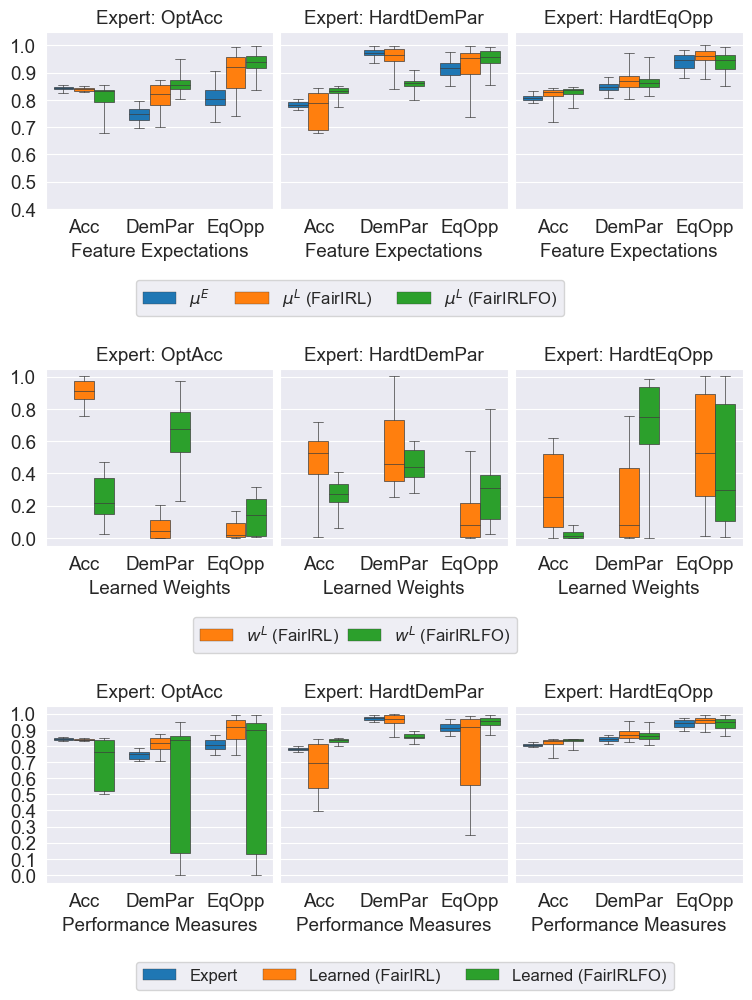

In [575]:
size_mult = 1.5
plt.rc('axes', titlesize=9*size_mult)     # fontsize of the axes title
plt.rc('axes', labelsize=9*size_mult)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=9*size_mult)    # fontsize of the tick labels
plt.rc('ytick', labelsize=9*size_mult)    # fontsize of the tick labels
plt.rc('ytick', labelsize=9*size_mult)    # fontsize of the tick labels
plt.rc('legend', fontsize=8*size_mult)    # legend fontsize
plt.rc('figure', titlesize=9*size_mult)  # fontsize of the figure title

print('Experiment ID:', exp_info['EXPERIMENT_NAME'])
    
fig, axes, mu_dfs, w_dfs, perf_dfs = plot_results_source_domain_only(
    feat_objective_set_names=base_exp_info['FEAT_EXP_OBJECTIVE_NAMES'],
    perf_objective_set_names=base_exp_info['PERF_MEAS_OBJECTIVE_NAMES'],
#     expert_algos=np.unique([exp['EXPERT_ALGO'] for exp in experiments]),
    expert_algos=['OptAcc', 'HardtDemPar', 'HardtEqOpp'],
    dataset=base_exp_info['DATASET'],
    mu_noise_factor=.01,
    perf_noise_factor=.01,
    w_noise_factor=.01,
    mu_hue_order=['muE', 'muL (FairIRL)', 'muL (FairIRLFO)'],
    perf_hue_order=['muE', 'muL (FairIRL)', 'muL (FairIRLFO)'],
    w_hue_order=[None, 'wL (FairIRL)', 'wL (FairIRLFO)'],
    extra_skip_conditions=skip_by_name,
    min_exp_timestamp=min_exp_timestamp,
    min_mu_value=.6,
    max_mu_value=1,
    min_w_value=0,
    mu_yticks=np.linspace(0, 1, 11).round(1),
    mu_ylim=(.4, 1.05),
    mu_whis=[1, 99],
    w_yticks = np.linspace(0, 1, 6).round(1),
    w_ylim=(-.05, 1.05),
    w_whis=[5, 95],
    perf_ylim=(-.05, 1.05),
    perf_yticks=np.linspace(0, 1, 11).round(1),
    size_mult=size_mult,
)


# Compare results with target domain

Experiment ID: thesis_5
SOURCE DATASET: Boston
TARGET DATASET: COMPAS


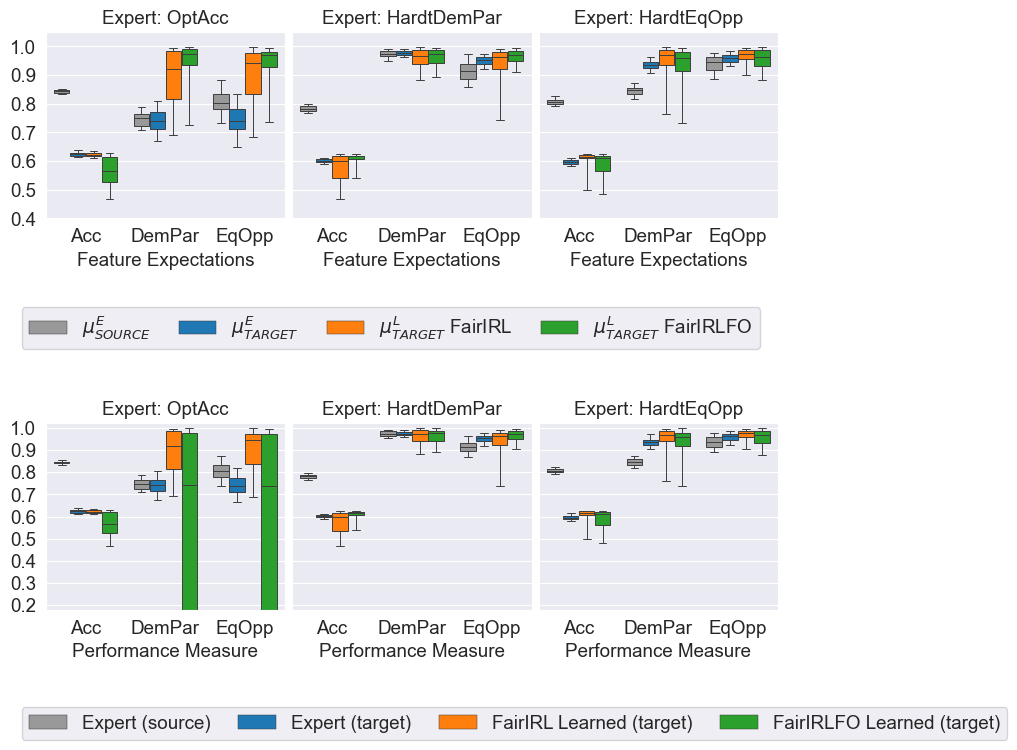

In [578]:
## plt.rc('axes', titlesize=11)     # fontsize of the axes title
size_mult = 1.5
plt.rc('axes', labelsize=9*size_mult)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=9*size_mult)    # fontsize of the tick labels
plt.rc('ytick', labelsize=9*size_mult)    # fontsize of the tick labels
plt.rc('legend', fontsize=9*size_mult)    # legend fontsize
plt.rc('figure', titlesize=9*size_mult)  # fontsize of the figure title

print('Experiment ID:', exp_info['EXPERIMENT_NAME'])

result, mu_df, w_df, perf_df = plot_results_target_domain(
    feat_objective_set_names=base_exp_info['FEAT_EXP_OBJECTIVE_NAMES'],
    perf_objective_set_names=base_exp_info['PERF_MEAS_OBJECTIVE_NAMES'],
#     expert_algos=np.unique([exp['EXPERT_ALGO'] for exp in experiments]),
    expert_algos=['OptAcc', 'HardtDemPar', 'HardtEqOpp'],
    source_dataset=base_exp_info['DATASET'],
    target_dataset=base_exp_info['TARGET_DATASET'],
    mu_noise_factor=.001,
    extra_skip_conditions=skip_by_name,
    min_exp_timestamp=min_exp_timestamp,
    min_mu_value=.4,
    mu_yticks=np.linspace(0, 1, 11).round(1),
    mu_ylim=(.4, 1.05),
    mu_whis=[5, 95],
    perf_noise_factor=.01,
    perf_hue_order=['muE', 'muL (FairIRL)', 'muL (FairIRLFO)'],
    perf_yticks=np.linspace(.2, 1, 9).round(1),
    perf_ylim=(.18, 1.02),
    size_mult=size_mult,
)

# Scratch

In [170]:
exp_info = dict(base_exp_info)
exp_info['FEAT_EXP_OBJECTIVE_NAMES'] = [
    'TPR_Z0', 'TPR_Z1',
#     'TNR_Z0', 'TNR_Z1',
    'FPR_Z0', 'FPR_Z1',
#     'FNR_Z0', 'FNR_Z1',
#     'Acc',
#     'DemPar',
#     'EqOpp',
#     'PredPar',
]
exp_info['RESTRICT_Y_ACTION'] = True

X, y, ft = generate_compas_dataset(20_000)
# X, y, ft = generate_adult_dataset(20_000)

# Initiate objectives
objectives = []
for obj_name in exp_info['FEAT_EXP_OBJECTIVE_NAMES']:
    objectives.append(OBJ_LOOKUP_BY_NAME[obj_name]())
feat_obj_set = ObjectiveSet(objectives)
del objectives
# Reset the objective set since they get fitted in each trial run
feat_obj_set.reset()


X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=.2,
)
del X, y


# Fit a classifier that predicts `y` from `X`.
clf = sklearn_clf_pipeline(
    feature_types=ft,
    clf_inst=RandomForestClassifier(),
)
clf.fit(X_train, y_train)

# Initiate variables needed to run IRL Loop
x_cols = (
    ft['boolean']
    + ft['categoric']
    + ft['continuous']
)
x_cols.remove('z')

# wi = [.2, .3, -.15, -.2]  # .598, .881, .906
# wi = [.195, .22, -.205, -.17]  # .608, .984, .994
wi = [.2, .3, .15, .2]  # .598, .881, .906
# wi = [.9, .02, .02]


reward_weights = { obj.name: wi[j] for j, obj in enumerate(feat_obj_set.objectives) }

test_df = X_test.copy()
test_df['y'] = y_test
# test_df = X_train.copy()
# test_df['y'] = y_train
# test_df['y'] = clf.predict(X_test)

clf_pol = compute_optimal_policy(
    clf_df=test_df,  # NOT the dataset used to train the C_{Y_Z,X} clf
    clf=clf,
    x_cols=x_cols,
    obj_set=feat_obj_set,
    reward_weights=reward_weights,
    skip_error_terms=True,
    method=exp_info['METHOD'],
    min_freq_fill_pct=exp_info['MIN_FREQ_FILL_PCT'],
)

demo = generate_demo(clf_pol, X_train, y_train, can_observe_y=False)
muj = feat_obj_set.compute_demo_feature_exp(demo)
print(f"\t\t muL = {np.round(muj, 3)}")


print('Acc', AccuracyObjective().compute_feat_exp(demo).round(3))
print('DemPar', DemographicParityObjective().compute_feat_exp(demo).round(3))
print('EqOpp', EqualOpportunityObjective().compute_feat_exp(demo).round(3))

display(demo.groupby(['z', 'y'])[['yhat']].agg(['count', 'mean', 'sum']))
display(demo.groupby(['z'])[['yhat']].agg(['count', 'mean', 'sum']))

		 muL = [0.748 0.776 0.503 0.396]
Acc 0.605
DemPar 0.947
EqOpp 0.972


yhat                  
    count      mean     sum
z y                        
0 0  4608  0.496745  2289.0
  1  4768  0.748112  3567.0
1 0  2650  0.604151  1601.0
  1  1970  0.776142  1529.0

yhat                  
  count      mean     sum
z                        
0  9376  0.624573  5856.0
1  4620  0.677489  3130.0

# HW Scratch

In [11]:
from math import comb
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

### Problem 1

In [28]:
def expected_4_cliques(n, p):
    return comb(n, 4) * p**6

In [45]:
def thresh_4_clique(n):
    return comb(n, 4)**(-(1/6))

In [120]:
expected_4_cliques(int(1e15), p=1e-9)

41666.66666666643

100000 0.0007883266647717149
1000000 0.0001698383027949114
10000000 3.659052019222436e-05


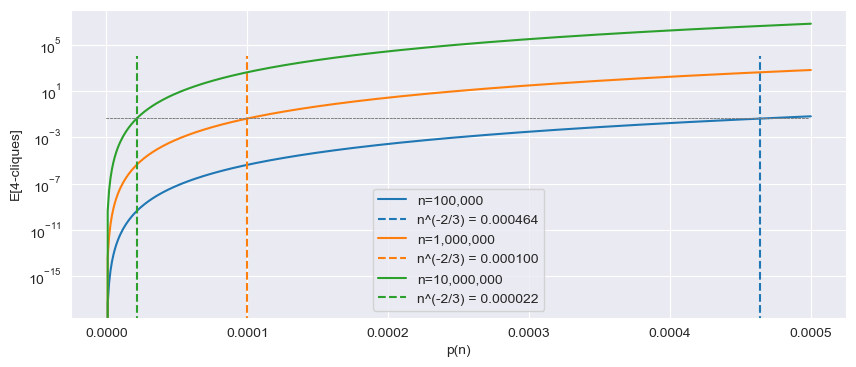

In [237]:
sns.set_style('darkgrid')
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
cp = sns.color_palette()

for i, n in enumerate([100_000, 1_000_000, 10_000_000]):
    x = np.linspace(0, .0005, 501)
    y = [expected_4_cliques(n, p) for p in x]
    ax.plot(x, y, label=f"n={n:,}", c=cp[i])
    ax.set_xlabel('p(n)')
    ax.set_ylabel('E[4-cliques]')
    print(n, thresh_4_clique(n))
    
    thresh = n**(-2/3)
    threshx = [thresh for _ in range(10)]
    threshy = np.linspace(0, 1e4, 10)
    ax.plot(threshx, threshy, ls='--', label=f"n^(-2/3) = {thresh:.6f}", c=cp[i])
    
    x2 = np.linspace(0, .95*ax.get_xlim()[1], 2)
    y2 = .05*np.ones(2)
    ax.plot(x2, y2, ls='--', lw=.5, c='gray')

# ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
pass

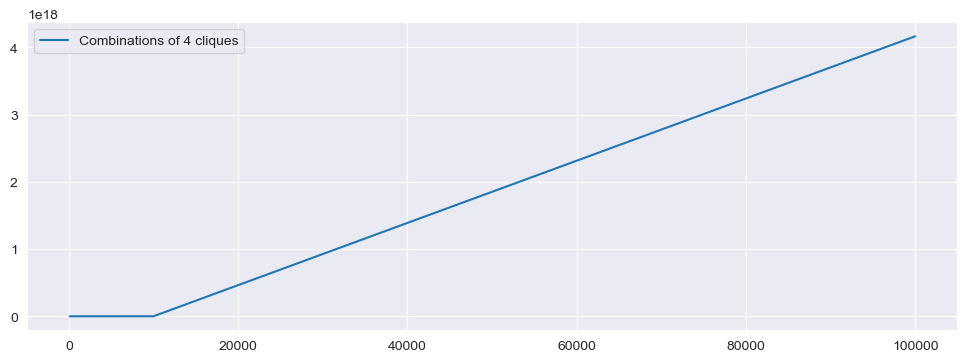

In [95]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
x1 = [100, 1_000, 10_000, 100_000]
y1 = [comb(n, 4) for n in x1]
x2 = np.linspace(0, 1, 101)
y2 = [p**6 for p in x2]
ax.plot(x1, y1, label='Combinations of 4 cliques')
# ax.plot(x2, y2, label='p^6(n)')
ax.legend()

In [42]:
comb(1000, 4) * 2**(-(comb(4, 2)))

647142574.21875

In [43]:
2**(-(comb(4, 2)))

0.015625

### Problem 4

In [157]:
def prob_vertex_has_deg_k(n, k, p):
    return comb(n, k) * (p**k) * (1-p)**(n-k)

In [197]:
k_range = [
    3,
    int(np.log(n)),
    int(np.sqrt(n)),
    int(n-1),
]
n = 1_000
d = 100
p = d / n

for k in k_range:
    output = n * comb(n, k) * (p**k)
    print(k, ':', output)

3 : 166167000.00000003
6 : 1368173298991.5005
31 : 7.602322407769473e+30
999 : 0.0
